In [1]:
import math
import os
import re
from typing import Union
from collections import defaultdict

import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.figure import figaspect
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import spatial, stats
from tqdm import tqdm 

import MSDiversity as msd

/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'  # To keep text as text in SVGs

# Helper Functions

In [3]:
def append_series_to_df(df: pd.DataFrame, series: pd.Series, column_name: str):
    """
    Appends a Series to a DataFrame as a new column while ensuring that no data 
    is lost from the DataFrame and accommodating new indices from the Series.
    
    Parameters:
    - df: The DataFrame to which the Series should be appended.
    - series: The Series to append.
    - column_name: The name of the new column.
    
    Returns:
    - A DataFrame with the Series appended as a new column.
    """

    # Combine the indices of the DataFrame and the Series
    combined_index = df.index.union(series.index)
    
    # Reindex the DataFrame based on the combined index
    df = df.reindex(combined_index, fill_value=0)
    
    # Add the series as a new column to the DataFrame
    df[column_name] = series

    return df

In [4]:
def compute_average_frequency(df: pd.DataFrame):
    """
    Compute the average frequency of each cell type across all samples.

    Parameters:
    - df (pd.DataFrame): Input dataframe with cell counts.

    Returns:
    - pd.Series: Average frequency of each cell type.
    """
    
    # Compute frequency for each sample
    df_normalized = df.divide(df.sum(axis=0), axis=1)

    # Compute average frequency across all samples
    average_frequency = df_normalized.mean(axis=1)
    
    return average_frequency

In [5]:
import time
from typing import Union, List

In [6]:
def subsampling(spatial_data:Union[ad.AnnData,pd.DataFrame], 
                library_key:str, 
                library_id:str, 
                num_squares:Union[int,float], 
                spatial_key:Union[str,List[str]]):
    """
    This function generates a list of patches from a spatial data object.
    
    Parameters:
    spatial_data: anndata.AnnData or pandas.DataFrame
        The spatial data from which to generate patches.
    scaling_factor: int or float
        The scaling factor to determine the size of the patches.
    spatial_key: str or list
        The key or list of keys to access the spatial data.
        
    Returns:
    list
        A list of patches.
    """
    
    if isinstance(spatial_data, ad.AnnData):
        spatial_data_filtered = spatial_data[spatial_data.obs[library_key] == library_id]
    elif isinstance(spatial_data, pd.DataFrame):
        spatial_data_filtered = spatial_data[spatial_data[library_key] == library_id]
    else:
        raise ValueError("spatial_data should be either an AnnData object or a pandas DataFrame")
    
    # check if spatial_data is an AnnData object or a DataFrame, and get spatial coordinates
    if isinstance(spatial_data, ad.AnnData):
        spatial_values = spatial_data_filtered.obsm[spatial_key]
    elif isinstance(spatial_data, pd.DataFrame):
        spatial_values = spatial_data_filtered[spatial_key].values
    else:
        raise ValueError("spatial_data should be either an AnnData object or a pandas DataFrame")

        
    width = spatial_values.max(axis=0)[0] - spatial_values.min(axis=0)[0]
    height = spatial_values.max(axis=0)[1] - spatial_values.min(axis=0)[1]
    
    # Define the size of each patch
    patch_width = width / num_squares[0]
    patch_height = height / num_squares[1]
    
    # Create a list to store the patch coordinates
    patches = []

    for y0 in np.arange(spatial_values.min(axis=0)[1], spatial_values.max(axis=0)[1], patch_height):
        for x0 in np.arange(spatial_values.min(axis=0)[0], spatial_values.max(axis=0)[0], patch_width):
            # Define the coordinates of the current patch
            x1 = x0 + patch_width
            y1 = y0 + patch_height
            # Add the current patch to the list
            patches.append((x0, y0, x1, y1))
    return patches

In [7]:
def subsampling_randomly(spatial_data: Union[ad.AnnData, pd.DataFrame], 
                         library_key:str, 
                         library_id:str, 
                         sample_size:Union[int,float], 
                         sample_number:int,
                         spatial_key:Union[str,List[str]], 
                         max_overlap=0.0, 
                         random_seed=None, 
                         min_points=2):
    
    rng = np.random.default_rng(random_seed)

    if isinstance(spatial_data, ad.AnnData):
        spatial_data_filtered = spatial_data[spatial_data.obs[library_key] == library_id]
    elif isinstance(spatial_data, pd.DataFrame):
        spatial_data_filtered = spatial_data[spatial_data[library_key] == library_id]
    else:
        raise ValueError("spatial_data should be either an AnnData object or a pandas DataFrame")
    
    if isinstance(spatial_data, ad.AnnData):
        spatial_values = spatial_data_filtered.obsm[spatial_key]
    elif isinstance(spatial_data, pd.DataFrame):
        spatial_values = spatial_data_filtered[spatial_key].values
    else:
        raise ValueError("spatial_data should be either an AnnData object or a pandas DataFrame")

    width = spatial_values.max(axis=0)[0] - spatial_values.min(axis=0)[0]
    height = spatial_values.max(axis=0)[1] - spatial_values.min(axis=0)[1]

    patch_width = sample_size[0]
    patch_height = sample_size[1] if sample_size[1] else sample_size[0]

    num_patches = sample_number

    patches = []
    used_coordinates = set()
    
    for _ in range(num_patches):
        start_time = time.time()
        while True:
            if time.time() - start_time > 5:  # seconds
                print(f"Warning: Could not generate a new patch within 5 seconds. Return {len(patches)} out of {num_patches} patches")
                return patches
            
            x0 = rng.uniform(spatial_values.min(axis=0)[0], spatial_values.max(axis=0)[0] - patch_width)
            y0 = rng.uniform(spatial_values.min(axis=0)[1], spatial_values.max(axis=0)[1] - patch_height)
            x1 = x0 + patch_width
            y1 = y0 + patch_height
            new_patch = (x0, y0, x1, y1)
            if ((x0, y0) not in used_coordinates and 
                msd.overlap_check(new_patch, patches, max_overlap) and 
                msd.contains_points(new_patch, spatial_values, min_points)  ):
                used_coordinates.add((x0, y0))
                patches.append(new_patch)
                break

    return patches

# Read Data

In [8]:
data_dir = '/Users/Emrys/Dropbox/spatial_augmentation/data/cosMx_liver/data/'
results_dir = './results_crc'

# Load data
# combine data os path
liver_df = pd.read_csv(os.path.join(data_dir, 'cosMx_liver_meta.csv')) # ~793318 cells
liver_df.columns

Index(['RNA_pca_cluster_default', 'RNA_pca_cluster_default.1', 'orig.ident',
       'nCount_RNA', 'nFeature_RNA', 'nCount_negprobes', 'nFeature_negprobes',
       'nCount_falsecode', 'nFeature_falsecode', 'fov', 'Area', 'AspectRatio',
       'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CK8.18',
       'Max.CK8.18', 'Mean.Membrane', 'Max.Membrane', 'Mean.CD45', 'Max.CD45',
       'Mean.DAPI', 'Max.DAPI', 'cell_id', 'assay_type', 'Run_name',
       'slide_ID_numeric', 'Run_Tissue_name', 'Panel', 'Mean.Yellow',
       'Max.Yellow', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'cell_ID', 'x_FOV_px',
       'y_FOV_px', 'x_slide_mm', 'y_slide_mm', 'propNegative', 'complexity',
       'errorCtEstimate', 'percOfDataFromError', 'qcFlagsRNACounts',
       'qcFlagsCellCounts', 'qcFlagsCellPropNeg', 'qcFlagsCellComplex',
       'qcFlagsCellArea', 'median_negprobes', 'negprobes_quantile_0.9',
       'median_RNA', 'RNA_quantile_0.9', 'nCell', 'nCount', 'nCountPerCell',
       'nFeaturePerCell', 'propNe

In [9]:
liver_df = liver_df[['cell_ID', 'Run_Tissue_name', 'x_slide_mm', 'y_slide_mm', 'fov', 'nCell', 'cellType', 'niche']].copy()
liver_df['x_slide_um'] = (liver_df['x_slide_mm']*1000.0).round(0)
liver_df['y_slide_um'] = (liver_df['y_slide_mm']*1000.0).round(0)
liver_df

cell_ID Run_Tissue_name  x_slide_mm  y_slide_mm  fov  nCell  \
0         c_1_100_10     NormalLiver     9.03144     9.73500  100   1265   
1       c_1_100_1078     NormalLiver     8.77440     9.25824  100   1265   
2       c_1_100_1135     NormalLiver     8.87928     9.23412  100   1265   
3        c_1_100_267     NormalLiver     9.12132     9.61104  100   1265   
4        c_1_100_732     NormalLiver     9.08436     9.40548  100   1265   
...              ...             ...         ...         ...  ...    ...   
793313     c_2_9_945  CancerousLiver     5.44420    11.27840    9    949   
793314     c_2_9_947  CancerousLiver     5.45332    11.27804    9    949   
793315     c_2_9_948  CancerousLiver     5.32684    11.27792    9    949   
793316     c_2_9_949  CancerousLiver     5.29252    11.27732    9    949   
793317      c_2_9_95  CancerousLiver     5.62432    11.70812    9    949   

                            cellType    niche  x_slide_um  y_slide_um  
0                              Hep.3  Zone_3a      9031.0      9735.0  
1                              Hep.4  Zone_2a      8774.0      9258.0  
2           Inflammatory.macrophages  Zone_2a      8879.0      9234.0  
3                              Hep.5  Zone_2a      9121.0      9611.0  
4               Central.venous.LSECs  Zone_2a      9084.0      9405.0  
...                              ...      ...         ...         ...  
793313      Inflammatory.macrophages    tumor      5444.0     11278.0  
793314  Non.inflammatory.macrophages    tumor      5453.0     11278.0  
793315                       tumor_1    tumor      5327.0     11278.0  
793316                       tumor_1    tumor      5293.0     11277.0  
793317                       tumor_1    tumor      5624.0     11708.0  

[793318 rows x 10 columns]

In [10]:
# liver_df = liver_df[~liver_df['cellType'].str.contains('NotDet')]

29.297 per cent patches are empty


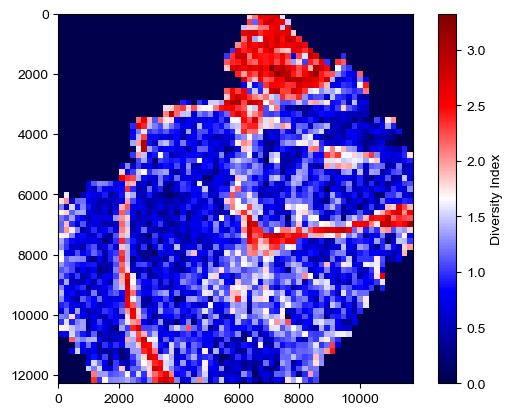

In [37]:
sample_key = 'Run_Tissue_name'
test_sample = 'CancerousLiver'
cluster_key = 'cellType' 

patches_coordinates = msd.generate_patches(liver_df,
                                           sample_key,
                                           test_sample,
                                           scaling_factor=64.,
                                           spatial_key=['x_slide_um', 'y_slide_um'])

patch_indices, patches_comp = msd.calculate_diversity_index(spatial_data=liver_df, 
                                                            library_key=sample_key, 
                                                            library_id=test_sample, 
                                                            spatial_key=['x_slide_um', 'y_slide_um'], 
                                                            patches=patches_coordinates, 
                                                            cluster_key=cluster_key, 
                                                            metric='Shannon Diversity', return_comp=True)


# Visualize the heterogeneity indices
grid, heatmap_fig = msd.diversity_heatmap(spatial_data=liver_df,
                                          library_key=sample_key, 
                                          library_id=test_sample,
                                          spatial_key=['x_slide_um', 'y_slide_um'],
                                          patches=patches_coordinates, 
                                          heterogeneity_indices=patch_indices,
                                          tissue_only=True,
                                          plot=True,
                                          return_fig=True)

In [38]:
save_path = cluster_key + '_' + test_sample + '_heatmap_wholeTissue.svg'
heatmap_fig.savefig('../figures/liver/'+save_path)
plt.close(heatmap_fig)

In [39]:
print(msd.global_moran(grid, tissue_only=True))

Global Moran restricted to tissue region with w of shape(2896, 2896)
(0.5615765738985597, 0.001)


In [40]:
hotspots, coldspots, doughnuts, diamonds = msd.local_moran(grid,tissue_only=True,p_value=0.01,plot_weights=False)
print(sum(hotspots.flatten()), flush=True)
print(sum(coldspots.flatten()), flush=True)
print(sum(doughnuts.flatten()), flush=True)
print(sum(diamonds.flatten()), flush=True)
combined_spots = (hotspots * 1) + (coldspots * -1) #+ (doughnuts * 0.5) + (diamonds * -0.5)
seismic = plt.cm.seismic
colors = [seismic(0), "lightblue", "white", "salmon", seismic(0.999)]
cmap = mcolors.LinearSegmentedColormap.from_list("custom_map", colors)

(2896,)
Local Moran restricted to tissue region with w of shape(2896, 2896)
344
259
25
5


11770.0 12268.0


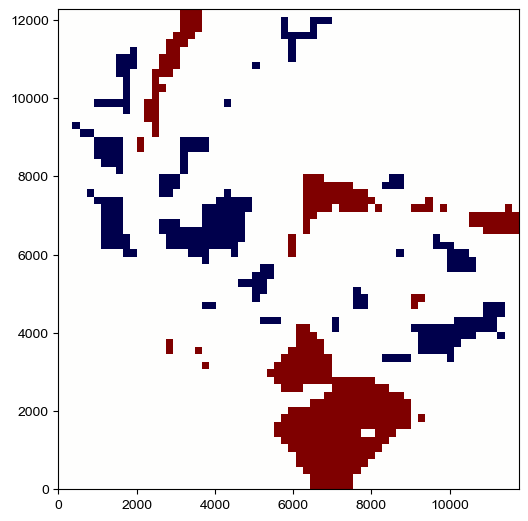

In [41]:
patch_sample_df = liver_df.loc[(liver_df[sample_key] == test_sample),:].copy()
x_coords = patch_sample_df['x_slide_um']
y_coords = patch_sample_df['y_slide_um']
min_x, min_y = np.min(x_coords), np.min(y_coords)
max_x, max_y = np.max(x_coords), np.max(y_coords)
width = max_x - min_x
height = max_y - min_y
print(width, height)
w, h = figaspect(height/width)

spot_fig = plt.figure(figsize=(w, h))
ax = spot_fig.add_axes([0, 0, 1, 1])

# Create a 2D grid
grid = np.zeros((int(max_y - min_y + 1), int(max_x - min_x + 1)))

# Fill the grid with heterogeneity indices
for patch, diversity_index in enumerate(combined_spots.flatten()):
    x0, y0, x1, y1 = patches_coordinates[patch]
    grid[int(y0-min_y):int(y1-min_y+1), int(x0-min_x):int(x1-min_x+1)] = diversity_index

# Plot the heatmap
ax.imshow(grid, cmap=cmap, interpolation='none', vmin=-1, vmax=1)
# ax.imshow(grid, cmap='Greys', interpolation='none', vmin=0, vmax=1, alpha=0.1)
# Invert the y-axis
ax.invert_yaxis()

# save_path = test_sample + '_spot.svg'
# spot_fig.savefig('../figures/liver/'+save_path, dpi=300)
# save_path = test_sample + '_spot.jpeg'
# spot_fig.savefig('../figures/liver/'+save_path, dpi=300)

In [42]:
print(msd.compute_proximity_index(hotspots))

14 islands identified
171.43105698577355


In [17]:
bokai_palette = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', 
 '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
 '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', 
 '#000000']
print(len(bokai_palette))
print(len(pd.unique(liver_df['cellType'])))
bokai_palette1 = dict(zip(pd.unique(liver_df['cellType']), bokai_palette))
bokai_palette1 = {key: bokai_palette1[key] for key in sorted(bokai_palette1)}
bokai_palette2 = dict(zip(pd.unique(liver_df['niche']), bokai_palette))

22
22


In [44]:
Hot = True
if Hot:
    filtered_patches_coordinates = [patch for patch, is_hotspot in zip(patches_coordinates, hotspots.flatten()) if is_hotspot]
    filtered_patches_comp = [patch for patch, is_hotspot in zip(patches_comp, hotspots.flatten()) if is_hotspot]
else:
    filtered_patches_coordinates = [patch for patch, is_coldspot in zip(patches_coordinates, coldspots.flatten()) if is_coldspot]
    filtered_patches_comp = [patch for patch, is_coldspot in zip(patches_comp, coldspots.flatten()) if is_coldspot]
merged_series = pd.concat(filtered_patches_comp, axis=1).sum(axis=1)
merged_series

cellType
tumor_1                         14193.0
CD3+.alpha.beta.T.cells          9580.0
Inflammatory.macrophages         6640.0
Mature.B.cells                   2099.0
Periportal.LSECs                 2372.0
Portal.endothelial.cells          221.0
Non.inflammatory.macrophages     2382.0
Central.venous.LSECs              334.0
NK.like.cells                     381.0
Hep                              1189.0
Antibody.secreting.B.cells        644.0
Cholangiocytes                    801.0
Stellate.cells                   3140.0
Erthyroid.cells                    19.0
gamma.delta.T.cells.1              96.0
tumor_2                          3506.0
NotDet                              2.0
dtype: float64

In [45]:
# Convert the series to a dataframe
spot_df = merged_series.reset_index()
spot_df.columns = ['cellType', 'count']
spot_df['Run_Tissue_name'] = test_sample
# Calculate total and frequency
spot_df['total'] = spot_df['count'].sum()
spot_df['Frequency'] = spot_df['count'] / spot_df['total']
spot_df = spot_df.sort_values(by='cellType')
spot_df

cellType    count Run_Tissue_name    total  Frequency
10    Antibody.secreting.B.cells    644.0  CancerousLiver  47599.0   0.013530
1        CD3+.alpha.beta.T.cells   9580.0  CancerousLiver  47599.0   0.201265
7           Central.venous.LSECs    334.0  CancerousLiver  47599.0   0.007017
11                Cholangiocytes    801.0  CancerousLiver  47599.0   0.016828
13               Erthyroid.cells     19.0  CancerousLiver  47599.0   0.000399
9                            Hep   1189.0  CancerousLiver  47599.0   0.024980
2       Inflammatory.macrophages   6640.0  CancerousLiver  47599.0   0.139499
3                 Mature.B.cells   2099.0  CancerousLiver  47599.0   0.044098
8                  NK.like.cells    381.0  CancerousLiver  47599.0   0.008004
6   Non.inflammatory.macrophages   2382.0  CancerousLiver  47599.0   0.050043
16                        NotDet      2.0  CancerousLiver  47599.0   0.000042
4               Periportal.LSECs   2372.0  CancerousLiver  47599.0   0.049833
5       Portal.endothelial.cells    221.0  CancerousLiver  47599.0   0.004643
12                Stellate.cells   3140.0  CancerousLiver  47599.0   0.065968
14         gamma.delta.T.cells.1     96.0  CancerousLiver  47599.0   0.002017
0                        tumor_1  14193.0  CancerousLiver  47599.0   0.298179
15                       tumor_2   3506.0  CancerousLiver  47599.0   0.073657

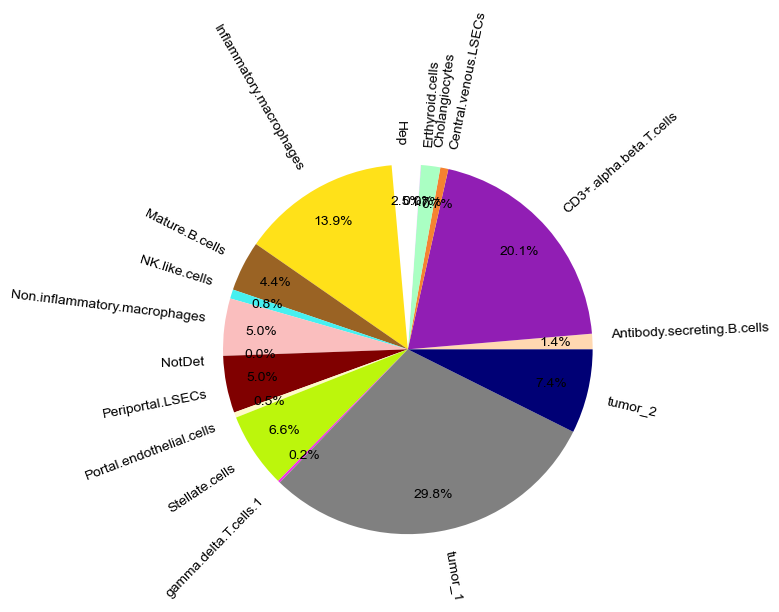

In [46]:
if Hot:
    save_path = 'hotspot_composition_whole_' + test_sample + '.svg'
else:
    save_path = 'coldspot_composition_whole_' + test_sample + '.svg'
composition_pie = plt.figure(figsize=(6, 6))
plt.pie(spot_df['Frequency'], 
        labels=spot_df['cellType'], 
        colors=[bokai_palette1[cell] for cell in spot_df['cellType']],
        autopct='%.1f%%',
        pctdistance=0.8,
        rotatelabels=True)
plt.title('')
composition_pie.savefig('../figures/liver/'+save_path)
plt.show()

In [33]:
data_list = []
data_list.append({'Run_Tissue_name': 'Healthy Liver', 
                  'MDI': 0.105, 
                  'GDI': 0.230,
                  'DPI': 40.8})
data_list.append({'Run_Tissue_name': 'HCC Liver', 
                  'MDI': 0.076, 
                  'GDI': 0.562,
                  'DPI': 171})
data = pd.DataFrame(data_list)
data

Run_Tissue_name    MDI    GDI    DPI
0   Healthy Liver  0.105  0.230   40.8
1       HCC Liver  0.076  0.562  171.0

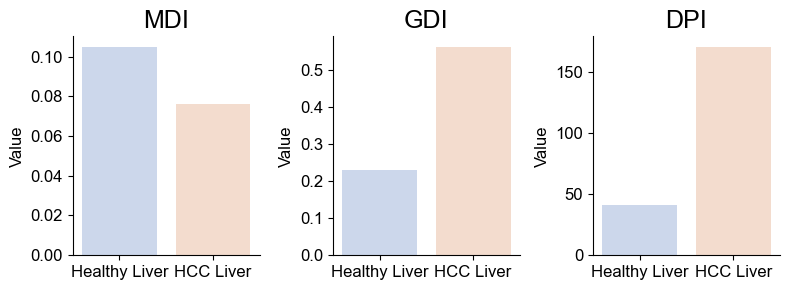

In [65]:
# Creating separate subplots for each metric due to the difference in their value ranges
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharey=False)
metrics = ['MDI', 'GDI', 'DPI']

for i, metric in enumerate(metrics):
    sns.barplot(x='Run_Tissue_name', y=metric, data=data, ax=axes[i], hue='Run_Tissue_name', palette='muted')
    axes[i].set_title(f'{metric}', fontsize=18)
    axes[i].set_ylabel('Value', fontsize=12)
    axes[i].set_xlabel('', fontsize=12)
    axes[i].tick_params(axis='both', labelsize=12) 
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    
    # Set alpha for each bar in the plot
    for bar in axes[i].patches:
        bar.set_alpha(0.3)
plt.tight_layout()
fig.savefig('../figures/liver/ecology_metrics_wholetissue_liver.svg')
plt.show()

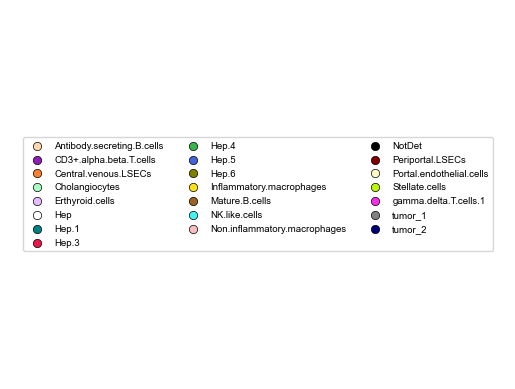

In [16]:
fig, ax = plt.subplots()

# Create a scatter plot for each item in the dictionary
for label, color in bokai_palette1.items():
    ax.scatter([], [], c=color, label=label, marker='o',edgecolors='black', linewidths=0.5)

# Create the legend
ax.legend(loc='center', ncol=3, fontsize='x-small')

# Hide axes
ax.axis('off')

save_path = 'cellType' + '_legend.jpeg'
# plt.savefig('../figures/liver/'+save_path, dpi=300, bbox_inches='tight')
# save_path = 'cellType' + '_legend.svg'
# plt.savefig('../figures/liver/'+save_path, dpi=300, bbox_inches='tight')
plt.show()

# Subsampling

In [12]:
liver_df.loc[:, 'sample'] = '-1'  # Initialize the 'patches' column with -1 
patches_coord_dict = {}
for tissue_type in pd.unique(liver_df['Run_Tissue_name']):
    print(f"Processing {tissue_type}", flush=True)
    # patches_coord = subsampling(liver_df,
    #                             'Run_Tissue_name',
    #                             tissue_type,
    #                             num_squares=[11.0,8.0], 
    #                             spatial_key=['x_slide_um', 'y_slide_um'])

    patches_coord = subsampling_randomly(spatial_data=liver_df, 
                                         library_key='Run_Tissue_name', 
                                         library_id=tissue_type, 
                                         sample_size=[1600,1600],
                                         sample_number=10,
                                         spatial_key=['x_slide_um', 'y_slide_um'], 
                                         max_overlap=0.0, 
                                         random_seed=42, 
                                         min_points=12000)    
    
    patches_coord_dict[tissue_type] = patches_coord
    print(f"Total number of patches: {len(patches_coord)}",flush=True)
    print(patches_coord)
    # Iterate over patches
    for i, patch in enumerate(patches_coord):
        x0, y0, x1, y1 = patch
        
        # Define the number of decimal places for rounding
        decimal_places = 5
        
        # When assigning patch coordinates
        x0 = round(x0, decimal_places)
        y0 = round(y0, decimal_places)
        x1 = round(x1, decimal_places)
        y1 =round(y1, decimal_places)
    
        # Update the 'patches' column for cells within the current patch
        if tissue_type == 'NormalLiver':
            sample_name = 'N'+str(i)
        else:
            sample_name = 'C'+str(i)
            
        liver_df.loc[
            (liver_df['Run_Tissue_name'] == tissue_type) &
            (liver_df['x_slide_um'] >= x0) & 
            (liver_df['x_slide_um'] <= x1) & 
            (liver_df['y_slide_um'] >= y0) & 
            (liver_df['y_slide_um'] <= y1), 
            'sample'
        ] = sample_name
        # print(liver_df.loc[
        #     (liver_df['Run_Tissue_name'] == tissue_type) &
        #     (liver_df['x_slide_mm'] >= x0) & 
        #     (liver_df['x_slide_mm'] <= x1) & 
        #     (liver_df['y_slide_mm'] >= y0) & 
        #     (liver_df['y_slide_mm'] <= y1), 
        #     'patches'
        # ].shape[0])


# liver_df.drop(liver_df[ (liver_df['sample'] == '-1')].index, inplace=True)


Processing NormalLiver
Total number of patches: 10
[(1886.6148806917008, 10025.667690297836, 3486.614880691701, 11625.667690297836), (7967.310663046048, 8786.71629929017, 9567.310663046048, 10386.71629929017), (2196.0119891029517, 6592.722490085427, 3796.0119891029517, 8192.722490085427), (4408.565586928444, 9706.33596711446, 6008.565586928444, 11306.33596711446), (5070.607250708777, 5134.232285585302, 6670.607250708777, 6734.232285585302), (2302.5292319298533, 4397.568560631123, 3902.5292319298533, 5997.568560631123), (7121.82980264373, 6728.084803351514, 8721.82980264373, 8328.084803351514), (2416.6294404359564, 8200.149971508083, 4016.6294404359564, 9800.149971508083), (9767.184347122256, 6801.335263858796, 11367.184347122256, 8401.335263858797), (4050.9145487720484, 7052.114822553971, 5650.914548772049, 8652.114822553971)]
Processing CancerousLiver
Total number of patches: 10
[(8733.940845498759, 6956.522134005294, 10333.940845498759, 8556.522134005294), (959.7836280173957, 9924.93

In [11]:
# Filter out rows where 'sample' is -1 before calculating statistics for NormalLiver
normal_filtered_df = liver_df[(liver_df['Run_Tissue_name'] == 'NormalLiver') & (liver_df['sample'] != '-1')]
normal_counts = normal_filtered_df.groupby('sample').size()
mean_normal = normal_counts.mean()
std_normal = normal_counts.std()

# Filter out rows where 'sample' is -1 before calculating statistics for CancerousLiver
cancerous_filtered_df = liver_df[(liver_df['Run_Tissue_name'] == 'CancerousLiver') & (liver_df['sample'] != '-1')]
cancerous_counts = cancerous_filtered_df.groupby('sample').size()
mean_cancerous = cancerous_counts.mean()
std_cancerous = cancerous_counts.std()

print(f"NormalLiver - Mean cells per patch: {mean_normal}, Standard deviation: {std_normal}")
print(f"CancerousLiver - Mean cells per patch: {mean_cancerous}, Standard deviation: {std_cancerous}")


NormalLiver - Mean cells per patch: 12396.4, Standard deviation: 251.9608435187235
CancerousLiver - Mean cells per patch: 12950.9, Standard deviation: 592.3805927498526


In [12]:
pd.unique(liver_df['sample'])

array(['N1', '-1', 'N7', 'N9', 'N6', 'N8', 'N2', 'N4', 'N5', 'N0', 'N3',
       'C4', 'C0', 'C1', 'C5', 'C6', 'C7', 'C9', 'C2', 'C3', 'C8'],
      dtype=object)

In [22]:
# liver_df.to_csv('/Users/Emrys/Downloads/liver_subsample.csv')

(8201.0, 9800.0)

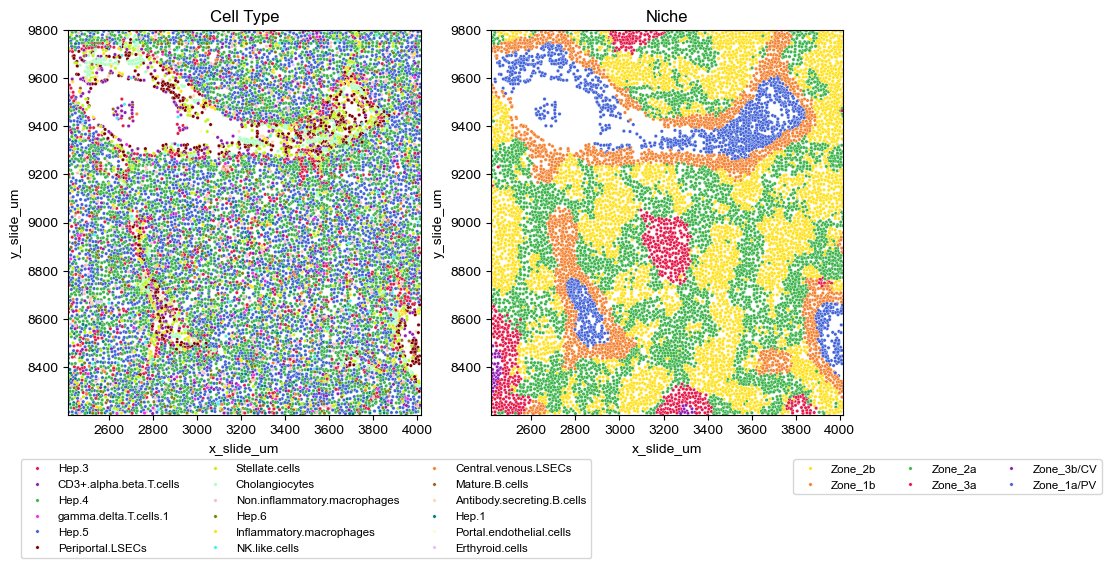

In [18]:
patch_number = 'N7'
patch_sample_df = liver_df.loc[(liver_df['sample'] == patch_number),:].copy()
x_coords = patch_sample_df['x_slide_um']
y_coords = patch_sample_df['y_slide_um']

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(data=patch_sample_df, x="x_slide_um", y="y_slide_um", hue="cellType", palette=bokai_palette1, s=6, legend='full', ax=axes[0],rasterized=True)
axes[0].set_title('Cell Type')
axes[0].legend(bbox_to_anchor=(1.5, -0.1), ncol=3, fontsize='small')
axes[0].set_xlim(x_coords.min(axis=0), x_coords.max(axis=0))
axes[0].set_ylim(y_coords.min(axis=0), y_coords.max(axis=0))

sns.scatterplot(data=patch_sample_df, x="x_slide_um", y="y_slide_um", hue="niche", palette=bokai_palette2, s=6, ax=axes[1],rasterized=True)
axes[1].set_title('Niche')
axes[1].legend(bbox_to_anchor=(1.75, -0.1), ncol=3, fontsize='small')
axes[1].set_xlim(x_coords.min(axis=0), x_coords.max(axis=0))
axes[1].set_ylim(y_coords.min(axis=0), y_coords.max(axis=0))


In [ ]:
min_x, min_y = np.min(x_coords), np.min(y_coords)
max_x, max_y = np.max(x_coords), np.max(y_coords)
width = max_x - min_x
height = max_y - min_y
print(width, height)
w, h = figaspect(height/width)
fig, ax = plt.subplots(1, 1, figsize=(w, h))

sns.scatterplot(data=patch_sample_df, x="x_slide_um", y="y_slide_um", hue="cellType", palette=bokai_palette1, s=6, legend='full', ax=ax,rasterized=True)
ax.set_title('Cell Type')
ax.legend(bbox_to_anchor=(1.5, -0.1), ncol=3, fontsize='small')
ax.set_xlim(x_coords.min(axis=0), x_coords.max(axis=0))
ax.set_ylim(y_coords.min(axis=0), y_coords.max(axis=0))
save_path = patch_number + '_subsample.svg'
fig.savefig('../figures/liver/'+save_path, dpi=300)

In [43]:
grouped_data['sample'][0][0]

'N'

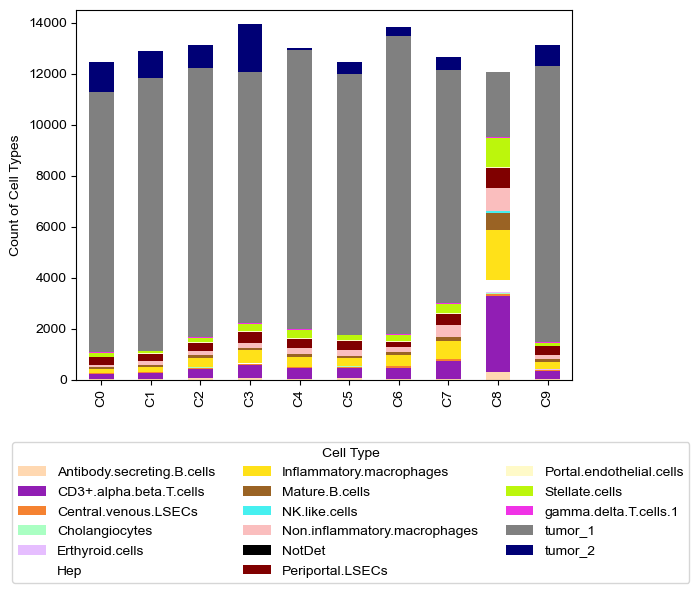

In [50]:
# Grouping the data by 'sample' and 'cellType' and counting the occurrences
grouped_data = cancerous_filtered_df.groupby(['sample', 'cellType']).size().reset_index(name='counts')

# Pivot the data to have samples on the x-axis, cellType as different bars, and counts as the height of the bars
pivoted_data = grouped_data.pivot(index='sample', columns='cellType', values='counts').fillna(0)

# Plotting
pivoted_data.plot(kind='bar', color=bokai_palette1, stacked=True, ylim=[0,14500])
plt.xlabel('')
plt.ylabel('Count of Cell Types')
plt.title('')
plt.legend(bbox_to_anchor=(1.25, -0.15), ncol=3, title='Cell Type')

if grouped_data['sample'][0][0] == 'N':
    save_path = 'normal_composition.svg'
else:
    save_path = 'cancerous_composition.svg'
plt.savefig('../figures/liver/'+save_path)

plt.show()

In [15]:
pivoted_data

cellType         Antibody.secreting.B.cells  CD3+.alpha.beta.T.cells  \
Run_Tissue_name                                                        
CancerousLiver                       1236.0                  20083.0   
NormalLiver                          1413.0                  13664.0   

cellType         Central.venous.LSECs  Cholangiocytes  Erthyroid.cells  \
Run_Tissue_name                                                          
CancerousLiver                 2138.0          1411.0            139.0   
NormalLiver                    4416.0          4783.0           1044.0   

cellType            Hep    Hep.1    Hep.3     Hep.4    Hep.5  ...  \
Run_Tissue_name                                               ...   
CancerousLiver   1204.0      0.0      0.0       0.0      0.0  ...   
NormalLiver         0.0  17364.0  21274.0  125997.0  89334.0  ...   

cellType         Mature.B.cells  NK.like.cells  Non.inflammatory.macrophages  \
Run_Tissue_name                                                                
CancerousLiver           4974.0          705.0                        9076.0   
NormalLiver              2928.0         2752.0                        9556.0   

cellType         NotDet  Periportal.LSECs  Portal.endothelial.cells  \
Run_Tissue_name                                                       
CancerousLiver      5.0           11893.0                    1060.0   
NormalLiver         4.0            6083.0                     537.0   

cellType         Stellate.cells  gamma.delta.T.cells.1   tumor_1  tumor_2  
Run_Tissue_name                                                            
CancerousLiver           7798.0                  549.0  347988.0  35385.0  
NormalLiver             16482.0                 3181.0       0.0      0.0  

[2 rows x 22 columns]

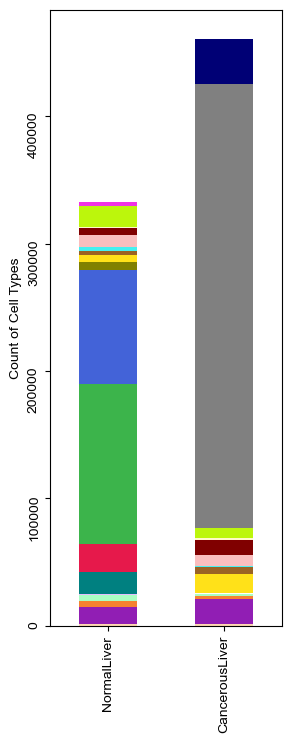

In [19]:
# Grouping the data by 'sample' and 'cellType' and counting the occurrences
grouped_data = liver_df.groupby(['Run_Tissue_name', 'cellType']).size().reset_index(name='counts')

# Pivot the data to have samples on the x-axis, cellType as different bars, and counts as the height of the bars
pivoted_data = grouped_data.pivot(index='Run_Tissue_name', columns='cellType', values='counts').fillna(0).sort_index(ascending=False)

# Plotting
fig, ax = plt.subplots(figsize=(3, 8)) 
pivoted_data.plot(kind='bar', color=bokai_palette1, stacked=True, ax=ax, legend=False)
plt.xlabel('')
plt.ylabel('Count of Cell Types')
plt.yticks(rotation=90)
plt.title('')
# plt.legend(bbox_to_anchor=(1.25, -0.2), ncol=3, title='Cell Type')
save_path = 'wholetissue_composition.svg'
plt.savefig('../figures/liver/'+save_path)
plt.show()

# Heatmap & Hot/Cold Spots Illustration

In [15]:
import matplotlib.patches as mpatches

In [16]:
sample_condition = 'NormalLiver'
cluster_key = 'niche' 
Hot = True

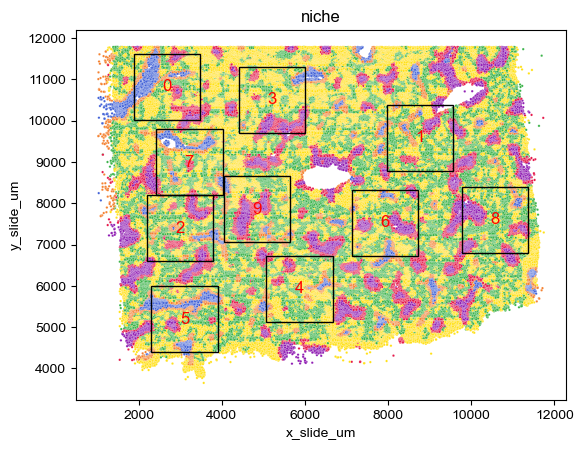

In [18]:
test_sample_df = liver_df.loc[(liver_df['Run_Tissue_name'] == sample_condition),:].copy()
patches_coordinates = patches_coord_dict[sample_condition]
x_coords = test_sample_df['x_slide_um']
y_coords = test_sample_df['y_slide_um']
width = x_coords.max(axis=0) - x_coords.min(axis=0)
height = y_coords.max(axis=0) - y_coords.min(axis=0)
w, h = figaspect(height/width)
fig, ax = plt.subplots(1, 1, figsize=(w, h))

sns.scatterplot(data=test_sample_df, x="x_slide_um", y="y_slide_um", hue=cluster_key, palette=bokai_palette2, s=3, legend='full', ax=ax, rasterized=True)
ax.set_title(cluster_key)
# ax.legend(bbox_to_anchor=(1.0, -0.1), ncol=3, fontsize='small')
ax.get_legend().remove()

for i, patch in enumerate(patches_coordinates):
    # Calculate the rectangle's parameters
    x, y = patch[0], patch[1]
    width, height = patch[2] - patch[0], patch[3] - patch[1]
    
    # Create and add the rectangle patch
    rect = mpatches.Rectangle((x, y), width, height, linewidth=1.0, edgecolor='black', facecolor='none')
    ax.add_patch(rect)
    
    # Add text inside or near the rectangle to indicate the index
    # Adjust the text position (x+width/2, y+height/2) as needed to place the text where you want inside the rectangle
    ax.text(x + width / 2, y + height / 2, str(i), ha='center', va='center', fontsize=12, color='red')


# plt.tight_layout()
save_path = cluster_key + '_NormalLiver_subsampling.jpeg'
plt.savefig('../figures/liver/'+save_path, dpi=300)
save_path = cluster_key + '_NormalLiver_subsampling.svg'
plt.savefig('../figures/liver/'+save_path, dpi=300)

In [29]:
x_coords.max(axis=0) - x_coords.min(axis=0),y_coords.max(axis=0) - y_coords.min(axis=0)

(10717.0, 8136.0)

In [33]:
11770.0/10717.0

1.0982551087057946

In [34]:
12268.0/8136.0

1.507866273352999

In [30]:
w, h

(6.322713864306785, 4.8)

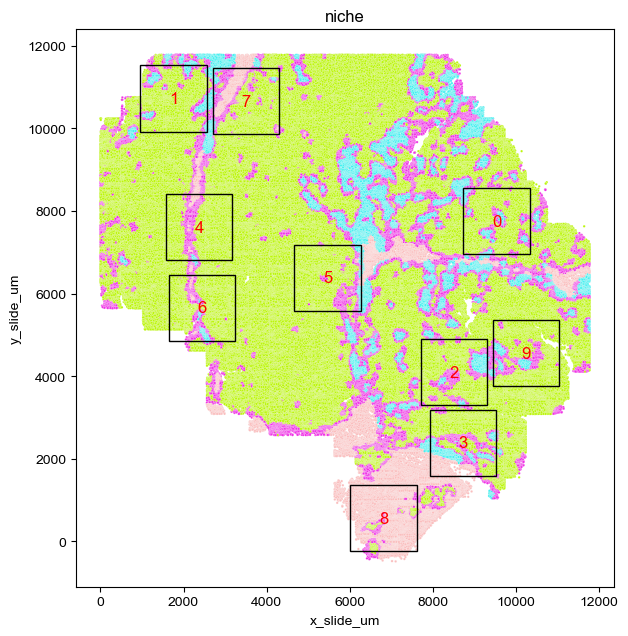

In [20]:
sample_condition = 'CancerousLiver'
test_sample_df = liver_df.loc[(liver_df['Run_Tissue_name'] == sample_condition),:].copy()
patches_coordinates = patches_coord_dict[sample_condition]
x_coords = test_sample_df['x_slide_um']
y_coords = test_sample_df['y_slide_um']
width = x_coords.max(axis=0) - x_coords.min(axis=0)
height = y_coords.max(axis=0) - y_coords.min(axis=0)
w, h = figaspect(height/width)
fig, ax = plt.subplots(1, 1, figsize=(w*1.507866273352999, h*1.507866273352999))

sns.scatterplot(data=test_sample_df, x="x_slide_um", y="y_slide_um", hue=cluster_key, palette=bokai_palette2, s=3, legend='full', ax=ax, rasterized=True)
ax.set_title(cluster_key)
# ax.legend(bbox_to_anchor=(1.0, -0.1), ncol=3, fontsize='small')
ax.get_legend().remove()

for i, patch in enumerate(patches_coordinates):
    # Calculate the rectangle's parameters
    x, y = patch[0], patch[1]
    width, height = patch[2] - patch[0], patch[3] - patch[1]
    
    # Create and add the rectangle patch
    rect = mpatches.Rectangle((x, y), width, height, linewidth=1.0, edgecolor='black', facecolor='none')
    ax.add_patch(rect)
    
    # Add text inside or near the rectangle to indicate the index
    # Adjust the text position (x+width/2, y+height/2) as needed to place the text where you want inside the rectangle
    ax.text(x + width / 2, y + height / 2, str(i), ha='center', va='center', fontsize=12, color='red')

    
# plt.tight_layout()
save_path = cluster_key + '_CancerousLiver_subsampling.jpeg'
plt.savefig('../figures/liver/'+save_path, dpi=300)
save_path = cluster_key + '_CancerousLiver_subsampling.svg'
plt.savefig('../figures/liver/'+save_path, dpi=300)
plt.show()

In [18]:
w, h

(4.605151613955004, 4.8)

In [22]:
x_coords.max(axis=0) - x_coords.min(axis=0),y_coords.max(axis=0) - y_coords.min(axis=0)

(11770.0, 12268.0)

1.953 per cent patches are empty


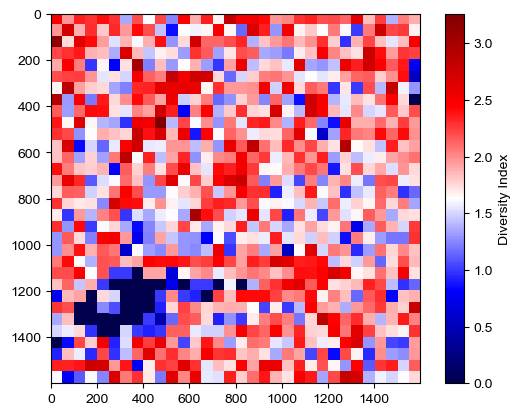

In [41]:
test_sample = 'N7'
patches_coordinates = msd.generate_patches(liver_df,
                                           'sample',
                                           test_sample,
                                           scaling_factor=32.,
                                           spatial_key=['x_slide_um', 'y_slide_um'])

patch_indices, patches_comp = msd.calculate_diversity_index(spatial_data=liver_df, 
                                                            library_key='sample', 
                                                            library_id=test_sample, 
                                                            spatial_key=['x_slide_um', 'y_slide_um'], 
                                                            patches=patches_coordinates, 
                                                            cluster_key=cluster_key, 
                                                            metric='Shannon Diversity', return_comp=True)


# Visualize the heterogeneity indices
grid, heatmap_fig = msd.diversity_heatmap(spatial_data=liver_df,
                                          library_key='sample', 
                                          library_id=test_sample,
                                          spatial_key=['x_slide_um', 'y_slide_um'],
                                          patches=patches_coordinates, 
                                          heterogeneity_indices=patch_indices,
                                          tissue_only=True,
                                          plot=True,
                                          return_fig=True)

In [92]:
save_path = cluster_key + '_' + test_sample + '_heatmap.svg'
heatmap_fig.savefig('../figures/liver/'+save_path)
save_path = cluster_key + '_' + test_sample + '_heatmap.jpeg'
heatmap_fig.savefig('../figures/liver/'+save_path)
plt.close(heatmap_fig)

In [17]:
print(msd.global_moran(grid, tissue_only=True))
# Normal restrict to tissue region (0.22979407781898203, 0.001)
# Cancerous restrict to tissue region (0.5615765738985597, 0.001)
# There are 5 disconnected components.
# There are 3 islands with ids: 367, 3135, 4031.

Global Moran restricted to tissue region with w of shape(1004, 1004)
(0.09882209548413516, 0.001)


In [42]:
hotspots, coldspots, doughnuts, diamonds = msd.local_moran(grid,tissue_only=True,p_value=0.01,plot_weights=False)
print(sum(hotspots.flatten()), flush=True)
print(sum(coldspots.flatten()), flush=True)
print(sum(doughnuts.flatten()), flush=True)
print(sum(diamonds.flatten()), flush=True)

(1004,)
Local Moran restricted to tissue region with w of shape(1004, 1004)
26
21
9
17


In [43]:
combined_spots = (hotspots * 1) + (coldspots * -1) #+ (doughnuts * 0.5) + (diamonds * -0.5)
seismic = plt.cm.seismic
colors = [seismic(0), "lightblue", "white", "salmon", seismic(0.999)]
cmap = mcolors.LinearSegmentedColormap.from_list("custom_map", colors)

1599.0 1599.0


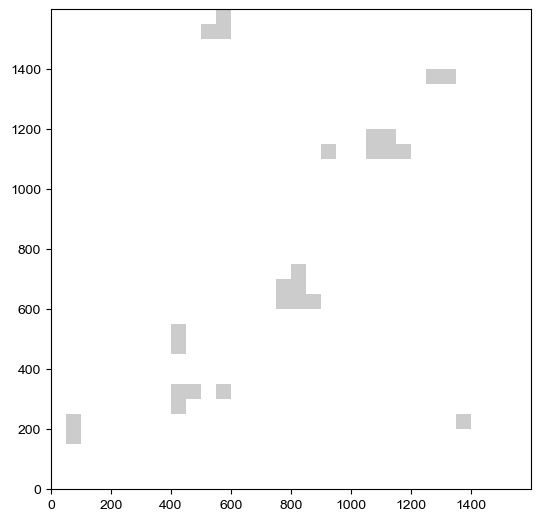

In [44]:
patch_sample_df = liver_df.loc[(liver_df['sample'] == test_sample),:].copy()
x_coords = patch_sample_df['x_slide_um']
y_coords = patch_sample_df['y_slide_um']
min_x, min_y = np.min(x_coords), np.min(y_coords)
max_x, max_y = np.max(x_coords), np.max(y_coords)
width = max_x - min_x
height = max_y - min_y
print(width, height)
w, h = figaspect(height/width)

spot_fig = plt.figure(figsize=(w, h))
ax = spot_fig.add_axes([0, 0, 1, 1])

# Create a 2D grid
grid = np.zeros((int(max_y - min_y + 1), int(max_x - min_x + 1)))

# Fill the grid with heterogeneity indices
for patch, diversity_index in enumerate(combined_spots.flatten()):
    x0, y0, x1, y1 = patches_coordinates[patch]
    grid[int(y0-min_y):int(y1-min_y+1), int(x0-min_x):int(x1-min_x+1)] = diversity_index

# Plot the heatmap
# ax.imshow(grid, cmap=cmap, interpolation='none', vmin=-1, vmax=1)
ax.imshow(grid, cmap='Greys', interpolation='none', vmin=0, vmax=1, alpha=0.1)
# Invert the y-axis
ax.invert_yaxis()

# save_path = test_sample + '_spot.svg'
# spot_fig.savefig('../figures/liver/'+save_path, dpi=300)
# save_path = test_sample + '_spot.jpeg'
# spot_fig.savefig('../figures/liver/'+save_path, dpi=300)

In [50]:
print(msd.compute_proximity_index(hotspots))

12 islands identified
65.28986283848344


In [132]:
if Hot:
    filtered_patches_coordinates = [patch for patch, is_hotspot in zip(patches_coordinates, hotspots.flatten()) if is_hotspot]
    filtered_patches_comp = [patch for patch, is_hotspot in zip(patches_comp, hotspots.flatten()) if is_hotspot]
else:
    filtered_patches_coordinates = [patch for patch, is_coldspot in zip(patches_coordinates, coldspots.flatten()) if is_coldspot]
    filtered_patches_comp = [patch for patch, is_coldspot in zip(patches_comp, coldspots.flatten()) if is_coldspot]

In [123]:
merged_series = pd.concat(filtered_patches_comp, axis=1).sum(axis=1)
merged_series

cellType
tumor_2                          42.0
tumor_1                         290.0
Periportal.LSECs                 31.0
Stellate.cells                   91.0
CD3+.alpha.beta.T.cells         184.0
Inflammatory.macrophages        206.0
Non.inflammatory.macrophages     53.0
NK.like.cells                     6.0
Central.venous.LSECs             14.0
Mature.B.cells                   39.0
gamma.delta.T.cells.1             3.0
Portal.endothelial.cells          2.0
Cholangiocytes                    1.0
dtype: float64

In [87]:
# Convert the series to a dataframe
spot_df = merged_series.reset_index()
spot_df.columns = ['cellType', 'count']
spot_df['Run_Tissue_name'] = test_sample
# Calculate total and frequency
spot_df['total'] = spot_df['count'].sum()
spot_df['Frequency'] = spot_df['count'] / spot_df['total']

spot_df

cellType  count Run_Tissue_name  total  Frequency
0                     tumor_1   81.0              C1  210.0   0.385714
1     CD3+.alpha.beta.T.cells   10.0              C1  210.0   0.047619
2            Periportal.LSECs   11.0              C1  210.0   0.052381
3                     tumor_2   85.0              C1  210.0   0.404762
4              Mature.B.cells    5.0              C1  210.0   0.023810
5              Stellate.cells    2.0              C1  210.0   0.009524
6  Antibody.secreting.B.cells    5.0              C1  210.0   0.023810
7    Inflammatory.macrophages    9.0              C1  210.0   0.042857
8       gamma.delta.T.cells.1    2.0              C1  210.0   0.009524

In [26]:
from matplotlib.patches import Rectangle

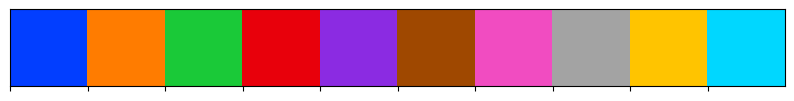

In [133]:
cell_types_visual = ['Inflammatory.macrophages', 'Non.inflammatory.macrophages']
marker_dict = {
    cell_types_visual[0]: 'X',
    cell_types_visual[1]: '^'
}
custom_colors = sns.color_palette("bright")
sns.palplot(custom_colors)

color_dict = {
    cell_types_visual[0]: custom_colors[-1],
    cell_types_visual[1]: custom_colors[-5]
}

1599.0
1599.0


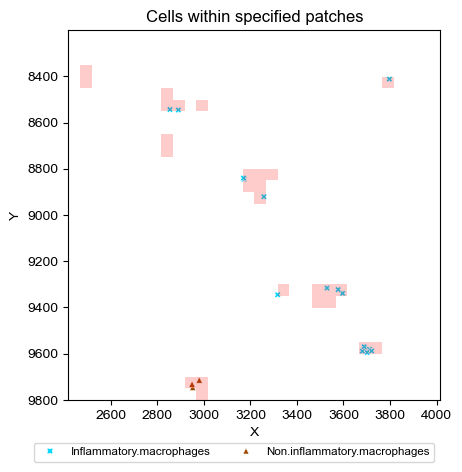

In [134]:
co_loc_fig = msd.plot_cells_patches(spatial_data=liver_df, 
                                    library_key='sample',
                                    library_id=test_sample,
                                    spatial_key=['x_slide_um', 'y_slide_um'],
                                    cluster_key='cellType',
                                    patches=filtered_patches_coordinates,
                                    selected_cell_types=cell_types_visual,
                                    marker_styles=marker_dict,
                                    color_palette=color_dict,
                                    patch_alpha=0.2)
save_path = test_sample + cell_types_visual[0] + '_' + cell_types_visual[1] +'_coloc.svg'
co_loc_fig.savefig('../figures/liver/'+save_path, dpi=300)
save_path = save_path.replace('.svg','.png')
co_loc_fig.savefig('../figures/liver/'+save_path, dpi=300)

# Global Cell-type Frequency

In [52]:
cluster_key = 'cellType'    

In [53]:
count_df = liver_df.groupby(['Run_Tissue_name', cluster_key]).size().reset_index(name='count')
total_cells_in_region = liver_df.groupby('Run_Tissue_name').size().reset_index(name='total')

# Merge the two dataframes on the 'File Name' column
merged_df = pd.merge(count_df, total_cells_in_region, on='Run_Tissue_name')

# Compute the proportion for each cell type in each region
merged_df['Frequency'] = merged_df['count'] / merged_df['total']

# Getting unique values for combinations
unique_files = liver_df['Run_Tissue_name'].unique()
unique_clusters = liver_df[cluster_key].unique()

# Create a DataFrame from all combinations of the unique values for File Name and ClusterName
all_combinations = pd.DataFrame(pd.MultiIndex.from_product([unique_files, unique_clusters], 
                                                          names=['Run_Tissue_name', cluster_key]).tolist(), columns=['Run_Tissue_name', cluster_key])

# Merge the created DataFrame with merged_df, filling in missing values
proportion_df = pd.merge(all_combinations, merged_df, on=['Run_Tissue_name', cluster_key], how='left')
proportion_df['Frequency'].fillna(0, inplace=True)

proportion_df

Run_Tissue_name                      cellType     count     total  \
0      NormalLiver                         Hep.3   21274.0  332877.0   
1      NormalLiver                         Hep.4  125997.0  332877.0   
2      NormalLiver      Inflammatory.macrophages    5882.0  332877.0   
3      NormalLiver                         Hep.5   89334.0  332877.0   
4      NormalLiver          Central.venous.LSECs    4416.0  332877.0   
5      NormalLiver       CD3+.alpha.beta.T.cells   13664.0  332877.0   
6      NormalLiver                 NK.like.cells    2752.0  332877.0   
7      NormalLiver         gamma.delta.T.cells.1    3181.0  332877.0   
8      NormalLiver                Stellate.cells   16482.0  332877.0   
9      NormalLiver  Non.inflammatory.macrophages    9556.0  332877.0   
10     NormalLiver                         Hep.1   17364.0  332877.0   
11     NormalLiver               Erthyroid.cells    1044.0  332877.0   
12     NormalLiver                Mature.B.cells    2928.0  332877.0   
13     NormalLiver      Portal.endothelial.cells     537.0  332877.0   
14     NormalLiver              Periportal.LSECs    6083.0  332877.0   
15     NormalLiver                Cholangiocytes    4783.0  332877.0   
16     NormalLiver                         Hep.6    6183.0  332877.0   
17     NormalLiver    Antibody.secreting.B.cells    1413.0  332877.0   
18     NormalLiver                       tumor_2       NaN       NaN   
19     NormalLiver                       tumor_1       NaN       NaN   
20     NormalLiver                           Hep       NaN       NaN   
21     NormalLiver                        NotDet       4.0  332877.0   
22  CancerousLiver                         Hep.3       NaN       NaN   
23  CancerousLiver                         Hep.4       NaN       NaN   
24  CancerousLiver      Inflammatory.macrophages   14797.0  460441.0   
25  CancerousLiver                         Hep.5       NaN       NaN   
26  CancerousLiver          Central.venous.LSECs    2138.0  460441.0   
27  CancerousLiver       CD3+.alpha.beta.T.cells   20083.0  460441.0   
28  CancerousLiver                 NK.like.cells     705.0  460441.0   
29  CancerousLiver         gamma.delta.T.cells.1     549.0  460441.0   
30  CancerousLiver                Stellate.cells    7798.0  460441.0   
31  CancerousLiver  Non.inflammatory.macrophages    9076.0  460441.0   
32  CancerousLiver                         Hep.1       NaN       NaN   
33  CancerousLiver               Erthyroid.cells     139.0  460441.0   
34  CancerousLiver                Mature.B.cells    4974.0  460441.0   
35  CancerousLiver      Portal.endothelial.cells    1060.0  460441.0   
36  CancerousLiver              Periportal.LSECs   11893.0  460441.0   
37  CancerousLiver                Cholangiocytes    1411.0  460441.0   
38  CancerousLiver                         Hep.6       NaN       NaN   
39  CancerousLiver    Antibody.secreting.B.cells    1236.0  460441.0   
40  CancerousLiver                       tumor_2   35385.0  460441.0   
41  CancerousLiver                       tumor_1  347988.0  460441.0   
42  CancerousLiver                           Hep    1204.0  460441.0   
43  CancerousLiver                        NotDet       5.0  460441.0   

    Frequency  
0    0.063909  
1    0.378509  
2    0.017670  
3    0.268369  
4    0.013266  
5    0.041048  
6    0.008267  
7    0.009556  
8    0.049514  
9    0.028707  
10   0.052163  
11   0.003136  
12   0.008796  
13   0.001613  
14   0.018274  
15   0.014369  
16   0.018574  
17   0.004245  
18   0.000000  
19   0.000000  
20   0.000000  
21   0.000012  
22   0.000000  
23   0.000000  
24   0.032137  
25   0.000000  
26   0.004643  
27   0.043617  
28   0.001531  
29   0.001192  
30   0.016936  
31   0.019712  
32   0.000000  
33   0.000302  
34   0.010803  
35   0.002302  
36   0.025830  
37   0.003064  
38   0.000000  
39   0.002684  
40   0.076850  
41   0.755771  
42   0.002615  
43   0.000011

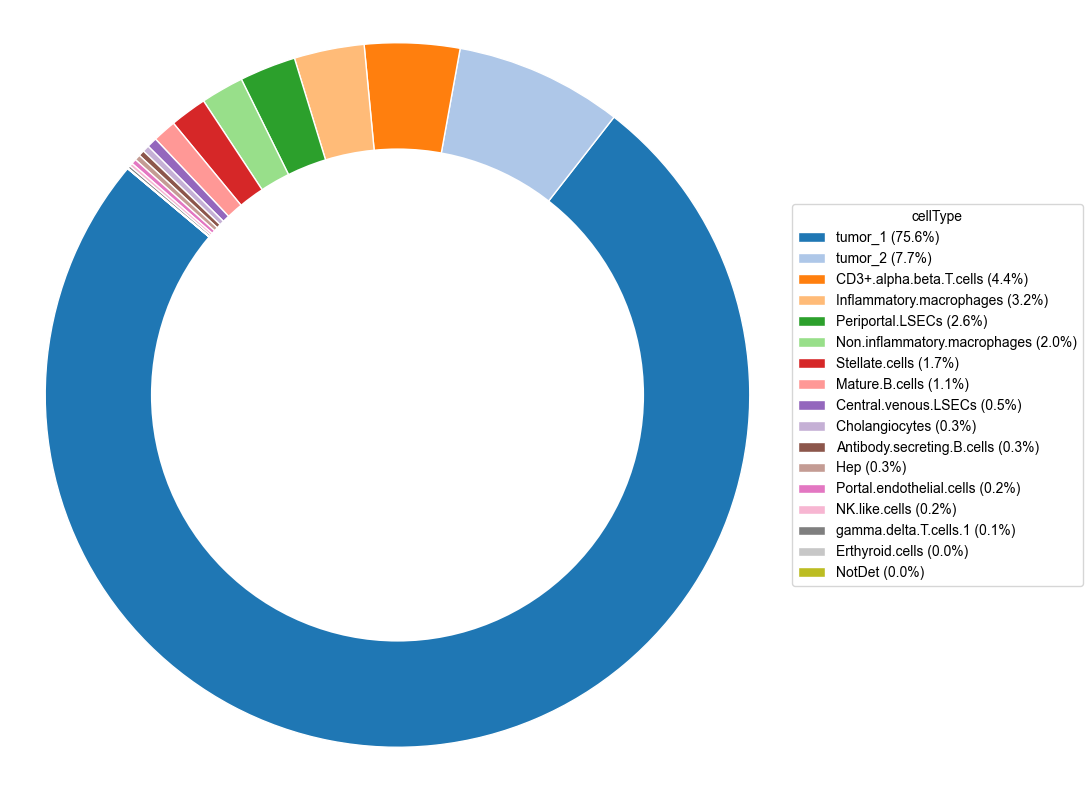

In [22]:
save_path = test_sample+ 'tissue_' + cluster_key.split(' ')[0] + '_freq.svg'
selected_cell_types = sorted(proportion_df[cluster_key].unique())

# Filter data for selected cell types and non-zero frequencies
filtered_data = proportion_df[
    (proportion_df['Run_Tissue_name'] == test_sample) &
    proportion_df[cluster_key].isin(selected_cell_types) &
    (proportion_df['Frequency'] > 0)  # Removing zero frequencies
]

# Sort the filtered data by Frequency in descending order for a more organized pie chart
filtered_data = filtered_data.sort_values(by='Frequency', ascending=False)

# Create a color palette suitable for distinguishing different classes
palette = sns.color_palette("tab20", n_colors=len(filtered_data))  # Adjusting palette size to match data

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
fig, ax = plt.subplots(figsize=(10, 10))
wedges, texts = ax.pie(
    filtered_data['Frequency'],
    labels=None,
    startangle=140,
    colors=palette,
    wedgeprops=dict(edgecolor='w'),
    autopct=None  # Omitting automatic percentage calculation
)

# Draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')  

# Prepare labels for the legend with percentages
legend_labels = [
    f"{ctype} ({freq*100:.1f}%)" for ctype, freq in zip(filtered_data[cluster_key], filtered_data['Frequency'])
    # Multiplying by 100 to convert proportions to percentages for display
]

# Add legend
ax.legend(
    wedges,
    legend_labels,
    title=cluster_key,
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

ax.set_xlabel('')
fig.savefig('../figures/liver/'+save_path, bbox_inches="tight")
save_path = test_sample+ 'tissue_' + cluster_key.split(' ')[0] + '_freq.jpeg'
fig.savefig('../figures/liver/'+save_path, bbox_inches="tight")
plt.show()
plt.close(fig)


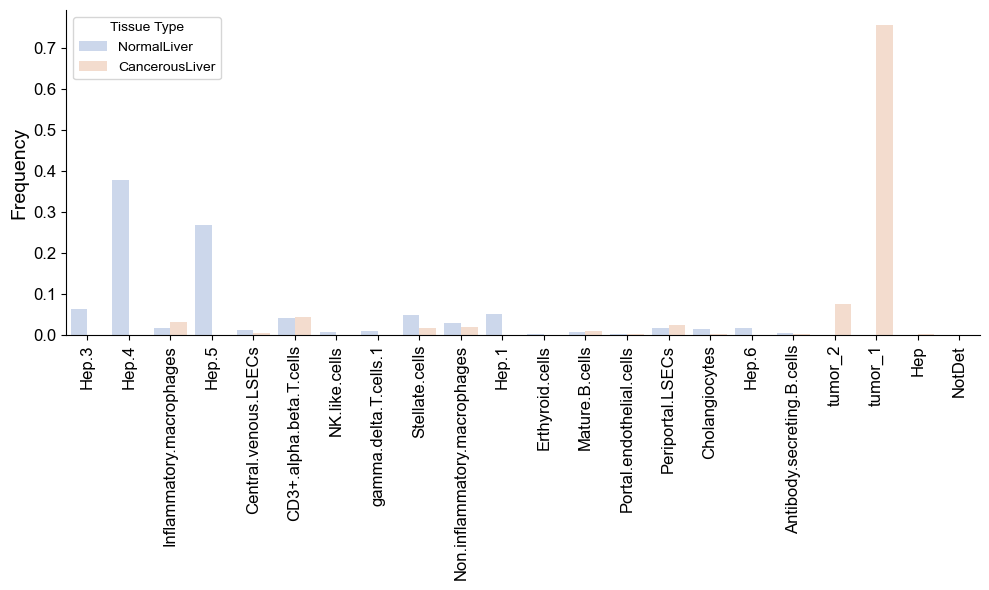

In [56]:
plt.figure(figsize=(10, 6))

# Create a barplot
ax = sns.barplot(x='cellType', y='Frequency', hue='Run_Tissue_name', palette='muted', data=proportion_df, errorbar=None)

# Set alpha for each bar in the plot
for bar in ax.patches:
    bar.set_alpha(0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('')
plt.ylabel('Frequency', fontsize=14)
# plt.title('Frequency of Cell Types in Normal and Cancerous Liver')
plt.xticks(rotation=90, fontsize=12) 
plt.yticks(rotation=0, fontsize=12) 

# Add legend
plt.legend(title='Tissue Type')

# Show the plot
plt.tight_layout()
plt.savefig('../figures/liver/all_composition_wholetissue_liver.svg')
plt.show()

# Calculate Multi-Scale Diversity Index

In [40]:
scales = [1., 2., 4., 8., 16., 32., 64.]
library_names = ['Healthy', 'Cancerous'] 
library_ids = ['NormalLiver', 'CancerousLiver']
df_entropy, df_slopes = msd.multiscale_diversity(spatial_data=liver_df,
                                                 scales=scales,
                                                 library_key='Run_Tissue_name',
                                                 library_ids=library_ids,
                                                 spatial_key=['x_slide_um', 'y_slide_um'],
                                                 cluster_key='cellType',
                                                 random_patch=False,
                                                 plotfigs=False,
                                                 savefigs=False,
                                                 patch_kwargs={'random_seed': None, 'min_points':2},
                                                 other_kwargs={'metric': 'Shannon Diversity'})

Processing region: NormalLiver at scale 1.0
0.000 per cent patches are empty
NormalLiver at scale 1.0 has 0 patches with zero diveristy
NormalLiver at scale 1.0 diversity is 2.8084451552635397
Processing region: CancerousLiver at scale 1.0
0.000 per cent patches are empty
CancerousLiver at scale 1.0 has 0 patches with zero diveristy
CancerousLiver at scale 1.0 diversity is 1.5211326944972803
Processing region: NormalLiver at scale 2.0
0.000 per cent patches are empty
NormalLiver at scale 2.0 has 0 patches with zero diveristy
NormalLiver at scale 2.0 diversity is 2.801670896957635
Processing region: CancerousLiver at scale 2.0
0.000 per cent patches are empty
CancerousLiver at scale 2.0 has 0 patches with zero diveristy
CancerousLiver at scale 2.0 diversity is 1.4464550626119985
Processing region: NormalLiver at scale 4.0
0.000 per cent patches are empty
NormalLiver at scale 4.0 has 0 patches with zero diveristy
NormalLiver at scale 4.0 diversity is 2.789564759218704
Processing region: 

In [41]:
df_results = pd.concat([df_entropy.transpose(), df_slopes.transpose()], axis=1)
df_results=df_results.rename(columns={0.0: 'Slope'})
df_results['Condition'] = ' '
df_results['Sample_id'] = df_results.index
df_results.loc[df_results.index.str.contains('Normal'), 'Condition'] = 'Normal'
df_results.loc[df_results.index.str.contains('Cancerous'), 'Condition'] = 'Cancerous'
# for col in df_results.columns[:-2]:  # Exclude 'Slope' and 'Condition'
#     df_results[f'Avg_{col}'] = df_results.groupby('Condition')[col].transform('mean')
df_results

1.0       2.0       4.0       8.0      16.0      32.0  \
NormalLiver     2.808445  2.801671  2.789565  2.739303  2.633693  2.503561   
CancerousLiver  1.521133  1.446455  1.492779  1.426331   1.35664  1.256916   

                    64.0     128.0     Slope  Condition       Sample_id  
NormalLiver     2.330671  2.025879  0.104721     Normal     NormalLiver  
CancerousLiver  1.141815  0.941052  0.075727  Cancerous  CancerousLiver

# Hot/Cold Spot Cellular Analysis

In [40]:
cluster_key = 'cellType' 

## Calculation

In [49]:
Hot = False
library_names = ['Healthy', 'Cancerous'] 
library_ids = [['NormalLiver'], ['CancerousLiver']]

comp_results = []
comb_freq_results = []


for library, library_name in zip(library_ids, library_names):
    total_comp_dict, global_morans, spot_comb_dict = msd.diversity_clustering(spatial_data=liver_df, 
                                                                              scale=64.0, 
                                                                              library_key='Run_Tissue_name',
                                                                              library_ids=library, 
                                                                              spatial_key=['x_slide_mm', 'y_slide_mm'],
                                                                              cluster_key=cluster_key,
                                                                              hotspot=Hot,
                                                                              top=20,
                                                                              selected_comb=None,
                                                                              restricted=True,
                                                                              metric='Shannon Diversity')

    # Concatenate all the merged_series and sum across rows
    comp_results.append(total_comp_dict)
    comb_freq_results.append(spot_comb_dict)
    

Processing region: NormalLiver at scale 64.0
13.403 per cent patches are empty
Global Moran restricted to tissue region with w of shape(3547, 3547)


/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There are 3 islands with ids: 367, 3135, 4031.
  warnings.warn(message)


(3547,)
Local Moran restricted to tissue region with w of shape(3547, 3547)
Region NormalLiver contains 132 diversity coldspots
Considering only hotspots
Processing region: CancerousLiver at scale 64.0
29.297 per cent patches are empty
Global Moran restricted to tissue region with w of shape(2896, 2896)
(2896,)
Local Moran restricted to tissue region with w of shape(2896, 2896)
Region CancerousLiver contains 257 diversity coldspots
Considering only hotspots


## process and visualise cell frequency

In [50]:
# Creating an empty DataFrame with the desired columns
comp_results_df = pd.DataFrame(columns=['Run_Tissue_name', cluster_key, 'count'])
for d in comp_results:
    for key, series in d.items():
        temp_df = pd.DataFrame({
            'Run_Tissue_name': key,
            cluster_key: series.index,
            'count': series.values
        })
        comp_results_df = pd.concat([comp_results_df, temp_df], ignore_index=True)

unique_tissues = comp_results_df['Run_Tissue_name'].unique()
unique_cellTypes = comp_results_df[cluster_key].unique()
all_combinations = pd.DataFrame(pd.MultiIndex.from_product([unique_tissues, unique_cellTypes], 
                                                           names=['Run_Tissue_name', cluster_key]).tolist(), columns=['Run_Tissue_name', cluster_key])

# Merge the created DataFrame with comp_results_df, filling in missing values
complete_comp_results_df = pd.merge(all_combinations, comp_results_df, on=['Run_Tissue_name', cluster_key], how='left')
complete_comp_results_df['count'].fillna(0, inplace=True)

# Calculate total for each Run_Tissue_name group
complete_comp_results_df['total'] = complete_comp_results_df.groupby('Run_Tissue_name')['count'].transform('sum')

# Calculate frequency
complete_comp_results_df['Frequency'] = complete_comp_results_df['count'] / complete_comp_results_df['total']

print(complete_comp_results_df)

   Run_Tissue_name                      cellType    count    total  Frequency
0      NormalLiver       CD3+.alpha.beta.T.cells    199.0   1962.0   0.101427
1      NormalLiver                         Hep.4   1002.0   1962.0   0.510703
2      NormalLiver                         Hep.5    374.0   1962.0   0.190622
3      NormalLiver                Mature.B.cells     37.0   1962.0   0.018858
4      NormalLiver  Non.inflammatory.macrophages     38.0   1962.0   0.019368
5      NormalLiver                 NK.like.cells     36.0   1962.0   0.018349
6      NormalLiver          Central.venous.LSECs     16.0   1962.0   0.008155
7      NormalLiver         gamma.delta.T.cells.1     25.0   1962.0   0.012742
8      NormalLiver                         Hep.1     58.0   1962.0   0.029562
9      NormalLiver                         Hep.3     89.0   1962.0   0.045362
10     NormalLiver      Inflammatory.macrophages     24.0   1962.0   0.012232
11     NormalLiver                Stellate.cells     43.0   1962

/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_20225/1813938479.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  comp_results_df = pd.concat([comp_results_df, temp_df], ignore_index=True)


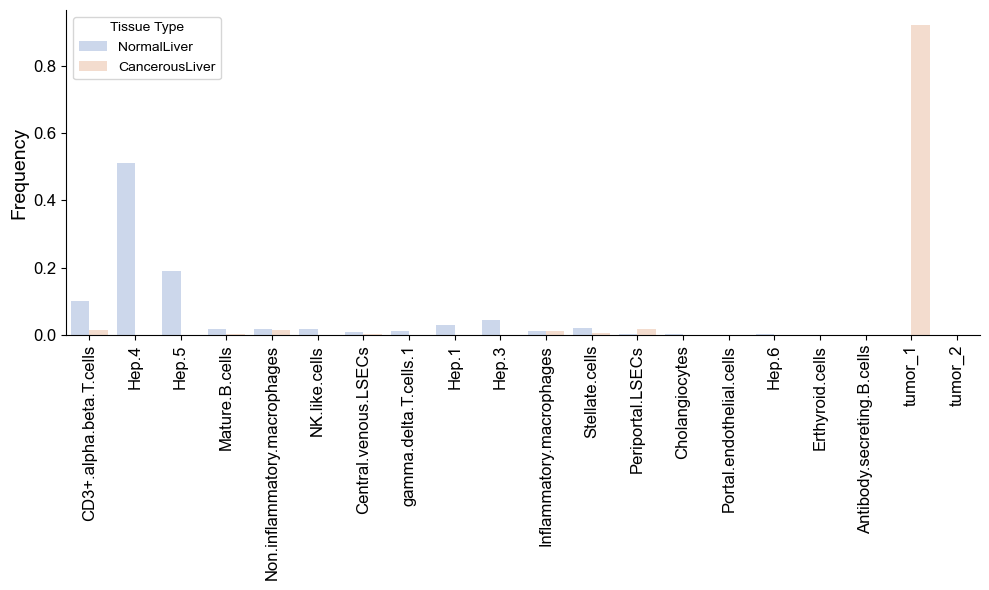

In [51]:
plt.figure(figsize=(10, 6))

# Create a barplot
ax = sns.barplot(x=cluster_key, y='Frequency', hue='Run_Tissue_name', palette='muted', data=complete_comp_results_df, errorbar=None)

# Set alpha for each bar in the plot
for bar in ax.patches:
    bar.set_alpha(0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('')
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=90, fontsize=12) 
plt.yticks(rotation=0, fontsize=12) 

# Add legend
plt.legend(title='Tissue Type')

# Show the plot
plt.tight_layout()
if Hot:
    plt.savefig('../figures/liver/hotspots_composition_wholetissue_liver.svg')
else:
    plt.savefig('../figures/liver/coldspots_composition_wholetissue_liver.svg')
plt.show()

## process and visualise cell co-occurence

In [60]:
comb_freq_results

[{'NormalLiver': CD3+.alpha.beta.T.cells       Stellate.cells                  0.971698
                                Hep.3                           0.952830
  Hep.3                         Stellate.cells                  0.924528
                                Hep.5                           0.905660
                                Hep.4                           0.905660
  CD3+.alpha.beta.T.cells       Hep.5                           0.905660
                                Hep.4                           0.905660
  Hep.5                         Stellate.cells                  0.886792
  Hep.4                         Stellate.cells                  0.886792
                                Hep.5                           0.877358
  CD3+.alpha.beta.T.cells       Inflammatory.macrophages        0.867925
  Inflammatory.macrophages      Stellate.cells                  0.839623
  Hep.3                         Inflammatory.macrophages        0.820755
  Hep.5                         Infl

# Subsampling Analysis

## Global Cell-Type Frequency Analysis

In [16]:
selected_cell_types = sorted(liver_df['cellType'].unique())
filtered_df = liver_df[liver_df['cellType'].isin(selected_cell_types)]

# Compute cell type frequencies for each sample
global_cell_count = filtered_df.groupby(['sample', 'cellType']).size().unstack(fill_value=0)
grouped_freq = global_cell_count.div(global_cell_count.sum(axis=1), axis=0)

# Add the group info back to this normalized dataframe
grouped_freq['Condition'] = [ 'NormalLiver' if 'N' in name else 'CancerousLiver' for name in grouped_freq.index]

# Melt the dataframe for easier plotting and statistical analysis
global_freq = grouped_freq.reset_index().melt(id_vars=['sample', 'Condition'], value_vars=selected_cell_types)
global_freq.columns = ['sample', 'Condition', 'cellType', 'Frequency']
global_freq = global_freq[global_freq['sample'] != '-1'].sort_values(by='Condition', ascending=False)
global_freq

sample       Condition                  cellType  Frequency
461     N9     NormalLiver                   tumor_2   0.000000
200     N0     NormalLiver                     Hep.5   0.273841
370     N2     NormalLiver  Portal.endothelial.cells   0.001372
369     N1     NormalLiver  Portal.endothelial.cells   0.001372
179     N0     NormalLiver                     Hep.4   0.308040
..     ...             ...                       ...        ...
199     C9  CancerousLiver                     Hep.5   0.000000
198     C8  CancerousLiver                     Hep.5   0.000000
197     C7  CancerousLiver                     Hep.5   0.000000
196     C6  CancerousLiver                     Hep.5   0.000000
232     C0  CancerousLiver  Inflammatory.macrophages   0.013729

[440 rows x 4 columns]

In [47]:
grouped_freq['sample'] = grouped_freq.index
grouped_freq = grouped_freq[grouped_freq['sample']!='-1']
grouped_freq = grouped_freq.drop(columns='NotDet')

Antibody.secreting.B.cells has p value of 0.7253105069107636
CD3+.alpha.beta.T.cells has p value of 0.6688961489467853
Central.venous.LSECs has p value of 1.3650725054199515e-09
Cholangiocytes has p value of 5.184474315672871e-05
Erthyroid.cells has p value of 1.9625773981187326e-08
Hep has p value of 0.3128233608731258
Hep.1 has p value of 1.4655635733085782e-05
Hep.3 has p value of 2.517630979080062e-10
Hep.4 has p value of 5.087963668099555e-10
Hep.5 has p value of 3.9066463036613865e-11
Hep.6 has p value of 2.0930984873598823e-06
Inflammatory.macrophages has p value of 0.14611237799276483
Mature.B.cells has p value of 0.5028132228052371
NK.like.cells has p value of 3.713895255795975e-07
Non.inflammatory.macrophages has p value of 0.3171705903870426
NotDet has p value of 0.9868237859133563
Periportal.LSECs has p value of 0.37928617391074426
Portal.endothelial.cells has p value of 0.04245411617382956
Stellate.cells has p value of 0.0038202017195151047
gamma.delta.T.cells.1 has p valu

/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_62453/982780121.py:17: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(data=global_freq, x='cellType', y='Frequency', hue='Condition', palette='dark:black', size=2.0, dodge=True, order=selected_cell_types, ax=ax, edgecolor='gray', linewidth=0.5)


Antibody.secreting.B.cells has p value = 0.760
CD3+.alpha.beta.T.cells has p value = 0.736
Central.venous.LSECs has p value = 0.000
Cholangiocytes has p value = 0.000
Erthyroid.cells has p value = 0.000
Hep has p value = 0.410
Hep.1 has p value = 0.000
Hep.3 has p value = 0.000
Hep.4 has p value = 0.000
Hep.5 has p value = 0.000
Hep.6 has p value = 0.000
Inflammatory.macrophages has p value = 0.214
Mature.B.cells has p value = 0.582
NK.like.cells has p value = 0.000
Non.inflammatory.macrophages has p value = 0.410
NotDet has p value = 0.987
Periportal.LSECs has p value = 0.464
Portal.endothelial.cells has p value = 0.067
Stellate.cells has p value = 0.006
gamma.delta.T.cells.1 has p value = 0.000
tumor_1 has p value = 0.000
tumor_2 has p value = 0.004


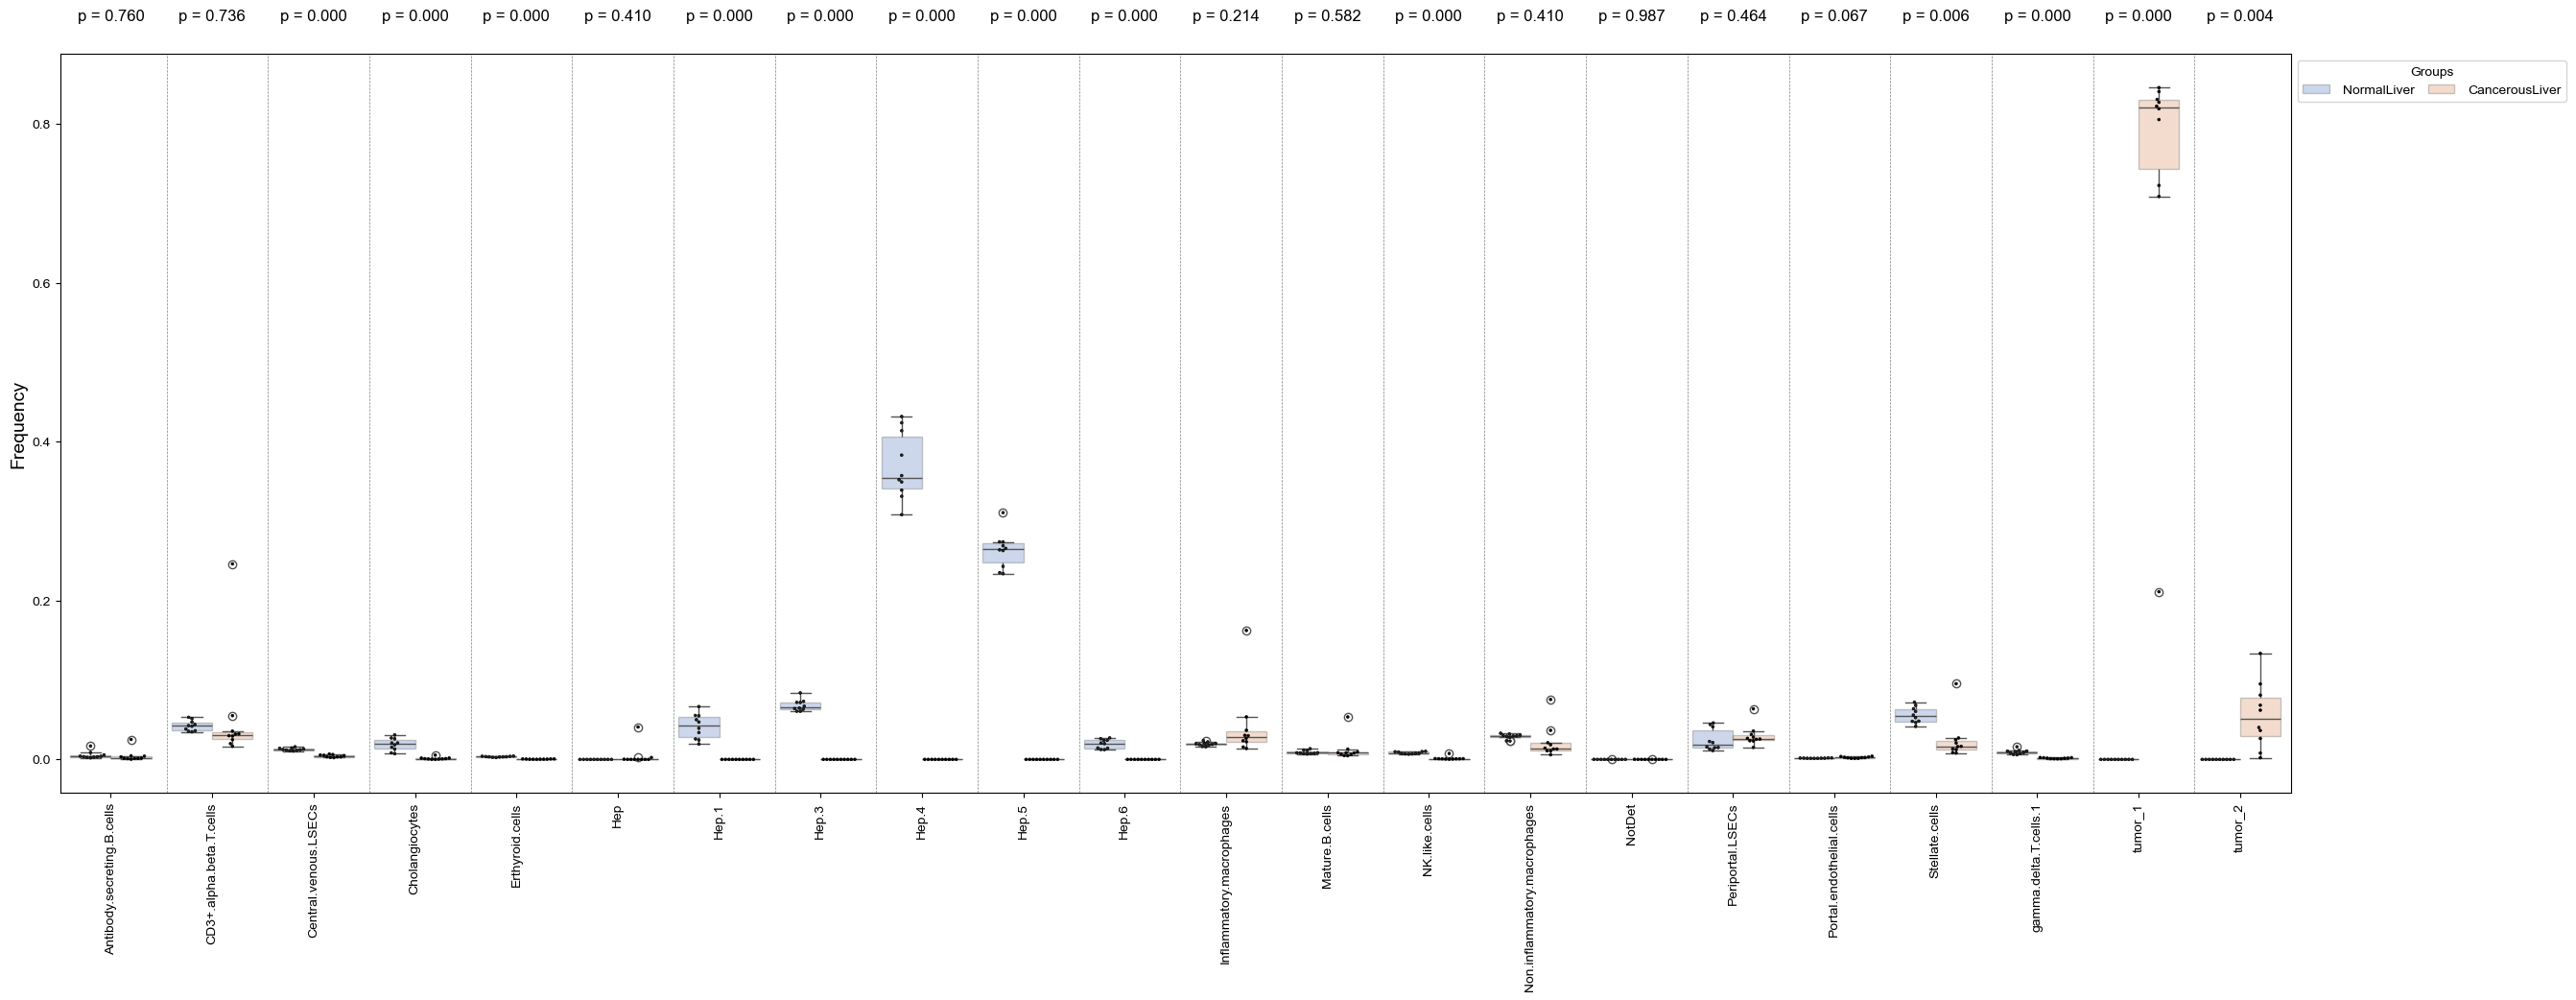

In [45]:
# Perform t-tests
selected_p_values = []
for ct in selected_cell_types:
    group1 = global_freq[(global_freq['cellType'] == ct) & (global_freq['Condition'] == 'NormalLiver')]['Frequency']
    group2 = global_freq[(global_freq['cellType'] == ct) & (global_freq['Condition'] == 'CancerousLiver')]['Frequency']
    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
    print(f"{ct} has p value of {p_value}")
    selected_p_values.append(p_value)

pvals_corrected = stats.false_discovery_control(selected_p_values, method='bh')
print('-'*42)
print(f"p-values after correction:")

# Plot
fig, ax = plt.subplots(figsize=(30,10))
sns.boxplot(data=global_freq, x='cellType', y='Frequency', hue='Condition', palette='muted', boxprops=dict(alpha=.3), ax=ax, dodge=True, order=selected_cell_types)
sns.swarmplot(data=global_freq, x='cellType', y='Frequency', hue='Condition', palette='dark:black', size=2.0, dodge=True, order=selected_cell_types, ax=ax, edgecolor='gray', linewidth=0.5)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)
plt.xticks(rotation=90)

p_vals_corrected_dict = {}
yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
for i, ct in enumerate(selected_cell_types):
    ax.text(i, yrange, f"p = {pvals_corrected[i]:.3f}", ha='center', fontsize=12, rotation=0)
    print(f"{ct} has p value = {pvals_corrected[i]:.3f}", flush=True)
    p_vals_corrected_dict[ct] = pvals_corrected[i]
    
for i in range(len(selected_cell_types) - 1):
    ax.axvline(i + 0.55, color='grey', linestyle='--', linewidth=0.5)
    
    
ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel('') 

save_path = 'global_celltype_freq.svg'
plt.savefig('../figures/liver/'+save_path)
plt.show()


## Global Cell-Comb Frequency

In [14]:
Hot = True
cluster_key = 'cellType' 

library_names = ['NormalLiver', 'CancerousLiver'] 
library_ids = pd.unique(liver_df['sample'])
library_ids = [
    [l for l in library_ids if 'N' in l],
    [l for l in library_ids if 'C' in l]
]
print(library_ids)
total_merged_series = []

comp_results_mice = []
moran_results = []

comb_freq_results = []
comb_freq_results_mice = []

for library, library_name in zip(library_ids, library_names):
    total_comp_dict, global_morans, spot_comb_dict = msd.diversity_clustering(spatial_data=liver_df, 
                                                                              scale=32.0, 
                                                                              library_key='sample',
                                                                              library_ids=library, 
                                                                              spatial_key=['x_slide_um', 'y_slide_um'],
                                                                              cluster_key=cluster_key,
                                                                              hotspot=Hot,
                                                                              whole_tissue=True,
                                                                              top=None,
                                                                              selected_comb=None,
                                                                              restricted=True,
                                                                              metric='Shannon Diversity')

    # Concatenate all the merged_series and sum across rows
    total_merged_series.append(total_comp_dict)
    comb_freq_results.append(spot_comb_dict)
    
    # Store Moran's I 
    moran_results.append(global_morans)
    
    # Calculate cell-type/combination freq in hotspots
    comp_mice = pd.DataFrame()
    comb_mice = pd.DataFrame()
    
    for key in total_comp_dict.keys():
        comp_mice = append_series_to_df(comp_mice, (total_comp_dict[key]/total_comp_dict[key].sum(axis=0)), key)
        comb_mice = append_series_to_df(comb_mice, spot_comb_dict[key], key)
        
    comp_mice = comp_mice.T    
    comp_mice['Condition'] = library_name 
    comp_results_mice.append(comp_mice.fillna(0))
    
    comb_mice = comb_mice.T
    comb_mice['Condition'] = library_name
    comb_freq_results_mice.append(comb_mice.fillna(0))

[['N1', 'N7', 'N9', 'N6', 'N8', 'N2', 'N4', 'N5', 'N0', 'N3'], ['C4', 'C0', 'C1', 'C5', 'C6', 'C7', 'C9', 'C2', 'C3', 'C8']]
Processing region: N1 at scale 32.0
1.465 per cent patches are empty
Global Moran restricted to tissue region with w of shape(1009, 1009)
(1009,)
Local Moran restricted to tissue region with w of shape(1009, 1009)
Region N1 contains 6 diversity hotspots
Considering whole tissue
Processing region: N7 at scale 32.0
1.953 per cent patches are empty
Global Moran restricted to tissue region with w of shape(1004, 1004)
(1004,)
Local Moran restricted to tissue region with w of shape(1004, 1004)
Region N7 contains 26 diversity hotspots
Considering whole tissue
Processing region: N9 at scale 32.0
0.000 per cent patches are empty
Global Moran restricted to tissue region with w of shape(1024, 1024)
(1024,)
Local Moran restricted to tissue region with w of shape(1024, 1024)
Region N9 contains 13 diversity hotspots
Considering whole tissue
Processing region: N6 at scale 32.0


/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 46.
  warnings.warn(message)


Processing region: C8 at scale 32.0
6.348 per cent patches are empty
Global Moran restricted to tissue region with w of shape(959, 959)
(959,)
Local Moran restricted to tissue region with w of shape(959, 959)
Region C8 contains 25 diversity hotspots
Considering whole tissue


/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 31, 35.
  warnings.warn(message)


In [15]:
global_df1 = comb_freq_results_mice[0]
global_df2 = comb_freq_results_mice[1]

# get the union of columns
columns = global_df1.columns.union(global_df2.columns)
print(len(columns))

# reindex both dataframes with the union of columns, and fill na with 0
global_df1 = global_df1.reindex(columns=columns).fillna(0)
global_df2 = global_df2.reindex(columns=columns).fillna(0)

207


In [36]:
temp = pd.concat([global_df1, global_df2],axis=0)
temp = temp.sort_index(axis=1) 
condition_col = temp['Condition']
temp = temp.drop(columns='Condition')

global_comb_df = temp.loc[:, (temp[temp.columns.difference([('Condition','')])].mean() > 0.05)].copy()
global_comb_df['Condition'] = condition_col
global_comb_df['sample'] = global_comb_df.index
global_comb_df.sort_index(axis=1,inplace=True)

In [37]:
global_subset_cols = global_comb_df.columns

In [38]:
# Runthe Hot/Cold Spot Calculation to get spot_subset_cols
union_cols = set(global_subset_cols).union(set(spot_subset_cols))
global_comb_df = pd.concat([global_df1, global_df2],axis=0)
global_comb_df['sample'] = global_comb_df.index
global_comb_df = global_comb_df.reindex(columns=union_cols)

In [29]:
# Multi-index to single-index column
new_columns = []
for col in global_comb_df.columns:
    if isinstance(col, tuple):  # This checks if the column is a MultiIndex
        # Join only if the column name is not 'Mouse' or 'Condition'
        if "sample" not in col and "Condition" not in col:
            new_columns.append('&'.join(map(str, col)).strip())
        else:
            # If 'Mouse' or 'Condition' is in the column, it is not joined with '&'
            new_columns.append(col[0])
    else:
        new_columns.append(col)
global_comb_df.columns = new_columns

global_comb_df = global_comb_df[[col for col in global_comb_df.columns if 'NotDet' not in col]]

# Melt the DataFrame
grouped_melted = global_comb_df.melt(id_vars=['sample', 'Condition'], var_name='CellType', value_name='Frequency')


p-value before correction:
Antibody.secreting.B.cells&CD3+.alpha.beta.T.cells has p value = 0.962
Antibody.secreting.B.cells&Inflammatory.macrophages has p value = 0.734
Antibody.secreting.B.cells&Mature.B.cells has p value = 0.560
Antibody.secreting.B.cells&Periportal.LSECs has p value = 0.111
Antibody.secreting.B.cells&Stellate.cells has p value = 0.406
CD3+.alpha.beta.T.cells&Central.venous.LSECs has p value = 0.001
CD3+.alpha.beta.T.cells&Cholangiocytes has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.1 has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.3 has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.4 has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.5 has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.6 has p value = 0.000
CD3+.alpha.beta.T.cells&Inflammatory.macrophages has p value = 0.204
CD3+.alpha.beta.T.cells&Mature.B.cells has p value = 0.420
CD3+.alpha.beta.T.cells&NK.like.cells has p value = 0.004
CD3+.alpha.beta.T.cells&Non.inflammatory.macrophages has p value = 0.945
CD3+.alph

/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_93189/855033481.py:26: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(data=grouped_filtered, x='CellType', y='Frequency', hue='Condition', palette='dark:black', size=1.0, dodge=True,order=selected_cell_types, ax=ax, edgecolor='gray', linewidth=0.5)


------------------------------------------
p-values after correction:
Antibody.secreting.B.cells&CD3+.alpha.beta.T.cells has p value = 0.962
Antibody.secreting.B.cells&Inflammatory.macrophages has p value = 0.773
Antibody.secreting.B.cells&Mature.B.cells has p value = 0.607
Antibody.secreting.B.cells&Periportal.LSECs has p value = 0.139
Antibody.secreting.B.cells&Stellate.cells has p value = 0.452
CD3+.alpha.beta.T.cells&Central.venous.LSECs has p value = 0.001
CD3+.alpha.beta.T.cells&Cholangiocytes has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.1 has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.3 has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.4 has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.5 has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.6 has p value = 0.000
CD3+.alpha.beta.T.cells&Inflammatory.macrophages has p value = 0.241
CD3+.alpha.beta.T.cells&Mature.B.cells has p value = 0.461
CD3+.alpha.beta.T.cells&NK.like.cells has p value = 0.005
CD3+.alpha.beta.T.cells&Non.inflammator

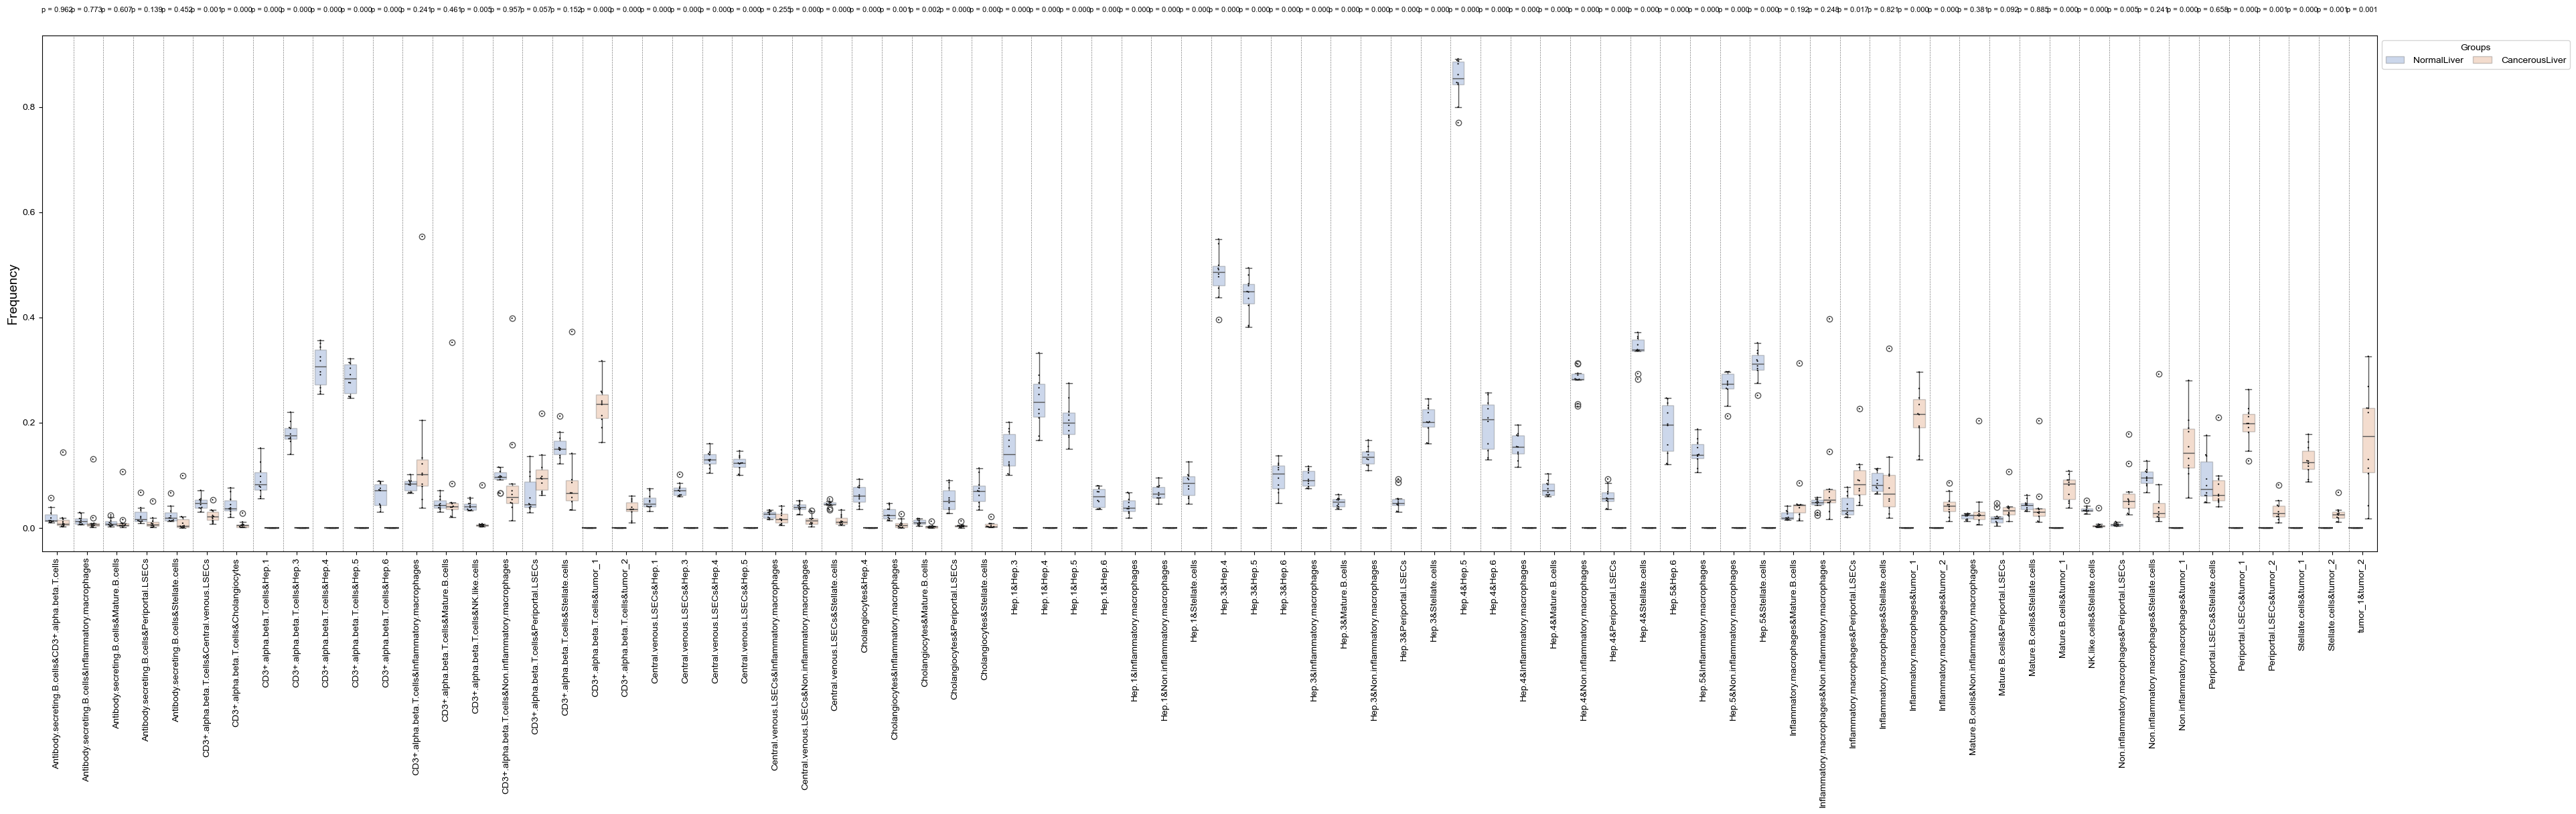

In [30]:
if Hot:
    save_path = 'tissue_celltype_comb_freq.svg'
else:
    save_path = 'coldspot_celltype_comb_freq.svg'
    
selected_cell_types = sorted(grouped_melted['CellType'].unique())
selected_p_values = []

# Perform t-tests
print(f"p-value before correction:")
for ct in selected_cell_types:
    subset = grouped_melted[grouped_melted['CellType'] == ct]
    group1 = subset[subset['Condition'] == 'NormalLiver']['Frequency']
    group2 = subset[subset['Condition'] == 'CancerousLiver']['Frequency']

    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
    print(f"{ct} has p value = {p_value:.3f}")
    selected_p_values.append(p_value)

# Filter the dataframe based on selected CellTypes
grouped_filtered = grouped_melted[grouped_melted['CellType'].isin(selected_cell_types)]

# Plot the filtered data
fig, ax = plt.subplots(figsize=(45,10))
sns.boxplot(data=grouped_filtered, x='CellType', y='Frequency', hue='Condition', palette='muted', boxprops=dict(alpha=.3), ax=ax, dodge=True,order=selected_cell_types)
sns.swarmplot(data=grouped_filtered, x='CellType', y='Frequency', hue='Condition', palette='dark:black', size=1.0, dodge=True,order=selected_cell_types, ax=ax, edgecolor='gray', linewidth=0.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)

pvals_corrected = stats.false_discovery_control(selected_p_values, method='bh')

print('-'*42)
print(f"p-values after correction:")

p_vals_corrected_dict = {}
yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
for i, ct in enumerate(selected_cell_types):
    ax.text(i, yrange, f"p = {pvals_corrected[i]:.3f}", ha='center', fontsize=8, rotation=0)
    print(f"{ct} has p value = {pvals_corrected[i]:.3f}", flush=True)
    p_vals_corrected_dict[ct] = pvals_corrected[i]
    
for i in range(len(selected_cell_types) - 1):
    ax.axvline(i + 0.55, color='grey', linestyle='--', linewidth=0.5)
    
ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel('')   
plt.xticks(rotation=90)  
# fig.savefig('../figures/liver/'+save_path)
plt.show()
plt.close(fig)


In [40]:
circoplot_df1 = global_comb_df.drop(columns=['sample'])
# circoplot_df1 = circoplot_df1[[col for col in circoplot_df1.columns if 'noid' not in col]]

# Group by 'Condition' and calculate the mean of the other columns
circoplot_df1 = circoplot_df1.groupby('Condition').mean().reset_index()
circoplot_df1 = circoplot_df1.set_index('Condition')
circoplot_df1

/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_93189/2966476887.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  circoplot_df1 = global_comb_df.drop(columns=['sample'])
/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_93189/2966476887.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  circoplot_df1 = circoplot_df1.groupby('Condition').mean().reset_index()


Central.venous.LSECs                 \
                              Hep.3 Stellate.cells   
Condition                                            
CancerousLiver             0.000000       0.014275   
NormalLiver                0.072481       0.044753   

                             Mature.B.cells          Hep.3 Cholangiocytes  \
               Non.inflammatory.macrophages Mature.B.cells Stellate.cells   
Condition                                                                   
CancerousLiver                     0.040676        0.00000       0.005053   
NormalLiver                        0.021871        0.04806       0.069949   

                        Hep.5      CD3+.alpha.beta.T.cells                \
               Stellate.cells Non.inflammatory.macrophages NK.like.cells   
Condition                                                                  
CancerousLiver       0.000000                     0.097452      0.012383   
NormalLiver          0.309261                     0.094906      0.041986   

                                    ... Antibody.secreting.B.cells  \
                   Hep.4     Hep.5  ...             Mature.B.cells   
Condition                           ...                              
CancerousLiver  0.000000  0.000000  ...                   0.016074   
NormalLiver     0.305974  0.283923  ...                   0.009815   

               Cholangiocytes  CD3+.alpha.beta.T.cells                 \
                        Hep.4 Inflammatory.macrophages Mature.B.cells   
Condition                                                               
CancerousLiver       0.000000                 0.146969       0.072589   
NormalLiver          0.062573                 0.081738       0.045732   

                                   Antibody.secreting.B.cells   tumor_1  \
                 tumor_1     Hep.3    CD3+.alpha.beta.T.cells   tumor_2   
Condition                                                                 
CancerousLiver  0.231769  0.000000                   0.022196  0.167421   
NormalLiver     0.000000  0.179436                   0.021499  0.000000   

                   Inflammatory.macrophages Cholangiocytes  
               Non.inflammatory.macrophages Mature.B.cells  
Condition                                                   
CancerousLiver                     0.093371       0.002736  
NormalLiver                        0.045725       0.010603  

[2 rows x 78 columns]

In [50]:
circoplot_df2

Condition                  cellType  Frequency
461     NormalLiver                   tumor_2   0.000000
200     NormalLiver                     Hep.5   0.273841
370     NormalLiver  Portal.endothelial.cells   0.001372
369     NormalLiver  Portal.endothelial.cells   0.001372
179     NormalLiver                     Hep.4   0.308040
..              ...                       ...        ...
199  CancerousLiver                     Hep.5   0.000000
198  CancerousLiver                     Hep.5   0.000000
197  CancerousLiver                     Hep.5   0.000000
196  CancerousLiver                     Hep.5   0.000000
232  CancerousLiver  Inflammatory.macrophages   0.013729

[440 rows x 3 columns]

In [51]:
# circoplot_df2 = circoplot_df2[[col for col in circoplot_df2.columns if 'noid' not in col]]
circoplot_df2 = grouped_freq.drop(columns=['sample'])

# Group by 'Condition' and calculate the mean of the other columns
circoplot_df2 = circoplot_df2.groupby('Condition').mean().reset_index()
circoplot_df2 = circoplot_df2.set_index('Condition')
circoplot_df2

cellType        Antibody.secreting.B.cells  CD3+.alpha.beta.T.cells  \
Condition                                                             
CancerousLiver                    0.004335                 0.052099   
NormalLiver                       0.005318                 0.042423   

cellType        Central.venous.LSECs  Cholangiocytes  Erthyroid.cells  \
Condition                                                               
CancerousLiver              0.004248        0.001246         0.000355   
NormalLiver                 0.012634        0.018712         0.003344   

cellType             Hep     Hep.1     Hep.3     Hep.4     Hep.5  ...  \
Condition                                                         ...   
CancerousLiver  0.004334  0.000000  0.000000  0.000000  0.000000  ...   
NormalLiver     0.000000  0.041616  0.068025  0.368931  0.263174  ...   

cellType        Inflammatory.macrophages  Mature.B.cells  NK.like.cells  \
Condition                                                                 
CancerousLiver                  0.041426        0.012241       0.001372   
NormalLiver                     0.019289        0.008970       0.008195   

cellType        Non.inflammatory.macrophages  Periportal.LSECs  \
Condition                                                        
CancerousLiver                      0.021900          0.029793   
NormalLiver                         0.028868          0.024384   

cellType        Portal.endothelial.cells  Stellate.cells  \
Condition                                                  
CancerousLiver                  0.002345        0.024236   
NormalLiver                     0.001588        0.055661   

cellType        gamma.delta.T.cells.1   tumor_1   tumor_2  
Condition                                                  
CancerousLiver               0.001431  0.743387  0.055246  
NormalLiver                  0.009370  0.000000  0.000000  

[2 rows x 21 columns]

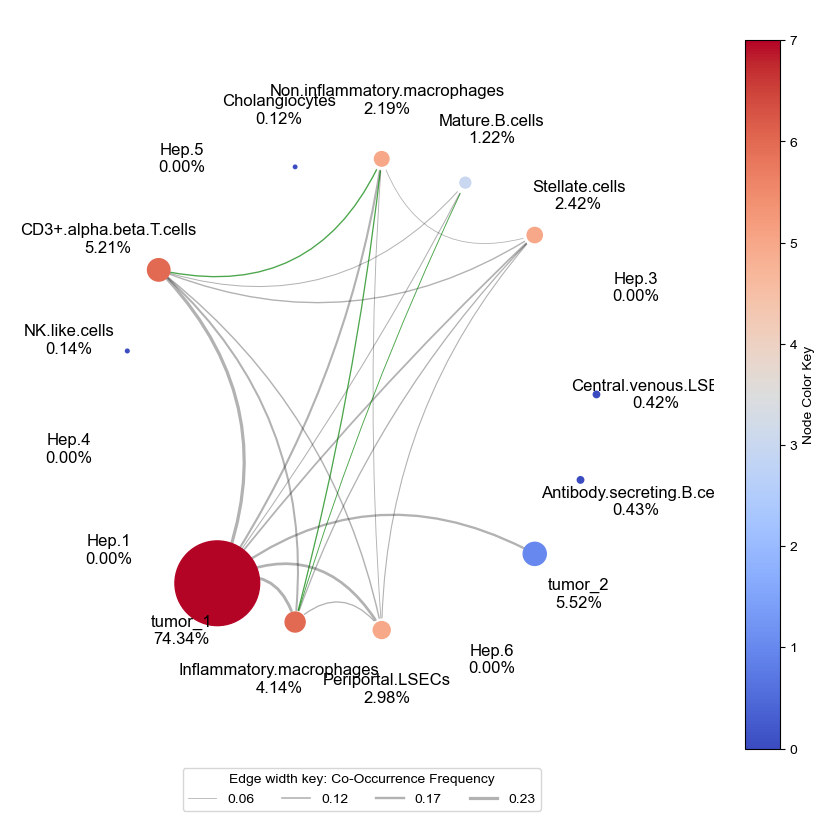

In [53]:
patient_group = 'CancerousLiver'
cirplot_save_path = '../figures/liver/wholetissue_circleplot_'+ patient_group +'.svg'

msd.create_circos_plot(circoplot_df1.loc[[patient_group]], 
                       cell_type_colors_hex=None,
                       cell_abundance=circoplot_df2.loc[[patient_group]],
                       threshold=0.05, 
                       edge_weights_scaler=10,
                       highlighted_edges=highlighted_comb,
                       node_weights_scaler=5000,
                       figure_size=(8,8),
                       save_path=cirplot_save_path)

## Hot/Cold Spot Cellular Analysis

In [38]:
Hot = False
cluster_key = 'cellType' 

library_names = ['NormalLiver', 'CancerousLiver'] 
library_ids = pd.unique(liver_df['sample'])
library_ids = [
    [l for l in library_ids if 'N' in l],
    [l for l in library_ids if 'C' in l]
]
print(library_ids)
total_merged_series = []

comp_results_mice = []
moran_results = []

comb_freq_results = []
comb_freq_results_mice = []

for library, library_name in zip(library_ids, library_names):
    total_comp_dict, global_morans, spot_comb_dict = msd.diversity_clustering(spatial_data=liver_df, 
                                                                              scale=32.0, 
                                                                              library_key='sample',
                                                                              library_ids=library, 
                                                                              spatial_key=['x_slide_um', 'y_slide_um'],
                                                                              cluster_key=cluster_key,
                                                                              hotspot=Hot,
                                                                              top=None,
                                                                              selected_comb=None,
                                                                              restricted=True,
                                                                              metric='Shannon Diversity')

    # Concatenate all the merged_series and sum across rows
    total_merged_series.append(total_comp_dict)
    comb_freq_results.append(spot_comb_dict)
    
    # Store Moran's I 
    moran_results.append(global_morans)
    
    # Calculate cell-type/combination freq in hotspots
    comp_mice = pd.DataFrame()
    comb_mice = pd.DataFrame()
    
    for key in total_comp_dict.keys():
        comp_mice = append_series_to_df(comp_mice, (total_comp_dict[key]/total_comp_dict[key].sum(axis=0)), key)
        comb_mice = append_series_to_df(comb_mice, spot_comb_dict[key], key)
        
    comp_mice = comp_mice.T    
    comp_mice['Condition'] = library_name 
    comp_results_mice.append(comp_mice.fillna(0))
    
    comb_mice = comb_mice.T
    comb_mice['Condition'] = library_name
    comb_freq_results_mice.append(comb_mice.fillna(0))

[['N1', 'N7', 'N9', 'N6', 'N8', 'N2', 'N4', 'N5', 'N0', 'N3'], ['C4', 'C0', 'C1', 'C5', 'C6', 'C7', 'C9', 'C2', 'C3', 'C8']]
Processing region: N1 at scale 32.0
1.465 per cent patches are empty
Global Moran restricted to tissue region with w of shape(1009, 1009)
(1009,)
Local Moran restricted to tissue region with w of shape(1009, 1009)
Region N1 contains 16 diversity coldspots
Considering only hotspots
Processing region: N7 at scale 32.0
1.953 per cent patches are empty
Global Moran restricted to tissue region with w of shape(1004, 1004)
(1004,)
Local Moran restricted to tissue region with w of shape(1004, 1004)
Region N7 contains 21 diversity coldspots
Considering only hotspots
Processing region: N9 at scale 32.0
0.000 per cent patches are empty
Global Moran restricted to tissue region with w of shape(1024, 1024)
(1024,)
Local Moran restricted to tissue region with w of shape(1024, 1024)
Region N9 contains 13 diversity coldspots
Considering only hotspots
Processing region: N6 at scal

/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 46.
  warnings.warn(message)


6.348 per cent patches are empty
Global Moran restricted to tissue region with w of shape(959, 959)
(959,)
Local Moran restricted to tissue region with w of shape(959, 959)
Region C8 contains 53 diversity coldspots
Considering only hotspots


/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 31, 35.
  warnings.warn(message)


### GDI Plots

### process and visualise proportion of cells in hot/cold

Processing N1
Processing N7
Processing N9
Processing N6
Processing N8
Processing N2
Processing N4
Processing N5
Processing N0
Processing N3
Processing C4
Processing C0
Processing C1
Processing C6
Processing C7
Processing C9
Processing C3
Processing C8


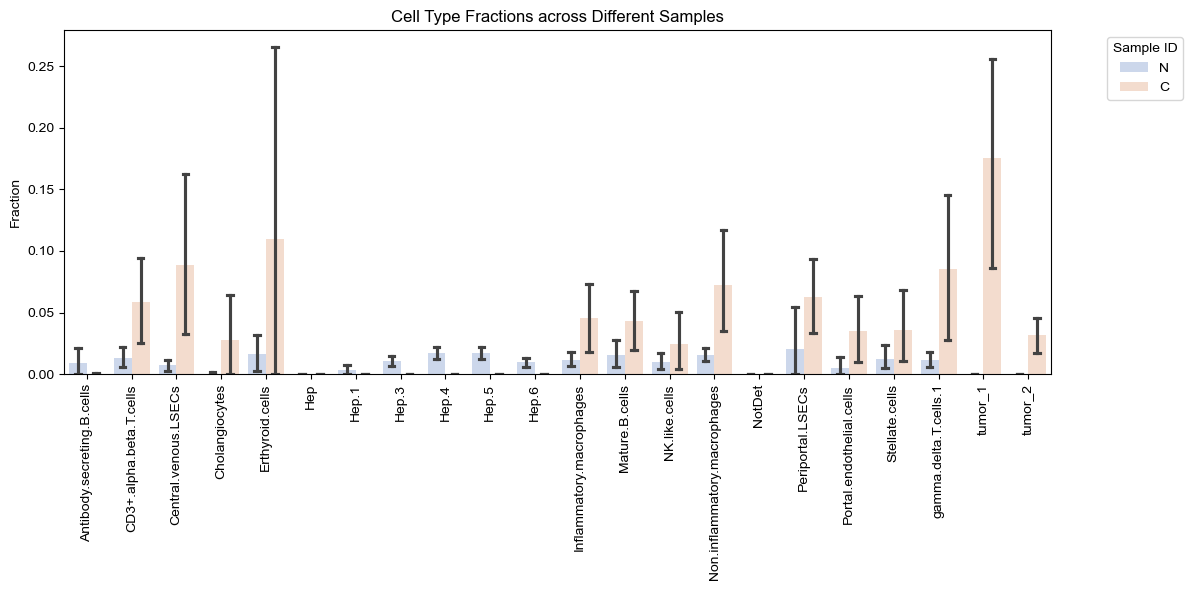

In [39]:
spot_fraction_data = []
for sample_group in total_merged_series: # sample groups is the condition, i.e. Normal V.S. Cancerous
    for ids in sample_group.keys(): # ids are the sample ids, e.g. N0...N9
        print(f'Processing {ids}')
        # print(sample_group[ids])
        # print(global_cell_count.loc[ids])
        fraction = (sample_group[ids]/global_cell_count.loc[ids]).fillna(0)
        fraction_df = fraction.to_frame(name='fraction')
        fraction_df['sample_id'] = ids[0]
        fraction_df['cell_type'] = fraction_df.index
        spot_fraction_data.append(fraction_df)
        # print(fraction_df)
        # print('-'*42)
spot_fraction_df = pd.concat(spot_fraction_data)

# Transform DataFrame for plotting
spot_fraction_df_long = spot_fraction_df.melt(id_vars=['sample_id', 'cell_type'], value_vars=['fraction'])

# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(x='cell_type', y='value', hue='sample_id', 
            data=spot_fraction_df_long, palette='muted', 
            alpha=0.3, capsize=0.25)

# Customize the plot
plt.title('Cell Type Fractions across Different Samples')
plt.xlabel('')
plt.ylabel('Fraction %')
plt.xticks(rotation=90)
plt.legend(title='Sample ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
fig = plt.gcf()
if Hot:
    save_path = 'hotspot_frac.svg'
else:
    save_path = 'coldspot_frac.svg'
fig.savefig('../figures/liver/'+save_path)
plt.show()

/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_62453/233779566.py:16: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(data=data, palette='dark:black', edgecolor='gray', linewidth=0.5, size=5)


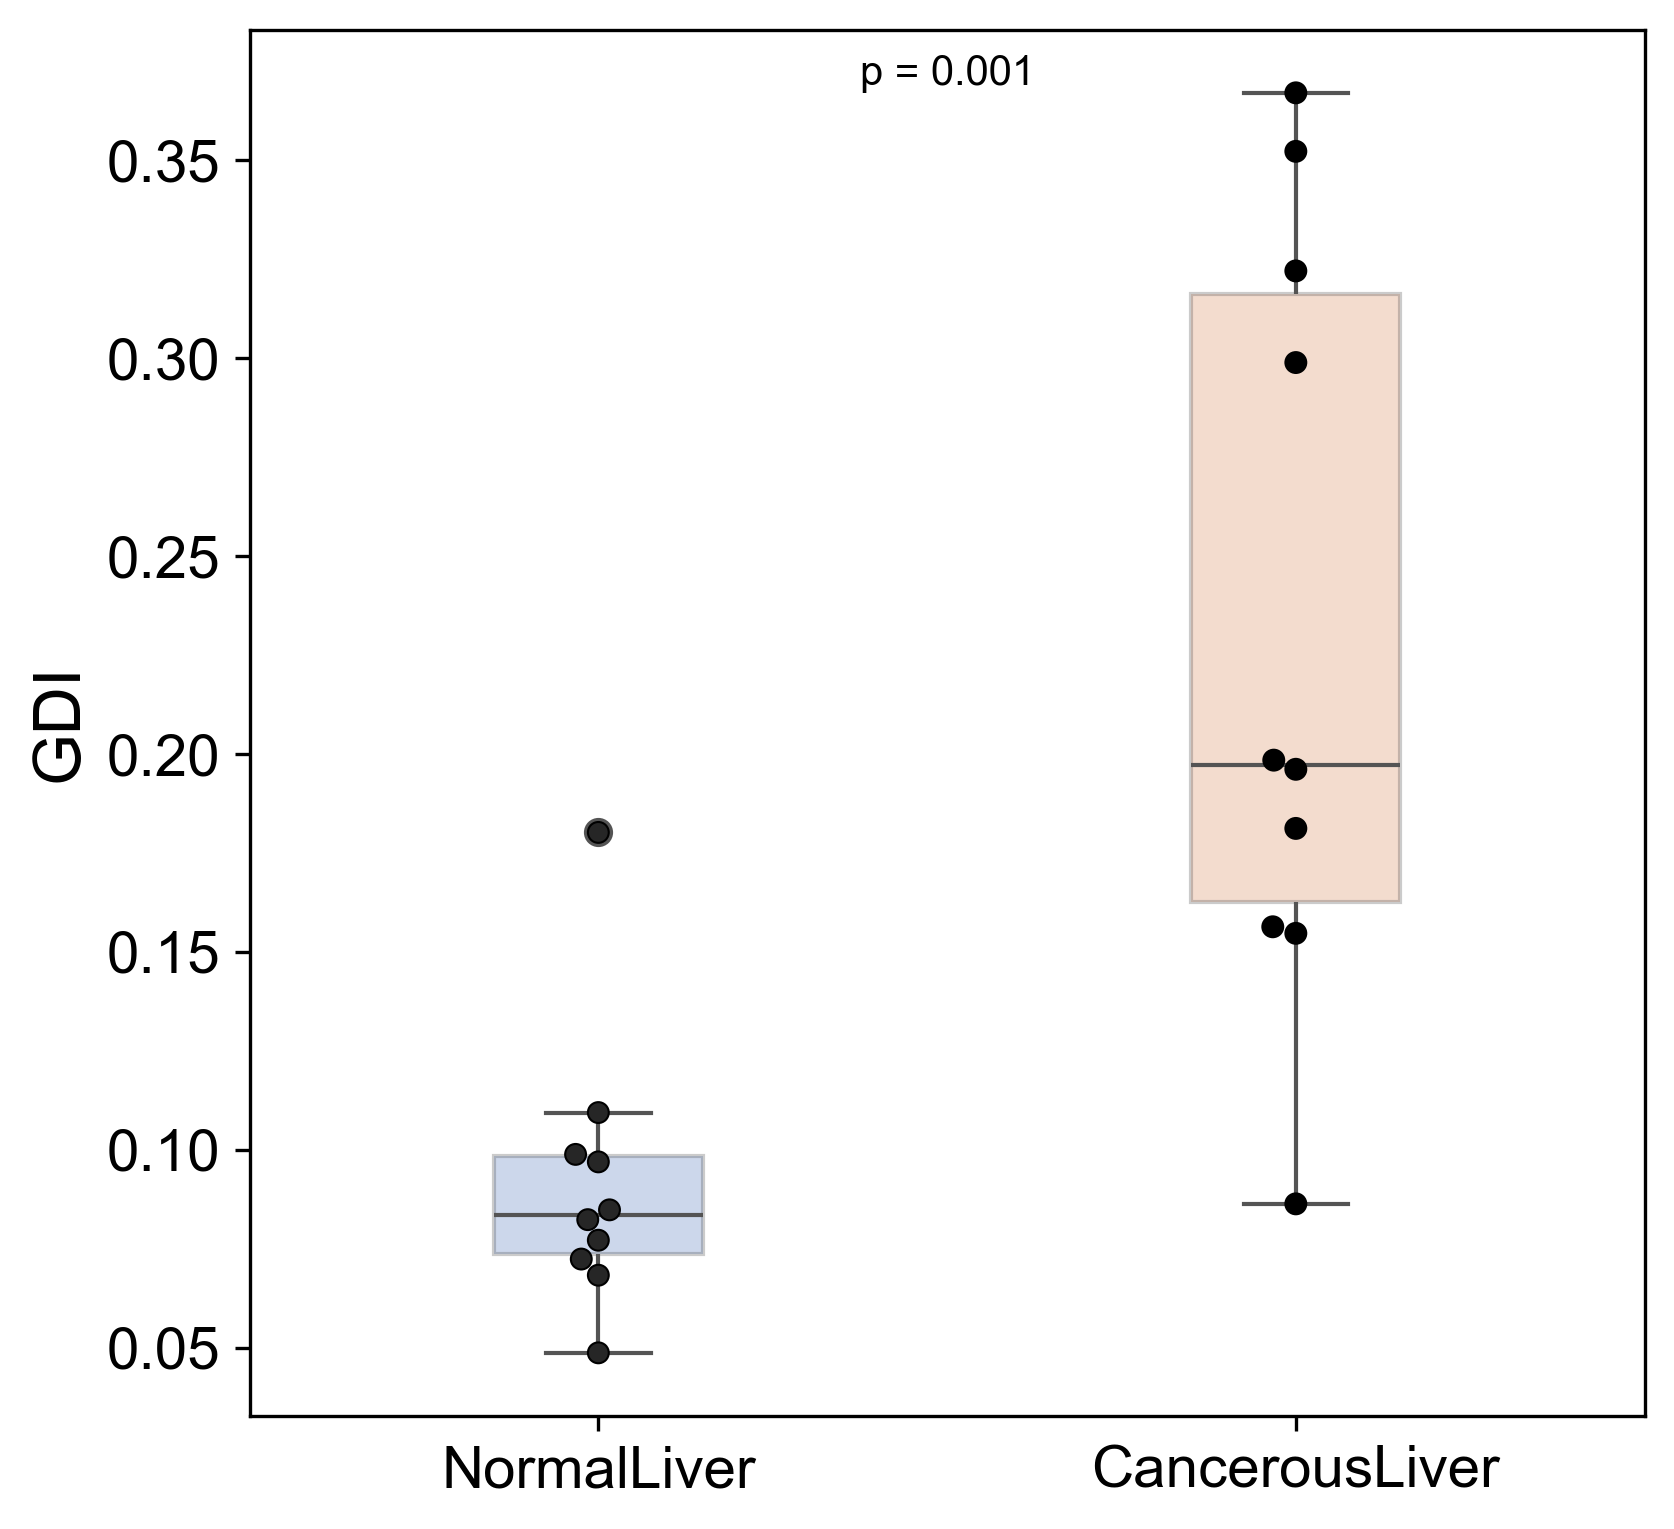

In [39]:
# Extract data for boxplot
normal_data = [v[0] for k, v in moran_results[0].items()]
cancerous_data = [v[0] for k, v in moran_results[1].items()]

# Mann-Whitney U test
# stat, p_value = stats.mannwhitneyu(balbc_data, mrl_data)
stat, p_value = stats.ttest_ind(normal_data, cancerous_data, equal_var=False)

# Combining data
data = [normal_data, cancerous_data]
labels = ['NormalLiver', 'CancerousLiver']

# Plotting
plt.figure(figsize=(6, 6),dpi=300) 
sns.boxplot(data=data, palette="muted", boxprops=dict(alpha=.3), width=0.3)  # Adjusted width here
sns.swarmplot(data=data, palette='dark:black', edgecolor='gray', linewidth=0.5, size=5)

plt.xticks(range(len(labels)), labels, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("GDI", fontsize=16)
# plt.title('Box plot of BALBc vs MRL', fontsize=18)

# Adding the p-value to the plot
plt.text(0.5, max(normal_data + cancerous_data), f'p = {p_value:.3f}', horizontalalignment='center', verticalalignment='bottom')

if Hot:
    save_path = cluster_key + '_hot_GDI.svg'
else:
    save_path = cluster_key + '_cold_GDI.svg'
    
fig = plt.gcf()
fig.savefig('../figures/liver/'+save_path)
save_path = save_path.replace('.svg', '.jpeg')
fig.savefig('../figures/liver/'+save_path)

plt.show()
plt.close(fig)

### Cell Frequency

In [25]:
df1 = comp_results_mice[0]
df2 = comp_results_mice[1]

# get the union of columns
columns = df1.columns.union(df2.columns)
print(len(columns))

# reindex both dataframes with the union of columns, and fill na with 0
df1 = df1.reindex(columns=columns).fillna(0)
df2 = df2.reindex(columns=columns).fillna(0)

23


In [26]:
df_abundance = pd.concat([df1, df2],axis=0)
df_abundance['sample'] = df_abundance.index
df_abundance = df_abundance.drop(columns='NotDet')
df_abundance

Antibody.secreting.B.cells  CD3+.alpha.beta.T.cells  Central.venous.LSECs  \
N1                    0.000000                 0.067416              0.011236   
N7                    0.042184                 0.084367              0.012407   
N9                    0.028409                 0.073864              0.034091   
N6                    0.040201                 0.165829              0.005025   
N8                    0.012658                 0.145570              0.006329   
N2                    0.000000                 0.034483              0.068966   
N4                    0.000000                 0.098361              0.022951   
N5                    0.059406                 0.116337              0.012376   
N0                    0.011696                 0.070175              0.035088   
N3                    0.000000                 0.025641              0.076923   
C4                    0.000000                 0.111880              0.013841   
C0                    0.016949                 0.033898              0.000000   
C1                    0.000000                 0.075758              0.010101   
C5                    0.043796                 0.138686              0.014599   
C6                    0.006098                 0.117073              0.004878   
C7                    0.000000                 0.191268              0.014553   
C9                    0.004808                 0.110577              0.004808   
C2                    0.000000                 0.118519              0.000000   
C3                    0.037449                 0.154858              0.005061   
C8                    0.039352                 0.263889              0.023148   

    Cholangiocytes       Condition  Erthyroid.cells       Hep     Hep.1  \
N1        0.033708     NormalLiver         0.000000  0.000000  0.033708   
N7        0.131514     NormalLiver         0.004963  0.000000  0.057072   
N9        0.011364     NormalLiver         0.005682  0.000000  0.056818   
N6        0.105528     NormalLiver         0.000000  0.000000  0.005025   
N8        0.044304     NormalLiver         0.006329  0.000000  0.101266   
N2        0.000000     NormalLiver         0.000000  0.000000  0.275862   
N4        0.009836     NormalLiver         0.000000  0.000000  0.101639   
N5        0.084158     NormalLiver         0.000000  0.000000  0.032178   
N0        0.002924     NormalLiver         0.002924  0.000000  0.114035   
N3        0.000000     NormalLiver         0.000000  0.000000  0.179487   
C4        0.000000  CancerousLiver         0.000000  0.000000  0.000000   
C0        0.000000  CancerousLiver         0.000000  0.000000  0.000000   
C1        0.000000  CancerousLiver         0.000000  0.000000  0.000000   
C5        0.018248  CancerousLiver         0.000000  0.000000  0.000000   
C6        0.009756  CancerousLiver         0.000000  0.000000  0.000000   
C7        0.001040  CancerousLiver         0.000000  0.000000  0.000000   
C9        0.000000  CancerousLiver         0.000000  0.000000  0.000000   
C2        0.011111  CancerousLiver         0.000000  0.000000  0.000000   
C3        0.010121  CancerousLiver         0.000000  0.031377  0.000000   
C8        0.023148  CancerousLiver         0.000000  0.097222  0.000000   

       Hep.3     Hep.4  ...  Mature.B.cells  NK.like.cells  \
N1  0.067416  0.314607  ...        0.011236       0.011236   
N7  0.094293  0.138958  ...        0.012407       0.004963   
N9  0.096591  0.181818  ...        0.005682       0.005682   
N6  0.035176  0.065327  ...        0.045226       0.020101   
N8  0.113924  0.132911  ...        0.050633       0.025316   
N2  0.206897  0.137931  ...        0.000000       0.000000   
N4  0.101639  0.262295  ...        0.009836       0.049180   
N5  0.047030  0.111386  ...        0.022277       0.014851   
N0  0.102339  0.225146  ...        0.011696       0.011696   
N3  0.153846  0.282051  ...        0.025641       0.000000   
C4  0.000000  0.000000  ...        0.027682 

In [42]:
# Melt the DataFrame
spot_freq = df_abundance.melt(id_vars=['sample', 'Condition'], var_name='cellType', value_name='Frequency')
spot_freq

sample       Condition                    cellType  Frequency
0       N1     NormalLiver  Antibody.secreting.B.cells   0.000000
1       N7     NormalLiver  Antibody.secreting.B.cells   0.015957
2       N9     NormalLiver  Antibody.secreting.B.cells   0.000000
3       N6     NormalLiver  Antibody.secreting.B.cells   0.000000
4       N8     NormalLiver  Antibody.secreting.B.cells   0.000000
..     ...             ...                         ...        ...
355     C6  CancerousLiver                     tumor_2   0.000000
356     C7  CancerousLiver                     tumor_2   0.022636
357     C9  CancerousLiver                     tumor_2   0.018623
358     C3  CancerousLiver                     tumor_2   0.000000
359     C8  CancerousLiver                     tumor_2   0.001490

[360 rows x 4 columns]

p-value before correction:
Antibody.secreting.B.cells has p value = 0.1918
CD3+.alpha.beta.T.cells has p value = 0.2595
Central.venous.LSECs has p value = 0.1169
Cholangiocytes has p value = 0.5213
Erthyroid.cells has p value = 0.0811
Hep.1 has p value = 0.0911
Hep.3 has p value = 0.0001
Hep.4 has p value = 0.0000
Hep.5 has p value = 0.0000
Hep.6 has p value = 0.0001
Inflammatory.macrophages has p value = 0.3625
Mature.B.cells has p value = 0.4984
NK.like.cells has p value = 0.0392
Non.inflammatory.macrophages has p value = 0.0035
Periportal.LSECs has p value = 0.4085
Portal.endothelial.cells has p value = 0.7955
Stellate.cells has p value = 0.0372
gamma.delta.T.cells.1 has p value = 0.0116
tumor_1 has p value = 0.0002
tumor_2 has p value = 0.0378


/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_62453/2036041263.py:26: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(data=df_filtered, x='cellType', y='Frequency', hue='Condition', palette='dark:black', size=3.0, dodge=True, order=selected_cell_types, ax=ax, edgecolor='gray', linewidth=0.5)


------------------------------------------
p-values after correction: 
Antibody.secreting.B.cells in hot spots has p value = 0.274
CD3+.alpha.beta.T.cells in hot spots has p value = 0.346
Central.venous.LSECs in hot spots has p value = 0.180
Cholangiocytes in hot spots has p value = 0.549
Erthyroid.cells in hot spots has p value = 0.148
Hep.1 in hot spots has p value = 0.152
Hep.3 in hot spots has p value = 0.000
Hep.4 in hot spots has p value = 0.000
Hep.5 in hot spots has p value = 0.000
Hep.6 in hot spots has p value = 0.000
Inflammatory.macrophages in hot spots has p value = 0.453
Mature.B.cells in hot spots has p value = 0.549
NK.like.cells in hot spots has p value = 0.078
Non.inflammatory.macrophages in hot spots has p value = 0.012
Non.inflammatory.macrophages in whole tissue has p value = 0.410
******************************************
Periportal.LSECs in hot spots has p value = 0.481
Portal.endothelial.cells in hot spots has p value = 0.795
Stellate.cells in hot spots has p v

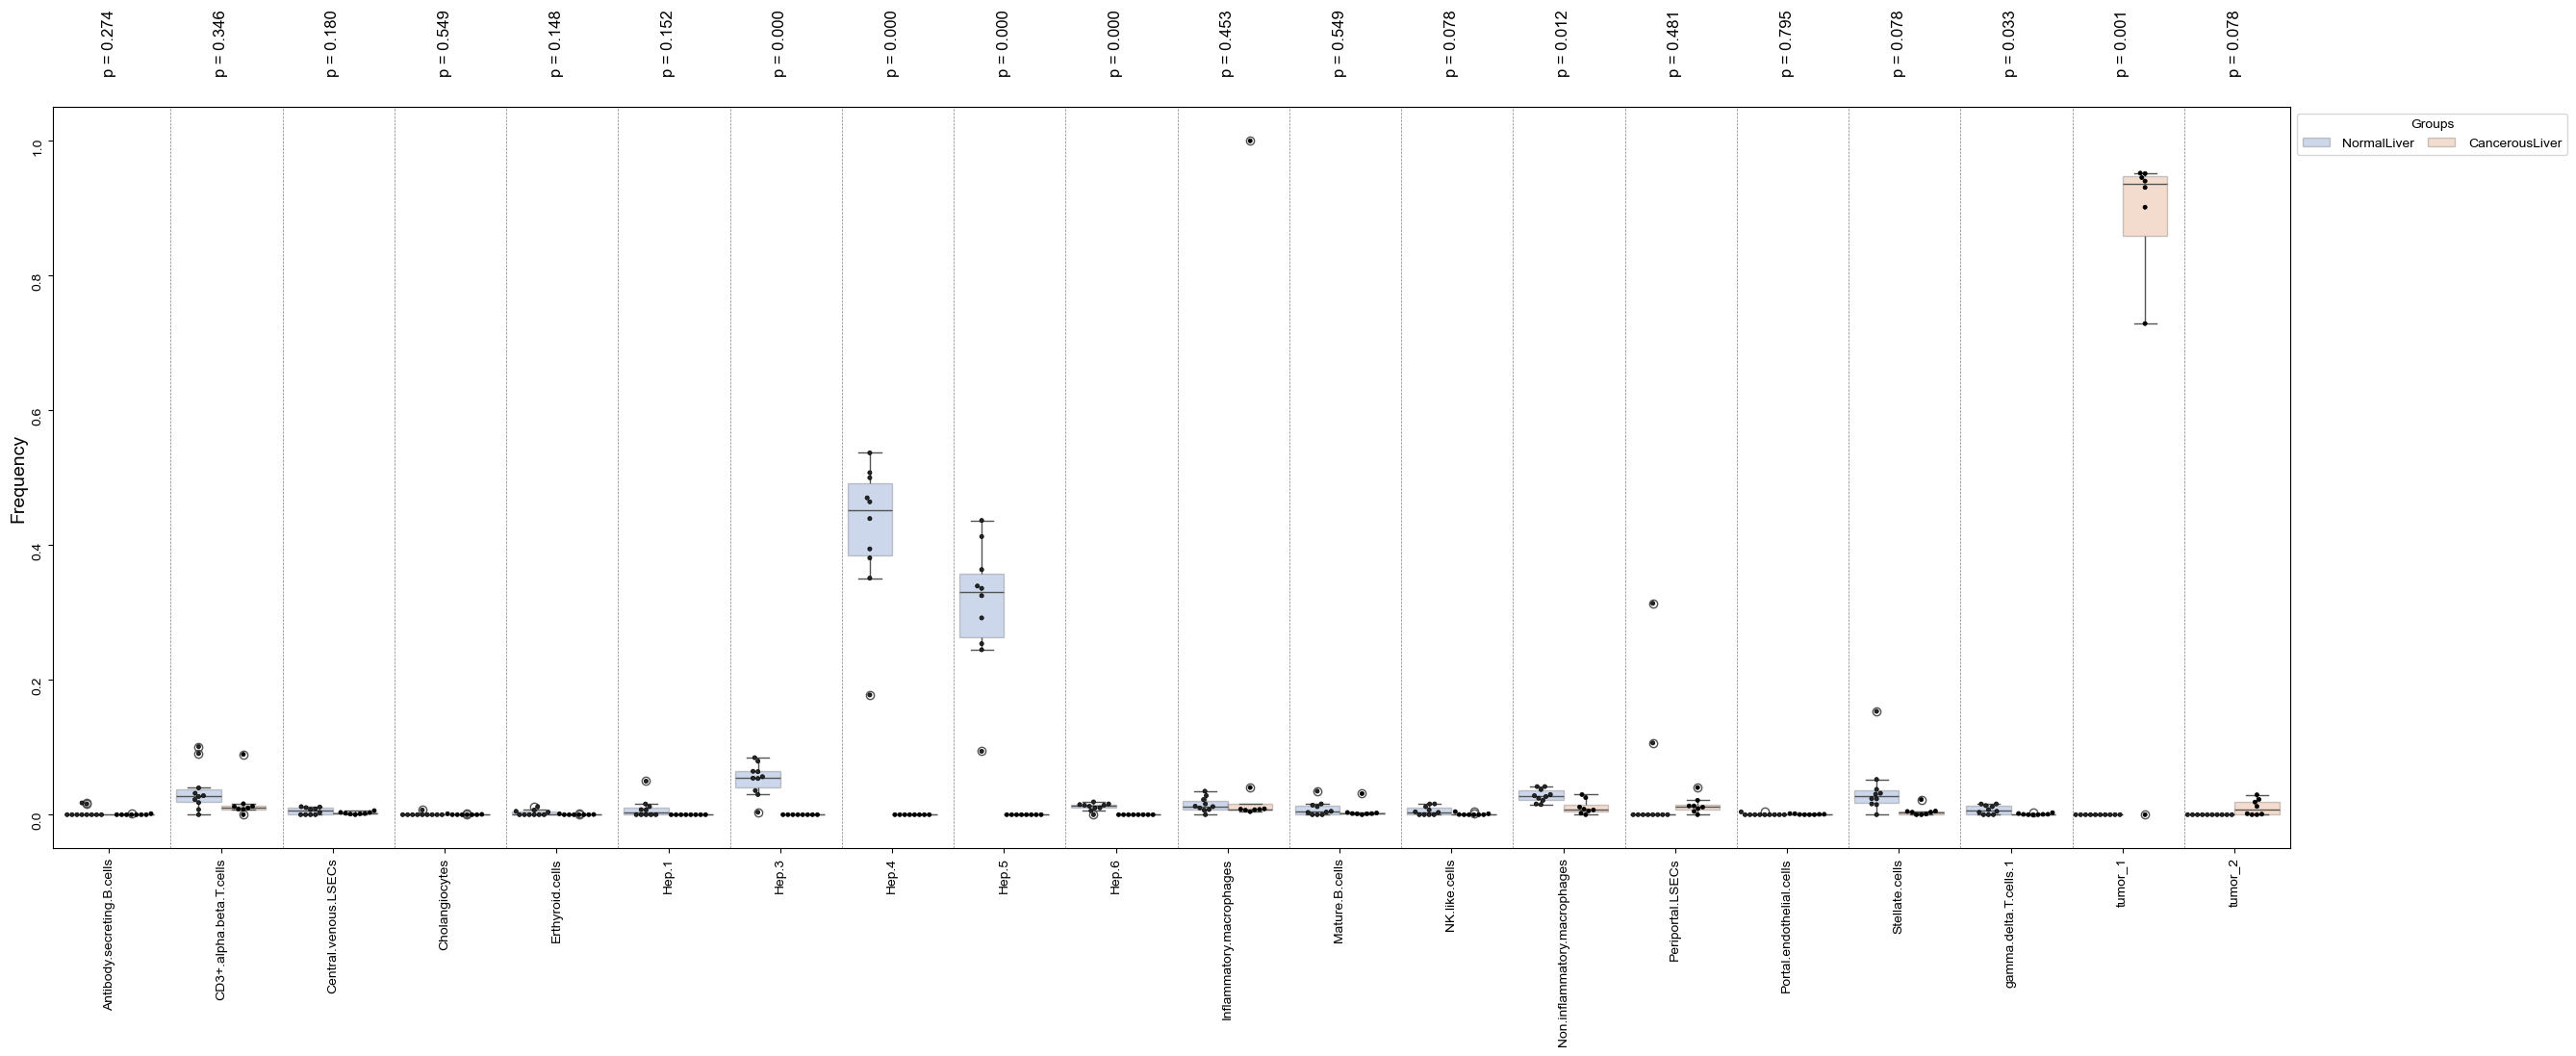

In [46]:
if Hot:
    save_path = 'hotspot_celltype_freq.svg'
else:
    save_path = 'coldspot_celltype_freq.svg'
    
selected_cell_types = sorted(spot_freq['cellType'].unique())
selected_p_values = []

# Perform t-tests
print(f"p-value before correction:")
for ct in selected_cell_types: # df_melted['CellType'].unique():
    subset = spot_freq[spot_freq['cellType'] == ct]
    group1 = subset[subset['Condition'] == 'NormalLiver']['Frequency']
    group2 = subset[subset['Condition'] == 'CancerousLiver']['Frequency']

    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
    print(f"{ct} has p value = {p_value:.4f}")    
    selected_p_values.append(p_value)

# Filter the dataframe based on selected CellTypes
df_filtered = spot_freq[spot_freq['cellType'].isin(selected_cell_types)]

# Plot the filtered data
fig, ax = plt.subplots(figsize=(30,10))
sns.boxplot(data=df_filtered, x='cellType', y='Frequency', hue='Condition', palette='muted', boxprops=dict(alpha=.3), ax=ax, dodge=True,order=selected_cell_types)
sns.swarmplot(data=df_filtered, x='cellType', y='Frequency', hue='Condition', palette='dark:black', size=3.0, dodge=True, order=selected_cell_types, ax=ax, edgecolor='gray', linewidth=0.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)

hot_pvals_corrected = stats.false_discovery_control(selected_p_values, method='bh')

print('-'*42)
print(f"p-values after correction: ")

yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
for i, ct in enumerate(selected_cell_types):
    ax.text(i, yrange, f"p = {hot_pvals_corrected[i]:.3f}", ha='center', fontsize=12, rotation=90)
    print(f"{ct} in hot spots has p value = {hot_pvals_corrected[i]:.3f}", flush=True)
    if hot_pvals_corrected[i] < 0.05 and p_vals_corrected_dict[ct] > 0.05:
        print(f"{ct} in whole tissue has p value = {p_vals_corrected_dict[ct]:.3f}", flush=True)
        print('*'*42)
    
for i in range(len(selected_cell_types) - 1):
    ax.axvline(i + 0.55, color='grey', linestyle='--', linewidth=0.5)
    
ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel('')    
plt.xticks(rotation=90)  
plt.yticks(rotation=90) 
fig.savefig('../figures/liver/'+save_path)
plt.show()
plt.close(fig)


/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_48816/2386656831.py:13: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(data=combined_df[combined_df['cellType'] == ct], x='combined_x', y='Frequency', hue='Condition', palette='dark:black', size=5.0, dodge=True, ax=ax, edgecolor='gray', linewidth=0.5)


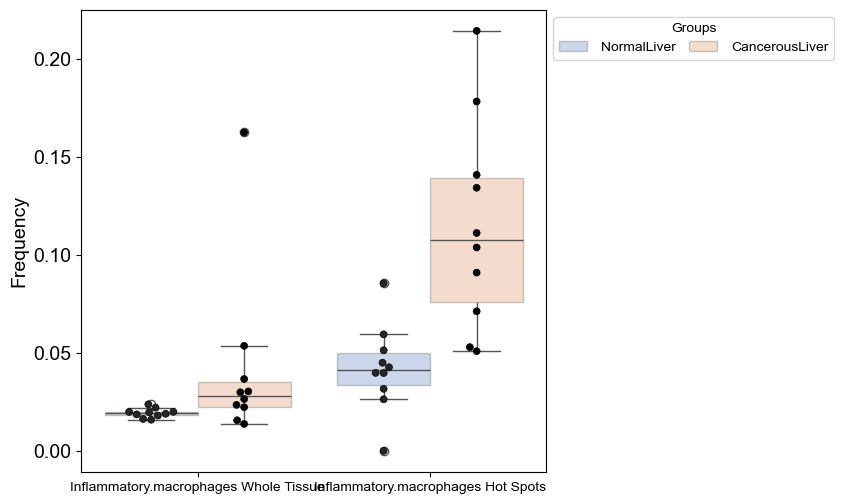

In [88]:
ct = 'Inflammatory.macrophages'
# Add a source column to each dataframe
global_freq['source'] = 'Whole Tissue'
spot_freq['source'] = 'Hot Spots'

# Combine the dataframes
combined_df = pd.concat([global_freq, spot_freq], ignore_index=True)
combined_df['combined_x'] = combined_df['cellType'] + ' ' + combined_df['source']

fig, ax = plt.subplots(figsize=(6,6))

sns.boxplot(data=combined_df[combined_df['cellType'] == ct], x='combined_x', y='Frequency', hue='Condition', palette='muted', boxprops=dict(alpha=.3), ax=ax, dodge=True)
sns.swarmplot(data=combined_df[combined_df['cellType'] == ct], x='combined_x', y='Frequency', hue='Condition', palette='dark:black', size=5.0, dodge=True, ax=ax, edgecolor='gray', linewidth=0.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(set(combined_df['Condition']))], labels[:len(set(combined_df['Condition']))], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)
ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel('')
plt.yticks(fontsize=14)

save_path = save_path = ct.replace(' ', '_').replace('/', '')+'.svg'
fig.savefig('../figures/liver/'+save_path)

### Cell Co-occurrence

In [19]:
spot_df1 = comb_freq_results_mice[0]
spot_df2 = comb_freq_results_mice[1]

# get the union of columns
columns = spot_df1.columns.union(spot_df2.columns)
print(len(columns))

# reindex both dataframes with the union of columns, and fill na with 0
spot_df1 = spot_df1.reindex(columns=columns).fillna(0)
spot_df2 = spot_df2.reindex(columns=columns).fillna(0)

186


In [20]:
temp = pd.concat([spot_df1, spot_df2],axis=0)
temp = temp.sort_index(axis=1) 
condition_col = temp['Condition']
temp = temp.drop(columns='Condition')

spot_comb_df = temp.loc[:, (temp[temp.columns.difference([('Condition','')])].mean() > 0.05)].copy()
spot_comb_df['Condition'] = condition_col
spot_comb_df['sample'] = spot_comb_df.index
spot_comb_df.sort_index(axis=1,inplace=True)

In [21]:
spot_subset_cols = spot_comb_df.columns

In [103]:
spot_comb_df = pd.concat([spot_df1, spot_df2],axis=0)
spot_comb_df['sample'] = spot_comb_df.index
spot_comb_df = spot_comb_df.reindex(columns=union_cols)
spot_comb_df = spot_comb_df.sort_index(axis=1)

In [28]:
# Multi-index to single-index column
new_columns = []
for col in spot_comb_df.columns:
    if isinstance(col, tuple):  # This checks if the column is a MultiIndex
        # Join only if the column name is not 'Mouse' or 'Condition'
        if "sample" not in col and "Condition" not in col:
            new_columns.append('&'.join(map(str, col)).strip())
        else:
            # If 'Mouse' or 'Condition' is in the column, it is not joined with '&'
            new_columns.append(col[0])
    else:
        new_columns.append(col)
spot_comb_df.columns = new_columns

spot_comb_df = spot_comb_df[[col for col in spot_comb_df.columns if 'NotDet' not in col]]

# Melt the DataFrame
df_melted = spot_comb_df.melt(id_vars=['sample', 'Condition'], var_name='CellType', value_name='Frequency')

p-value before correction: 
Antibody.secreting.B.cells&CD3+.alpha.beta.T.cells has p value = 0.293
Antibody.secreting.B.cells&Inflammatory.macrophages has p value = 0.400
Antibody.secreting.B.cells&Mature.B.cells has p value = 0.456
Antibody.secreting.B.cells&Periportal.LSECs has p value = 0.092
Antibody.secreting.B.cells&Stellate.cells has p value = 0.211
CD3+.alpha.beta.T.cells&Central.venous.LSECs has p value = 0.069
CD3+.alpha.beta.T.cells&Cholangiocytes has p value = 0.037
CD3+.alpha.beta.T.cells&Hep.1 has p value = 0.001
CD3+.alpha.beta.T.cells&Hep.3 has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.4 has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.5 has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.6 has p value = 0.023
CD3+.alpha.beta.T.cells&Inflammatory.macrophages has p value = 0.060
CD3+.alpha.beta.T.cells&Mature.B.cells has p value = 0.266
CD3+.alpha.beta.T.cells&NK.like.cells has p value = 0.016
CD3+.alpha.beta.T.cells&Non.inflammatory.macrophages has p value = 0.008
CD3+.alp

/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_93189/4204210515.py:26: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(data=df_filtered, x='CellType', y='Frequency', hue='Condition', palette='dark:black', size=2.0, dodge=True,order=selected_cell_types, ax=ax, edgecolor='gray', linewidth=0.5)
/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


------------------------------------------
p-values after correction:
Antibody.secreting.B.cells&CD3+.alpha.beta.T.cells in hot spots has p value = 0.336
Antibody.secreting.B.cells&Inflammatory.macrophages in hot spots has p value = 0.446
Antibody.secreting.B.cells&Mature.B.cells in hot spots has p value = 0.501
Antibody.secreting.B.cells&Periportal.LSECs in hot spots has p value = 0.122
Antibody.secreting.B.cells&Stellate.cells in hot spots has p value = 0.257
CD3+.alpha.beta.T.cells&Central.venous.LSECs in hot spots has p value = 0.094
CD3+.alpha.beta.T.cells&Cholangiocytes in hot spots has p value = 0.053
CD3+.alpha.beta.T.cells&Hep.1 in hot spots has p value = 0.002
CD3+.alpha.beta.T.cells&Hep.3 in hot spots has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.4 in hot spots has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.5 in hot spots has p value = 0.000
CD3+.alpha.beta.T.cells&Hep.6 in hot spots has p value = 0.039
CD3+.alpha.beta.T.cells&Inflammatory.macrophages in hot spots has p v

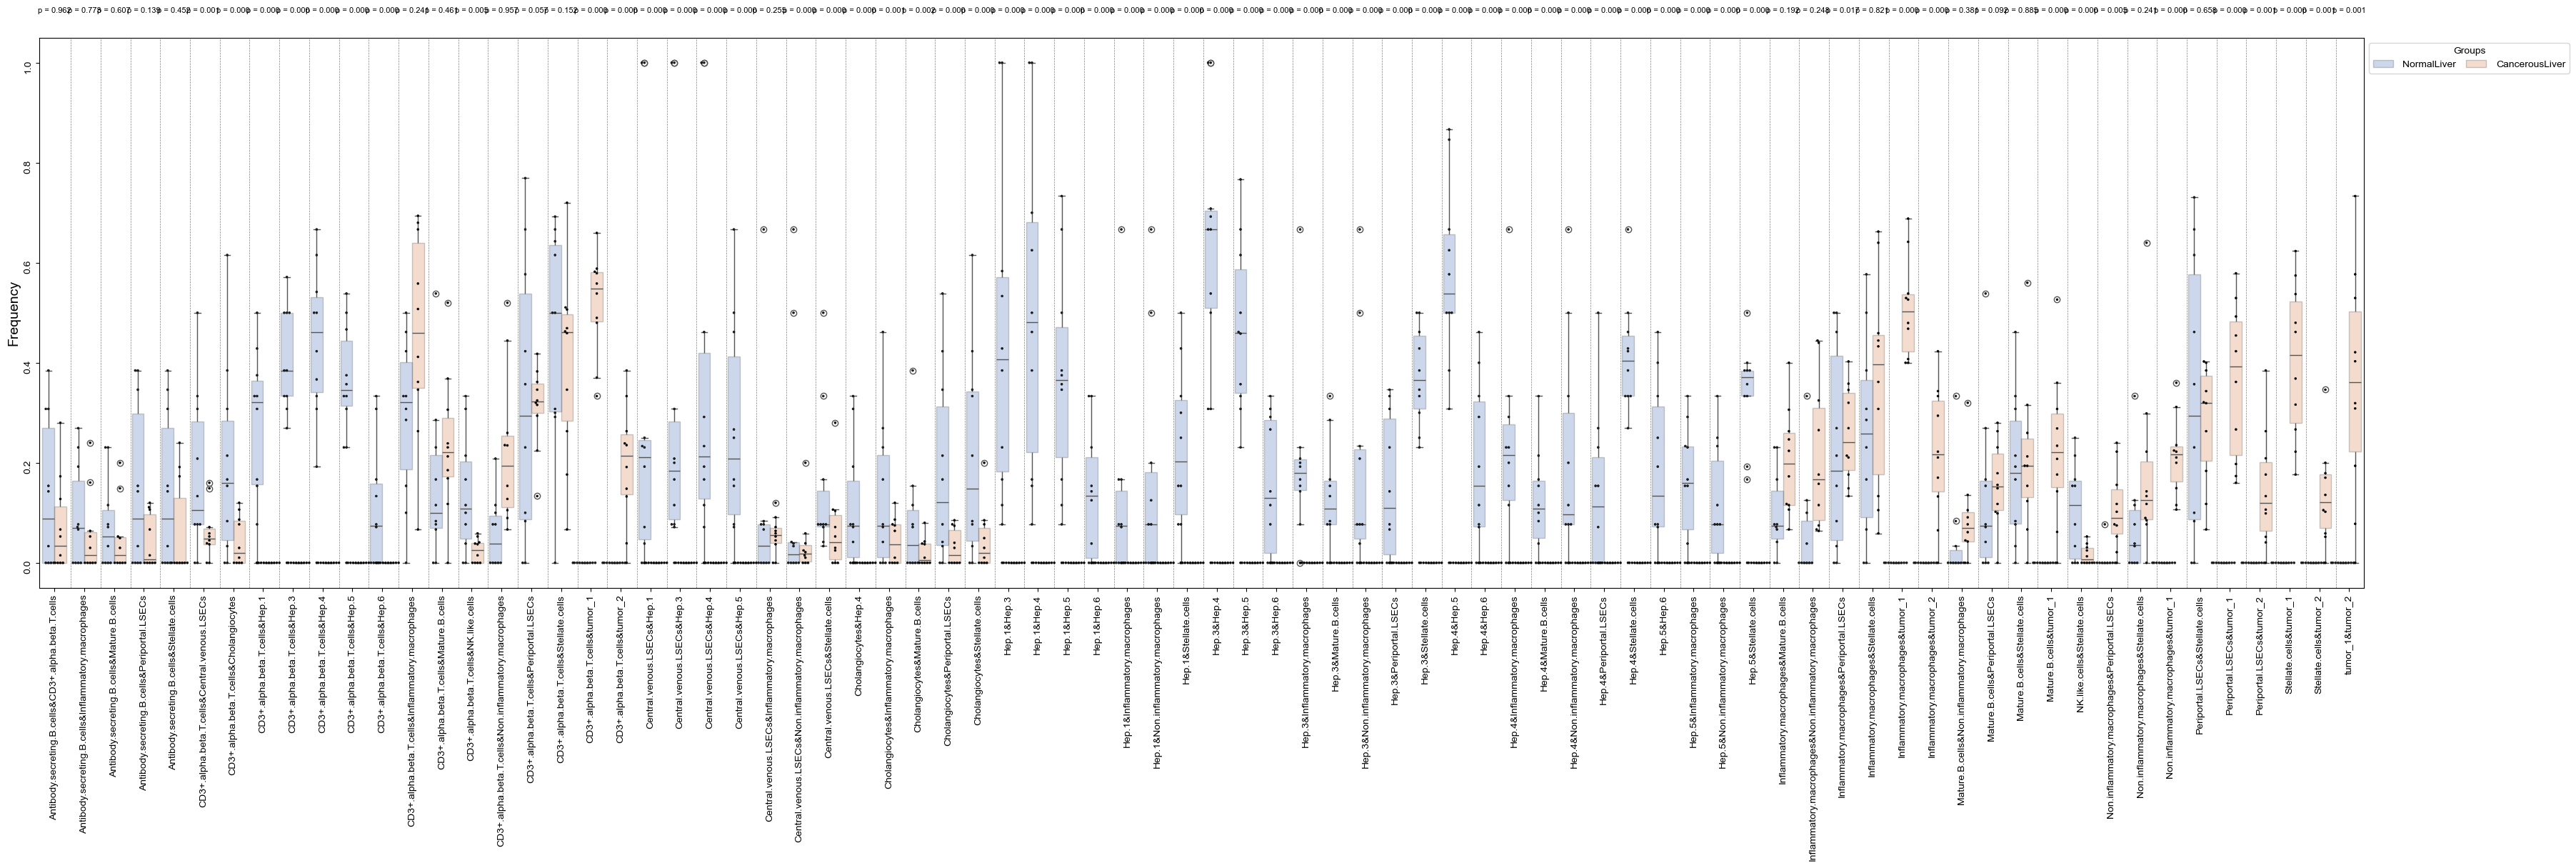

In [31]:
if Hot:
    save_path = 'hotspot_celltype_comb_freq.svg'
else:
    save_path = 'coldspot_celltype_comb_freq.svg'
    
selected_cell_types = sorted(df_melted['CellType'].unique())
selected_p_values = []

# Perform t-tests
print(f"p-value before correction: ")
for ct in selected_cell_types: # df_melted['CellType'].unique():
    subset = df_melted[df_melted['CellType'] == ct]
    group1 = subset[subset['Condition'] == 'NormalLiver']['Frequency']
    group2 = subset[subset['Condition'] == 'CancerousLiver']['Frequency']

    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
    print(f"{ct} has p value = {p_value:.3f}")
    selected_p_values.append(p_value)

# Filter the dataframe based on selected CellTypes
df_filtered = df_melted[df_melted['CellType'].isin(selected_cell_types)]

# Plot the filtered data
fig, ax = plt.subplots(figsize=(42,10))
sns.boxplot(data=df_filtered, x='CellType', y='Frequency', hue='Condition', palette='muted', boxprops=dict(alpha=.3), ax=ax, dodge=True,order=selected_cell_types)
sns.swarmplot(data=df_filtered, x='CellType', y='Frequency', hue='Condition', palette='dark:black', size=2.0, dodge=True,order=selected_cell_types, ax=ax, edgecolor='gray', linewidth=0.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)

hot_pvals_corrected = stats.false_discovery_control(selected_p_values, method='bh')

print('-'*42)
print(f"p-values after correction:")

highlighted_comb = []
yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
for i, ct in enumerate(selected_cell_types):
    ax.text(i, yrange, f"p = {pvals_corrected[i]:.3f}", ha='center', fontsize=8, rotation=0)
    print(f"{ct} in hot spots has p value = {hot_pvals_corrected[i]:.3f}", flush=True)
    if hot_pvals_corrected[i] < 0.05 and p_vals_corrected_dict[ct] >= 0.05:
        highlighted_comb.append(tuple(map(str.strip, ct.split('&'))))
        print(f"{ct} in whole tissue has p value = {p_vals_corrected_dict[ct]:.3f}", flush=True)
        print('*'*42)
    
for i in range(len(selected_cell_types) - 1):
    ax.axvline(i + 0.55, color='grey', linestyle='--', linewidth=0.5)
    
ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel('')   
plt.xticks(rotation=90)  
plt.yticks(rotation=90)  
# fig.savefig('../figures/liver/'+save_path)
plt.show()
plt.close(fig)


/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_48816/2915350216.py:16: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(data=combined_df[combined_df['CellType'] == ct], x='combined_x', y='Frequency', hue='Condition', palette='dark:black', size=5.0, dodge=True, ax=ax, edgecolor='gray', linewidth=0.5)


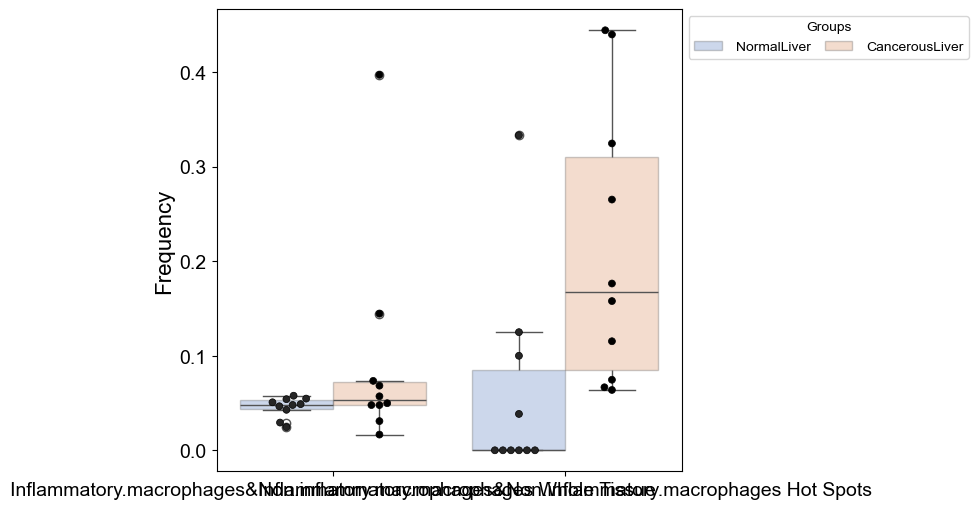

In [109]:
ct = 'Inflammatory.macrophages&Non.inflammatory.macrophages'
# Add a source column to each dataframe
grouped_melted['source'] = 'Whole Tissue'
df_melted['source'] = 'Hot Spots'

# Standardize the column names
# df_melted.rename(columns={'CellType': 'cell_type', 'Condition': 'group'}, inplace=True)

# Combine the dataframes
combined_df = pd.concat([grouped_melted, df_melted], ignore_index=True)
combined_df['combined_x'] = combined_df['CellType'] + ' ' + combined_df['source']

fig, ax = plt.subplots(figsize=(6,6))

sns.boxplot(data=combined_df[combined_df['CellType'] == ct], x='combined_x', y='Frequency', hue='Condition', palette='muted', boxprops=dict(alpha=.3), ax=ax, dodge=True)
sns.swarmplot(data=combined_df[combined_df['CellType'] == ct], x='combined_x', y='Frequency', hue='Condition', palette='dark:black', size=5.0, dodge=True, ax=ax, edgecolor='gray', linewidth=0.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(set(combined_df['Condition']))], labels[:len(set(combined_df['Condition']))], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)
ax.set_ylabel("Frequency", fontsize=16)
ax.set_xlabel('')

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

save_path = save_path = ct.replace(' ', '_').replace('/', '')+'.svg'
fig.savefig('../figures/liver/'+save_path)

### circle plot

In [23]:
circoplot_df1 = spot_comb_df.drop(columns=['sample'])
# circoplot_df1 = circoplot_df1[[col for col in circoplot_df1.columns if 'noid' not in col]]

# Group by 'Condition' and calculate the mean of the other columns
circoplot_df1 = circoplot_df1.groupby('Condition').mean().reset_index()
circoplot_df1 = circoplot_df1.set_index('Condition')
circoplot_df1

Antibody.secreting.B.cells                           \
                  CD3+.alpha.beta.T.cells Inflammatory.macrophages   
Condition                                                            
CancerousLiver                   0.071472                 0.054681   
NormalLiver                      0.133004                 0.090733   

                                                               \
               Mature.B.cells Periportal.LSECs Stellate.cells   
Condition                                                       
CancerousLiver       0.048080         0.041909       0.060433   
NormalLiver          0.075861         0.144542       0.136850   

               CD3+.alpha.beta.T.cells                                     \
                  Central.venous.LSECs Cholangiocytes     Hep.1     Hep.3   
Condition                                                                   
CancerousLiver                0.061259       0.042978  0.000000  0.000000   
NormalLiver                   0.171346       0.195916  0.267537  0.408425   

                          ...  NK.like.cells Non.inflammatory.macrophages  \
                   Hep.4  ... Stellate.cells             Periportal.LSECs   
Condition                 ...                                               
CancerousLiver  0.000000  ...       0.015938                     0.106321   
NormalLiver     0.444679  ...       0.104890                     0.007692   

                                        Periportal.LSECs                      \
               Stellate.cells   tumor_1   Stellate.cells   tumor_1   tumor_2   
Condition                                                                      
CancerousLiver       0.180634  0.213524         0.280178  0.363789  0.146445   
NormalLiver          0.072244  0.000000         0.324560  0.000000  0.000000   

               Stellate.cells            tumor_1  
                      tumor_1   tumor_2  tumor_2  
Condition                                         
CancerousLiver        0.40268  0.134935  0.35633  
NormalLiver           0.00000  0.000000  0.00000  

[2 rows x 78 columns]

In [27]:
circoplot_df2 = df_abundance.drop(columns=['sample'])
# circoplot_df2 = circoplot_df2[[col for col in circoplot_df2.columns if 'noid' not in col]]

# Group by 'Condition' and calculate the mean of the other columns
circoplot_df2 = circoplot_df2.groupby('Condition').mean().reset_index()
circoplot_df2 = circoplot_df2.set_index('Condition')
circoplot_df2

Antibody.secreting.B.cells  CD3+.alpha.beta.T.cells  \
Condition                                                             
CancerousLiver                    0.014845                 0.131641   
NormalLiver                       0.019455                 0.088204   

                Central.venous.LSECs  Cholangiocytes  Erthyroid.cells  \
Condition                                                               
CancerousLiver              0.009099        0.007342          0.00000   
NormalLiver                 0.028539        0.042334          0.00199   

                    Hep     Hep.1     Hep.3     Hep.4     Hep.5  ...  \
Condition                                                        ...   
CancerousLiver  0.01286  0.000000  0.000000  0.000000  0.000000  ...   
NormalLiver     0.00000  0.095709  0.101915  0.185243  0.116906  ...   

                Inflammatory.macrophages  Mature.B.cells  NK.like.cells  \
Condition                                                                 
CancerousLiver                  0.114776        0.035472       0.002622   
NormalLiver                     0.042112        0.019463       0.014303   

                Non.inflammatory.macrophages  Periportal.LSECs  \
Condition                                                        
CancerousLiver                      0.034992          0.064790   
NormalLiver                         0.021344          0.077415   

                Portal.endothelial.cells  Stellate.cells  \
Condition                                                  
CancerousLiver                  0.005422        0.089846   
NormalLiver                     0.007962        0.111953   

                gamma.delta.T.cells.1   tumor_1  tumor_2  
Condition                                                 
CancerousLiver               0.003930  0.348701  0.12329  
NormalLiver                  0.006503  0.000000  0.00000  

[2 rows x 21 columns]

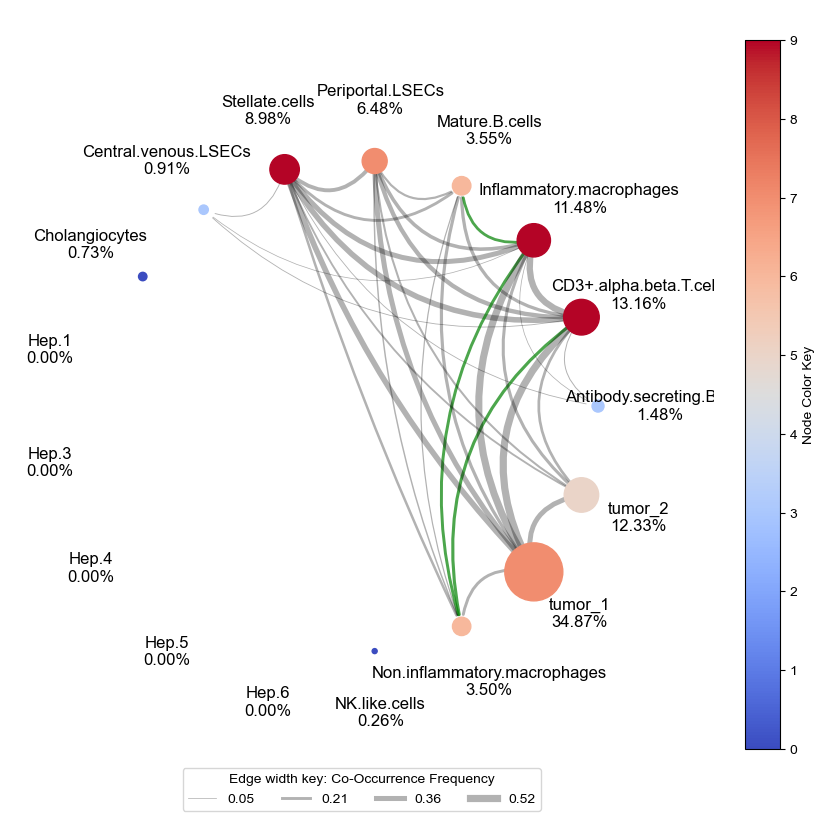

In [34]:
patient_group = 'CancerousLiver'
cirplot_save_path = '../figures/liver/hotspots_circleplot_'+ patient_group +'.svg'

msd.create_circos_plot(circoplot_df1.loc[[patient_group]], 
                       cell_type_colors_hex=None,
                       cell_abundance=circoplot_df2.loc[[patient_group]],
                       threshold=0.05, 
                       edge_weights_scaler=10,
                       highlighted_edges=highlighted_comb,
                       node_weights_scaler=5000,
                       figure_size=(8,8),
                       save_path=cirplot_save_path)

## Calculate Proximity Index

In [22]:
Hot = True
library_names = ['NormalLiver', 'CancerousLiver'] 
library_ids = pd.unique(liver_df['sample'])
library_ids = [
    [l for l in library_ids if 'N' in l],
    [l for l in library_ids if 'C' in l]
]
print(library_ids)
PX_results = []


for library, library_name in zip(library_ids, library_names):
    proximity_I = msd.sample_proximity(spatial_data=liver_df, 
                                       scale=32.0, 
                                       library_key='sample',
                                       library_ids=library, 
                                       spatial_key=['x_slide_um', 'y_slide_um'],
                                       cluster_key=cluster_key,
                                       hotspot=Hot,
                                       metric='Shannon Diversity')
    # Store PX 
    PX_results.append(proximity_I)


[['N1', 'N7', 'N9', 'N6', 'N8', 'N2', 'N4', 'N5', 'N0', 'N3'], ['C4', 'C0', 'C1', 'C5', 'C6', 'C7', 'C9', 'C2', 'C3', 'C8']]
Processing region: N1 at scale 32.0
1.465 per cent patches are empty
Region N1 contains 13 diversity hotspots
9 islands identified
Processing region: N7 at scale 32.0
1.953 per cent patches are empty
Region N7 contains 28 diversity hotspots
8 islands identified
Processing region: N9 at scale 32.0
0.000 per cent patches are empty
Region N9 contains 24 diversity hotspots
12 islands identified
Processing region: N6 at scale 32.0
0.195 per cent patches are empty
Region N6 contains 27 diversity hotspots
8 islands identified
Processing region: N8 at scale 32.0
0.195 per cent patches are empty
Region N8 contains 51 diversity hotspots
8 islands identified
Processing region: N2 at scale 32.0
0.000 per cent patches are empty
Region N2 contains 7 diversity hotspots
5 islands identified
Processing region: N4 at scale 32.0
0.000 per cent patches are empty
Region N4 contains 1

/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_48816/2203279927.py:21: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(data=data, palette='dark:black', edgecolor='gray', linewidth=0.5, size=5)


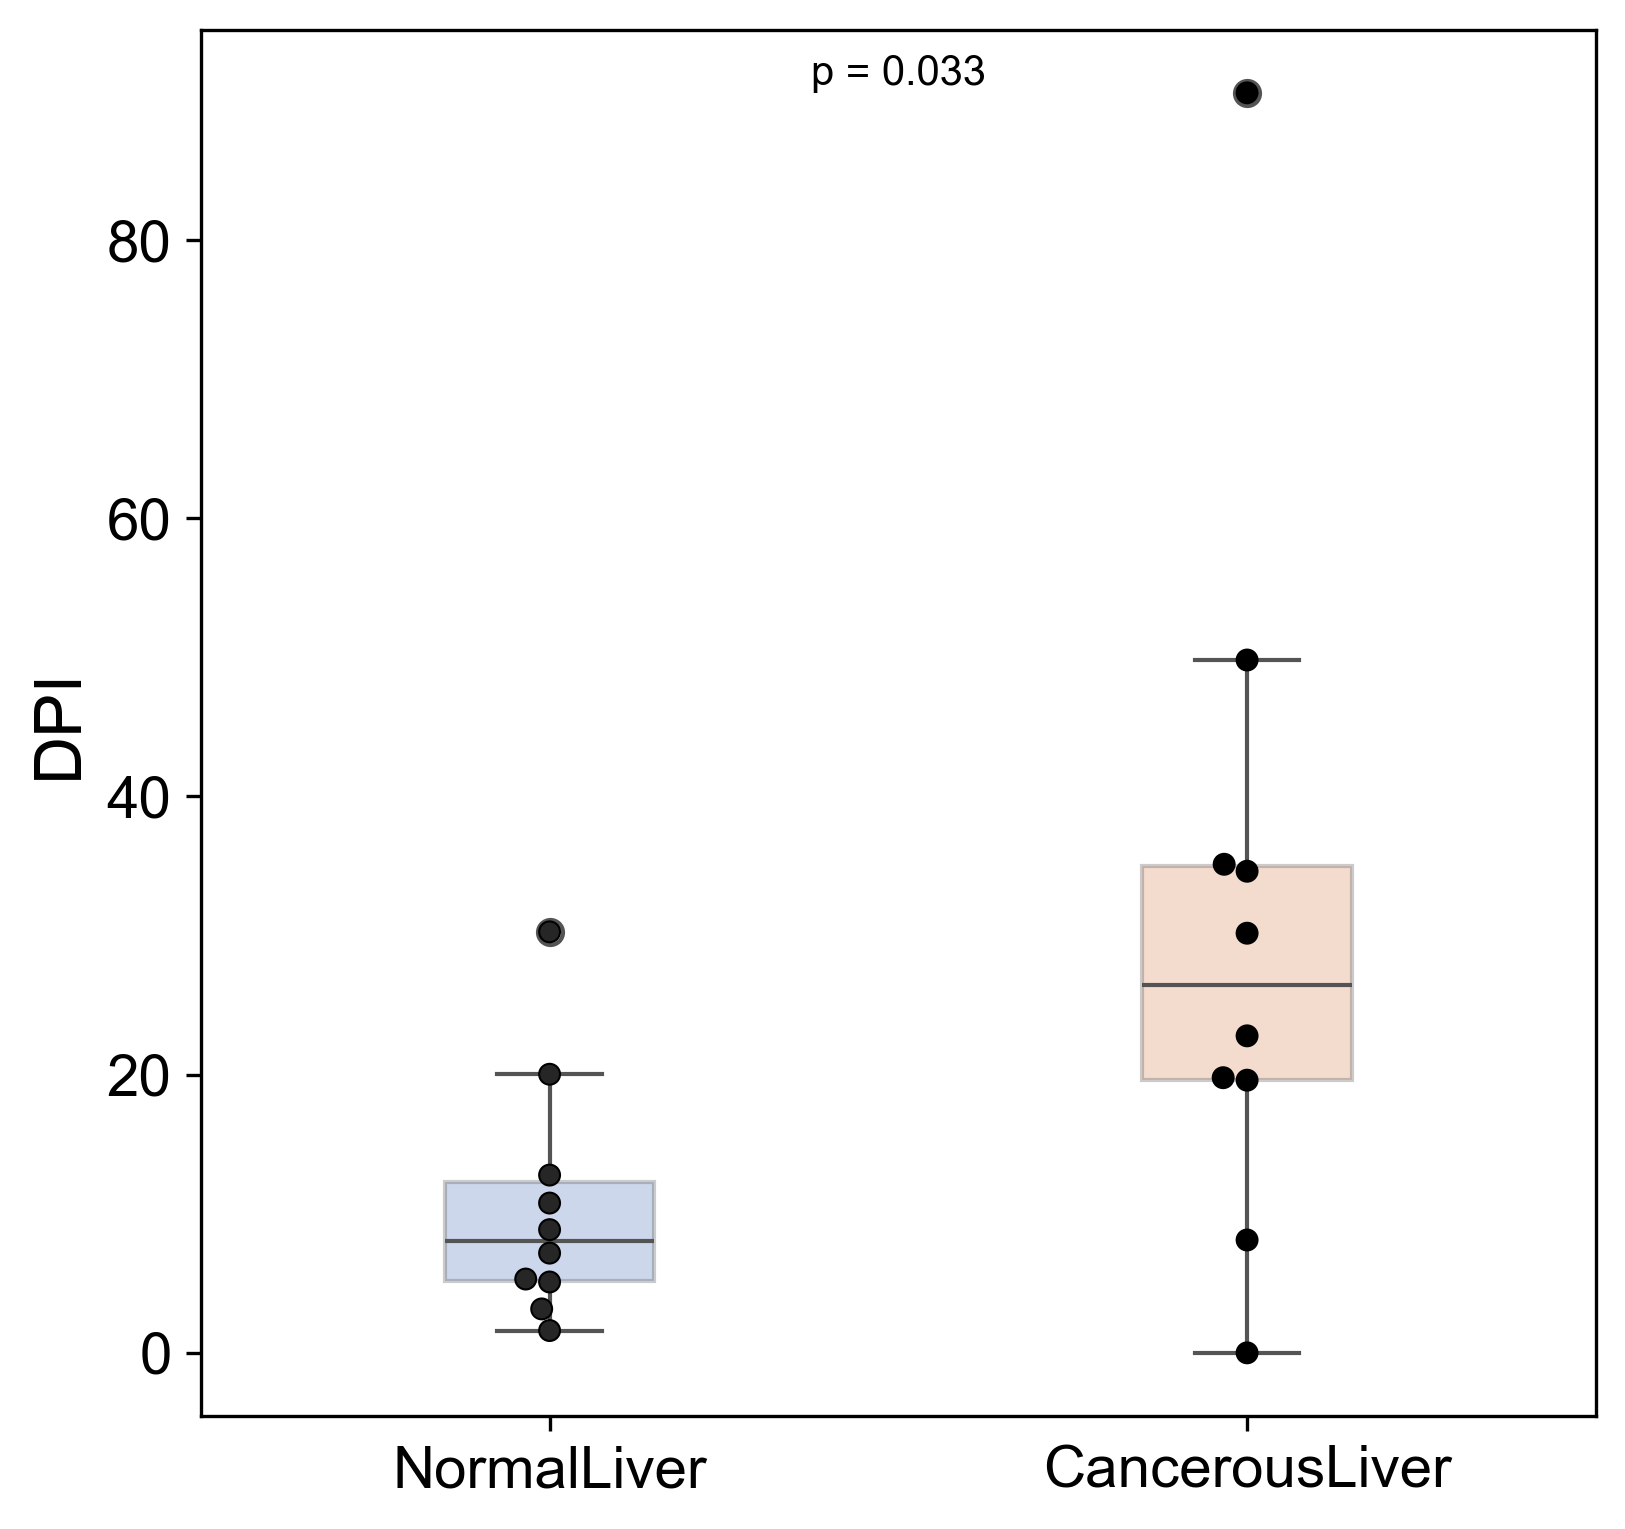

In [23]:
if Hot:
    save_path = cluster_key + '_HotIslands_Proximity_Index.svg'
else:
    save_path = cluster_key + '_ColdIslands_Proximity_Index.svg'
    
# Extract data for boxplot
normal_data = [v[0] for k, v in PX_results[0].items()]
cancerous_data = [v[0] for k, v in PX_results[1].items()]

# Mann-Whitney U test
#stat, p_value = stats.mannwhitneyu(balbc_data, mrl_data) # p=0.02381
stat, p_value = stats.ttest_ind(normal_data, cancerous_data,equal_var=False) # p=0.01381

# Combining data
data = [normal_data, cancerous_data]
labels = ['NormalLiver', 'CancerousLiver']

# Plotting
plt.figure(figsize=(6, 6), dpi=300)  # Higher dpi for better resolution
sns.boxplot(data=data, palette="muted", boxprops=dict(alpha=.3), width=0.3)  # Adjusted width here
sns.swarmplot(data=data, palette='dark:black', edgecolor='gray', linewidth=0.5, size=5)


plt.xticks(range(len(labels)), labels, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("DPI", fontsize=16)
# plt.title('Box plot of NormalLiver vs CancerousLiver', fontsize=18)


# Adding the p-value to the plot
plt.text(0.5, max(normal_data + cancerous_data), f'p = {p_value:.3f}', horizontalalignment='center', verticalalignment='bottom')

fig = plt.gcf()
fig.savefig('../figures/liver/'+save_path)
save_path = save_path.replace('.svg', '.jpeg')
fig.savefig('../figures/liver/'+save_path)
plt.show()
plt.close(fig)

## Calculate Multi-Scale Diversity Index

In [10]:
# Define the sequence of scales
scales = [1., 2., 4., 8., 16., 32., 64.]
scales = [2., 4., 8., 16., 24., 32., 48., 64., 72.] # for scale selection using GDI
cluster_key = 'cellType'

In [13]:
# Define the library_ids
library_ids = pd.unique(liver_df['sample'])
library_ids = library_ids[library_ids != '-1']
print(library_ids)

['N1' 'N7' 'N9' 'N6' 'N8' 'N2' 'N4' 'N5' 'N0' 'N3' 'C4' 'C0' 'C1' 'C5'
 'C6' 'C7' 'C9' 'C2' 'C3' 'C8']


In [14]:
df_entropy, df_slopes = msd.multiscale_diversity(spatial_data=liver_df,
                                                 scales=scales,
                                                 library_key='sample',
                                                 library_ids=library_ids,
                                                 spatial_key=['x_slide_um', 'y_slide_um'],
                                                 cluster_key=cluster_key,
                                                 mode='M',
                                                 random_patch=False,
                                                 plotfigs=False,
                                                 savefigs=False,
                                                 patch_kwargs={'random_seed': None, 'min_points':2},
                                                 other_kwargs={'metric': 'Shannon Diversity'})

Processing region: N1 at scale 2.0
0.000 per cent patches are empty
N1 at scale 2.0 has 0 patches with zero diveristy
N1 at scale 2.0 diversity is 2.6074273215775494
Processing region: N7 at scale 2.0
0.000 per cent patches are empty
N7 at scale 2.0 has 0 patches with zero diveristy
N7 at scale 2.0 diversity is 2.929799162242028
Processing region: N9 at scale 2.0
0.000 per cent patches are empty
N9 at scale 2.0 has 0 patches with zero diveristy
N9 at scale 2.0 diversity is 2.8637422800679055
Processing region: N6 at scale 2.0
0.000 per cent patches are empty
N6 at scale 2.0 has 0 patches with zero diveristy
N6 at scale 2.0 diversity is 2.6997147668486687
Processing region: N8 at scale 2.0
0.000 per cent patches are empty
N8 at scale 2.0 has 0 patches with zero diveristy
N8 at scale 2.0 diversity is 2.710089889235218
Processing region: N2 at scale 2.0
0.000 per cent patches are empty
N2 at scale 2.0 has 0 patches with zero diveristy
N2 at scale 2.0 diversity is 2.8544307674723877
Proces

In [15]:
df_results = pd.concat([df_entropy.transpose(), df_slopes.transpose()], axis=1)
df_results=df_results.rename(columns={0.0: 'Slope'})
df_results['Condition'] = ' '
df_results['Sample_id'] = df_results.index
df_results.loc[df_results.index.str.contains('N'), 'Condition'] = 'Normal'
df_results.loc[df_results.index.str.contains('C'), 'Condition'] = 'Cancerous'
# for col in df_results.columns[:-2]:  # Exclude 'Slope' and 'Condition'
#     df_results[f'Avg_{col}'] = df_results.groupby('Condition')[col].transform('mean')
df_results

2.0       4.0       8.0      16.0      24.0      32.0      48.0  \
N1 -0.333333  0.065093  0.119072  0.097752  0.231187  0.251131  0.159865   
N7 -0.333333 -0.054298  0.125484  0.166562  0.231015  0.278435  0.248315   
N9 -0.333333  0.078673  0.348545  0.204702  0.167349  0.114975  0.067191   
N6 -0.333333 -0.237662  0.077744  0.202806  0.145291  0.127751   0.07582   
N8 -0.333333 -0.176173  0.263473  0.294446  0.217398   0.16676  0.064276   
N2 -0.333333  0.145164  0.179811  0.136208  0.095905  0.056616  0.018314   
N4 -0.333333 -0.122067   0.11091  0.148763   0.08268  0.079183  0.039688   
N5 -0.333333  0.031144     0.182  0.215373  0.172495  0.121063   0.07443   
N0 -0.333333  0.092215  0.084038  0.258831  0.242428   0.21752  0.175401   
N3 -0.333333  0.055974  0.205468  0.171046  0.116508  0.082371  0.040981   
C4 -0.333333  0.013744    0.5173  0.596941  0.507796  0.419926  0.230498   
C0 -0.333333 -0.167592  0.144112  0.197634  0.166768  0.144161   0.14284   
C1 -0.333333 -0.000926  0.343928  0.344318   0.26797  0.251804  0.189374   
C5 -0.333333  0.419806  0.459064  0.358521  0.290322  0.228488  0.182897   
C6 -0.333333 -0.035136  0.369079  0.504122  0.440043  0.343462  0.249987   
C7 -0.333333  0.374507  0.565596  0.516744  0.445072   0.35964  0.174856   
C9 -0.333333  0.126937  0.421368   0.35784  0.242923  0.211452  0.174898   
C2 -0.333333 -0.086962  0.412626   0.47322  0.325271  0.249161  0.203174   
C3 -0.333333  0.419061  0.701344  0.616671  0.519557  0.418898   0.31129   
C8 -0.333333 -0.077396   0.14859  0.455701  0.541465  0.457089  0.348932   

        64.0      72.0     Slope  Condition Sample_id  
N1  0.083106  0.070906 -0.060678     Normal        N1  
N7  0.150784  0.126751 -0.084472     Normal        N7  
N9  0.046371  0.051603 -0.034408     Normal        N9  
N6  0.059763  0.046174 -0.073046     Normal        N6  
N8  0.046551  0.029216 -0.059019     Normal        N8  
N2  0.014051  0.022402 -0.026492     Normal        N2  
N4  0.032959  0.029558 -0.054756     Normal        N4  
N5  0.059961  0.042823 -0.046437     Normal        N5  
N0  0.137609  0.100247 -0.065108     Normal        N0  
N3  0.030412  0.024475 -0.036162     Normal        N3  
C4  0.146914  0.147107 -0.068885  Cancerous        C4  
C0  0.138053  0.114424 -0.079737  Cancerous        C0  
C1  0.141951  0.136712 -0.066282  Cancerous        C1  
C5  0.154597  0.154447 -0.028403  Cancerous        C5  
C6  0.201655  0.180576 -0.083735  Cancerous        C6  
C7  0.116064  0.109487 -0.026763  Cancerous        C7  
C9  0.164957   0.15316 -0.052780  Cancerous        C9  
C2  0.153975  0.133203 -0.071763  Cancerous        C2  
C3  0.223916  0.208542 -0.042395  Cancerous        C3  
C8  0.287956  0.273594 -0.120988  Cancerous        C8

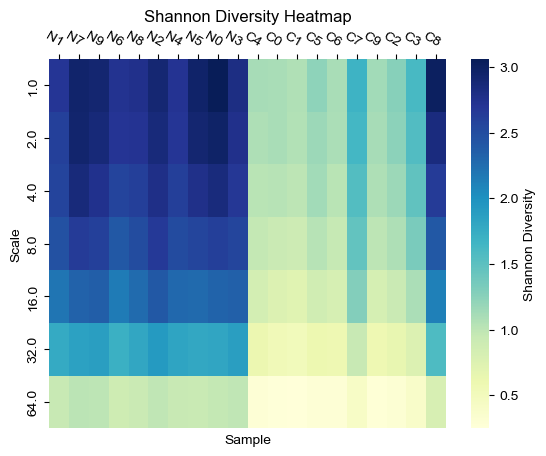

In [26]:
#scales.append('Slope')
numerical_data = df_results[scales].astype(float).T

# Create the heatmap
plt.figure()
ax = sns.heatmap(numerical_data, annot=False, fmt=".3f", cmap='YlGnBu', cbar_kws={'label': 'Shannon Diversity'})
ax.xaxis.tick_top() 
plt.setp(ax.get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor")
plt.title('Shannon Diversity Heatmap')
plt.xlabel('Sample')
plt.ylabel('Scale')
plt.show()

/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_48816/1082379246.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=df_results, x='Condition', y='Slope', palette='dark:black', edgecolor='gray', linewidth=0.5, size=5, ax=ax)
/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_48816/1082379246.py:6: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(data=df_results, x='Condition', y='Slope', palette='dark:black', edgecolor='gray', linewidth=0.5, size=5, ax=ax)


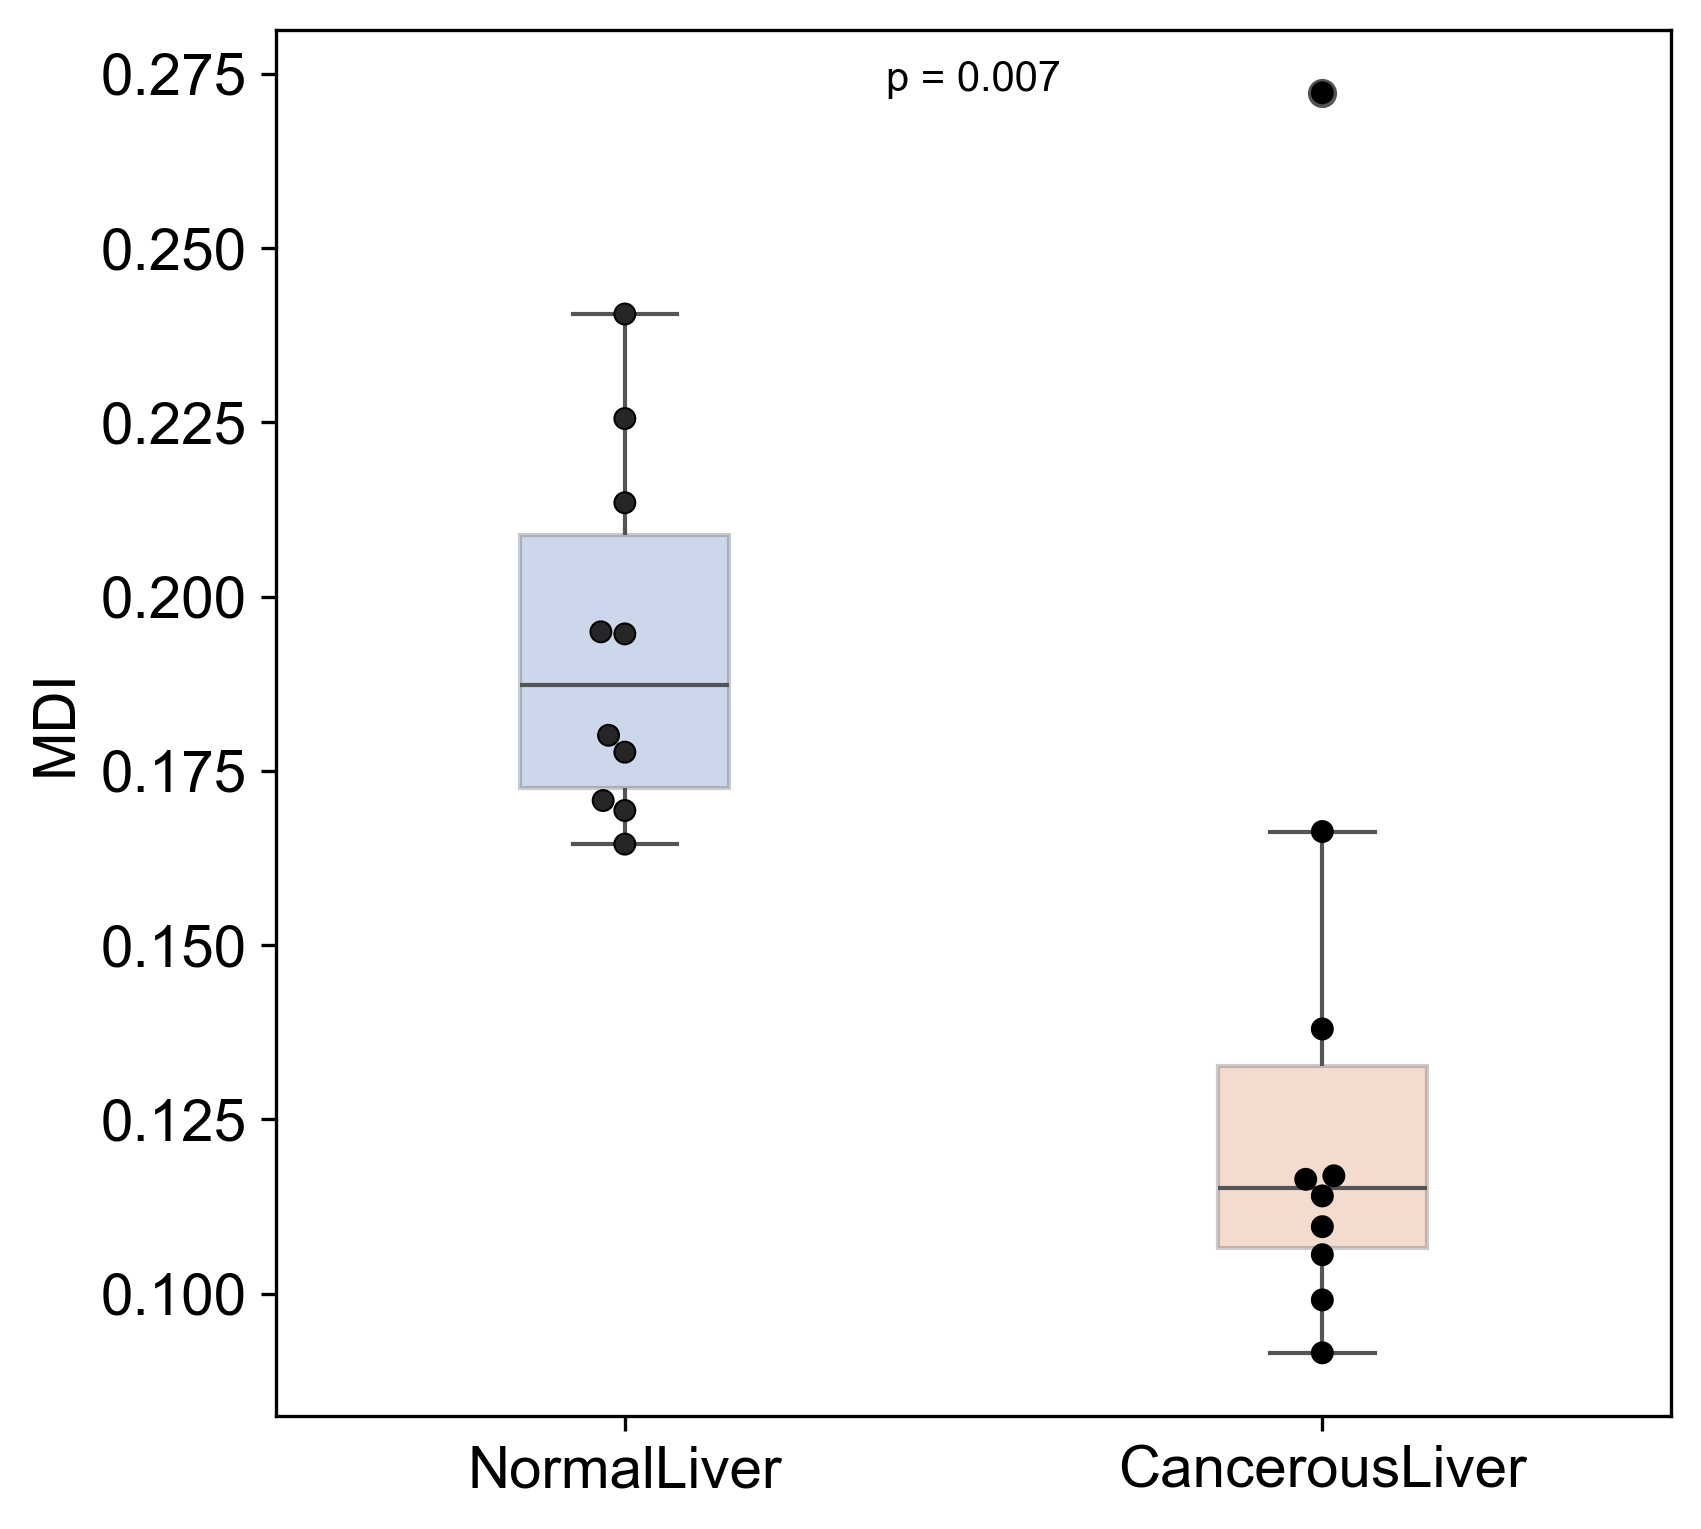

In [31]:
# Set a style that's commonly used for publications
fig, ax = plt.subplots(figsize=(6, 6),dpi=300)

# Boxplot
sns.boxplot(data=df_results, x='Condition', y='Slope', ax=ax, hue='Condition', palette="muted", width=0.3, boxprops=dict(alpha=.3))
sns.swarmplot(data=df_results, x='Condition', y='Slope', palette='dark:black', edgecolor='gray', linewidth=0.5, size=5, ax=ax)

# Labeling and titling
labels = ['NormalLiver', 'CancerousLiver']
ax.set_xlabel('')
ax.set_ylabel('MDI', fontsize=14) 
plt.xticks(range(len(labels)), labels, fontsize=14)
plt.yticks(fontsize=14)
ax.set_title('', fontsize=16)

# Separate data into two conditions
data_condition_1 = df_results[df_results['Condition'] == 'Normal']['Slope']
data_condition_2 = df_results[df_results['Condition'] == 'Cancerous']['Slope']

# Perform Mann-Whitney U test
#U_stat, p_val = stats.mannwhitneyu(data_condition_1, data_condition_2, alternative='two-sided')
stat, p_val = stats.ttest_ind(data_condition_1, data_condition_2 ,equal_var=False)

ax.text(0.5, 0.95, f'p = {p_val:.3f}', horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)

save_path = cluster_key + '_MSDiversity_slope.svg'
fig = plt.gcf()
fig.savefig('../figures/liver/'+save_path)
save_path = save_path.replace('.svg', '.jpeg')
fig.savefig('../figures/liver/'+save_path)

plt.show()
plt.close(fig)

/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_48816/2251285528.py:7: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(data=df_melted, x='Scale', y='Diversity Value', hue='Condition', dodge=True, size=3.0, color='black', edgecolor="gray", linewidth=0.5)
/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_48816/2251285528.py:7: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(data=df_melted, x='Scale', y='Diversity Value', hue='Condition', dodge=True, size=3.0, color='black', edgecolor="gray", linewidth=0.5)


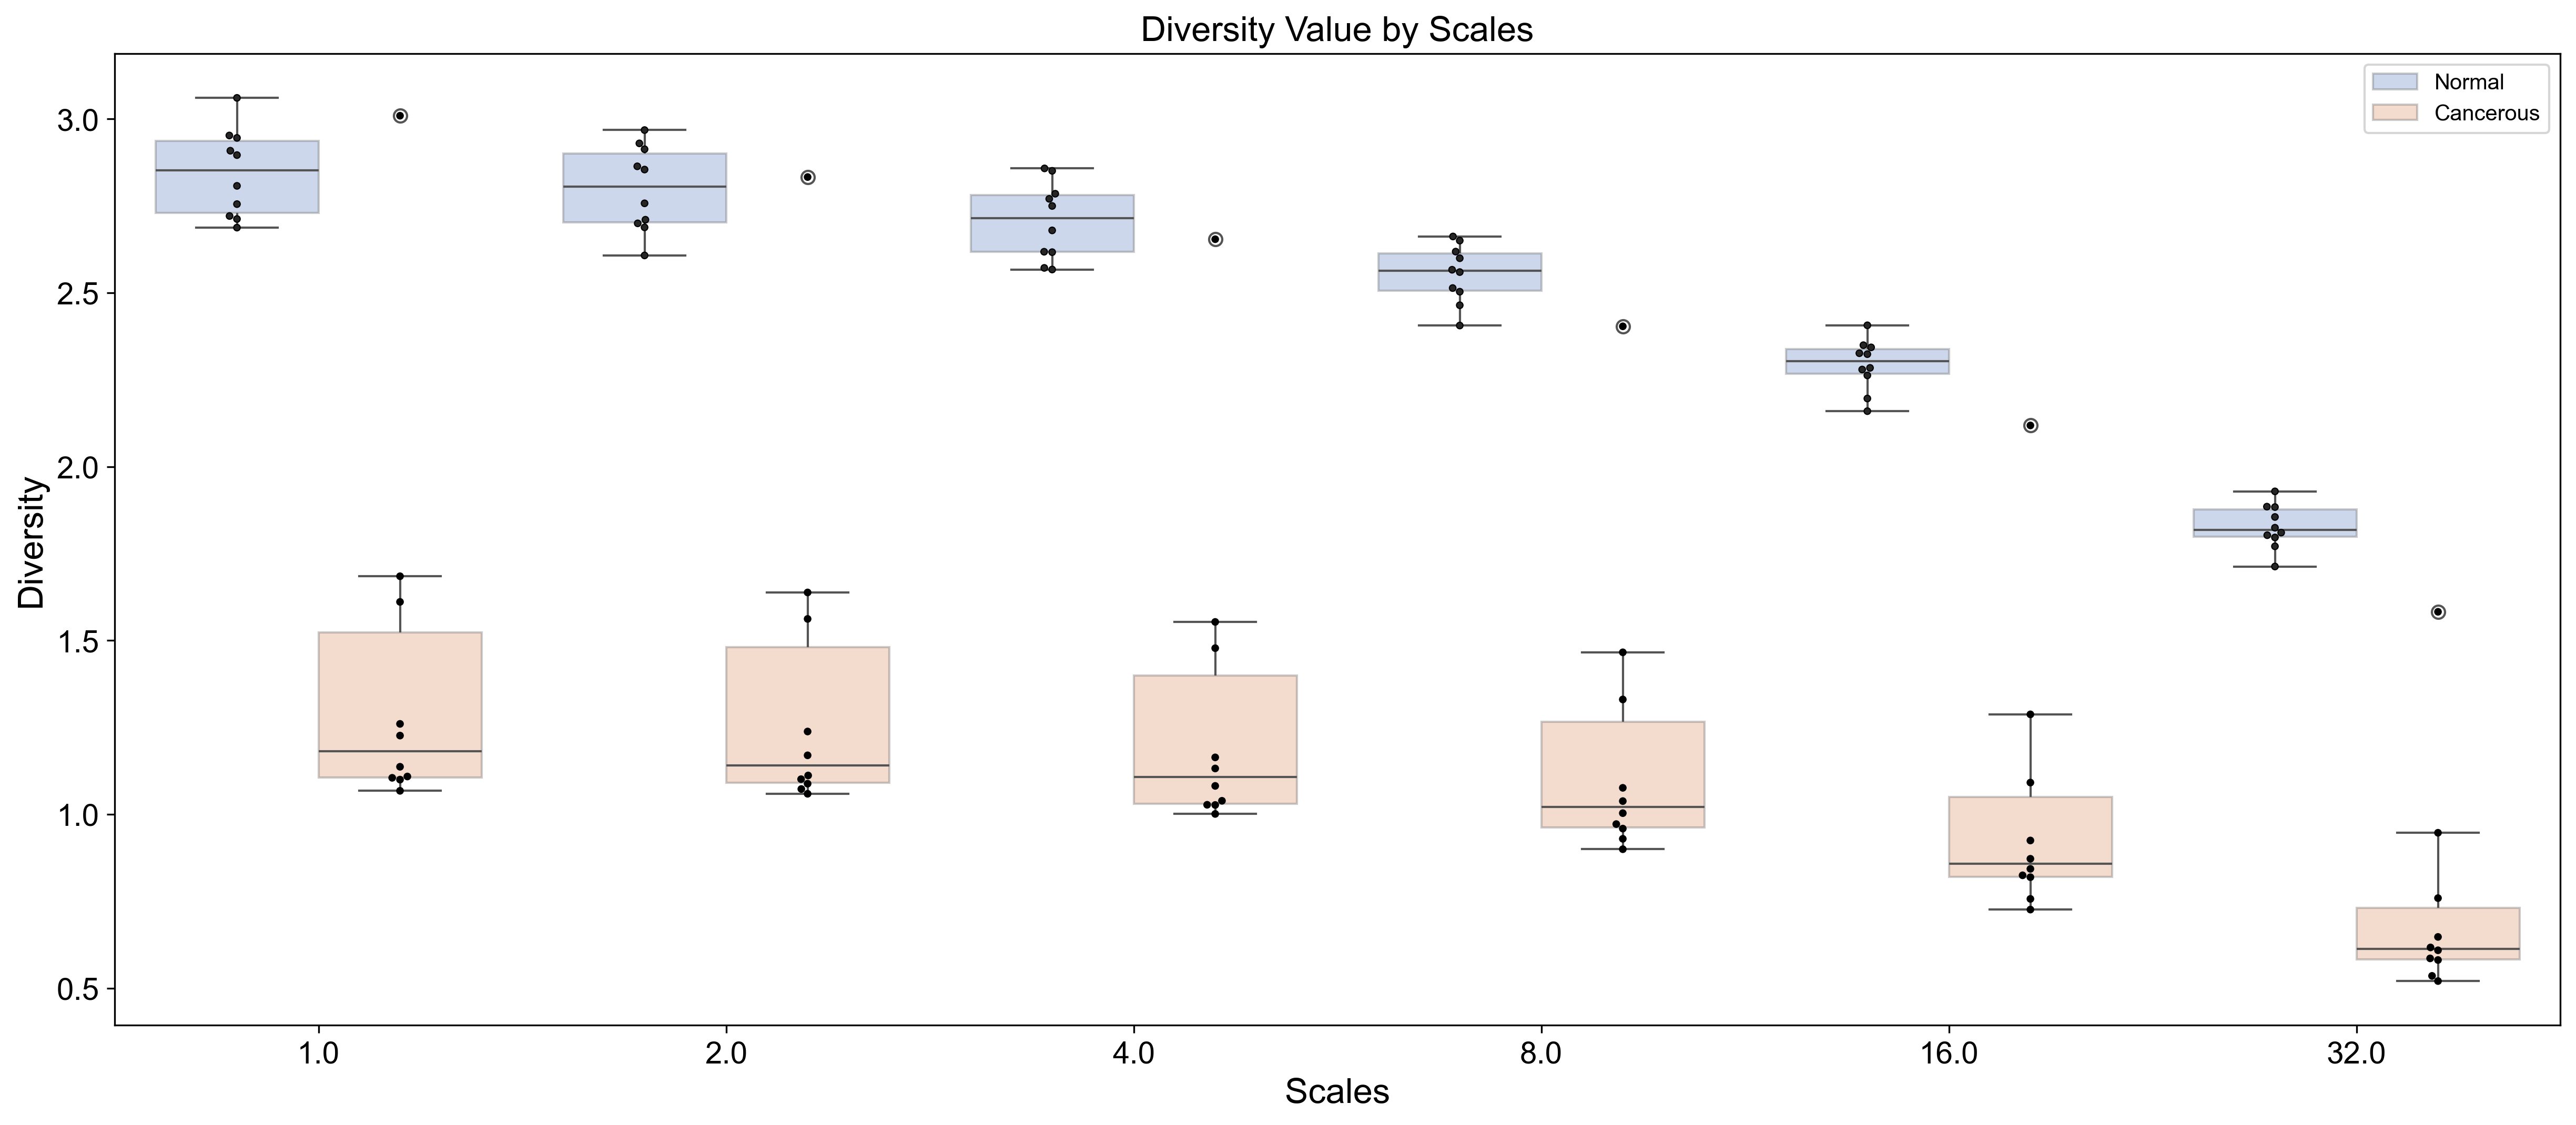

In [32]:
df_melted = pd.melt(df_results, id_vars=['Sample_id', 'Condition'], value_vars=scales, 
                    var_name='Scale', value_name='Diversity Value')

# Create the boxplot
plt.figure(figsize=(20, 8),dpi=300)
sns.boxplot(data=df_melted, x='Scale', y='Diversity Value', hue='Condition', palette='muted', boxprops=dict(alpha=.3))
sns.swarmplot(data=df_melted, x='Scale', y='Diversity Value', hue='Condition', dodge=True, size=3.0, color='black', edgecolor="gray", linewidth=0.5)

# Improve the legend
handles, labels = plt.gca().get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], loc=1)

# Set the title and labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax = plt.gca()
ax.set_title("Diversity Value by Scales", fontsize=16)
ax.set_xlabel('Scales', fontsize=16)
ax.set_ylabel('Diversity', fontsize=16)  

save_path = cluster_key + '_MHI_entropy.svg'
fig = plt.gcf()
fig.savefig('../figures/liver/'+save_path)
save_path = save_path.replace('.svg', '.jpeg')
fig.savefig('../figures/liver/'+save_path)
plt.show()
plt.close(fig)

In [16]:
df_melted = pd.melt(df_results, id_vars=['Sample_id', 'Condition'], value_vars=scales, 
                    var_name='Scale', value_name='Diversity Value')
df_melted['sample'] = 'Tissue Sample'
df_melted

Sample_id  Condition Scale Diversity Value         sample
0          N1     Normal   2.0       -0.333333  Tissue Sample
1          N7     Normal   2.0       -0.333333  Tissue Sample
2          N9     Normal   2.0       -0.333333  Tissue Sample
3          N6     Normal   2.0       -0.333333  Tissue Sample
4          N8     Normal   2.0       -0.333333  Tissue Sample
..        ...        ...   ...             ...            ...
175        C7  Cancerous  72.0        0.109487  Tissue Sample
176        C9  Cancerous  72.0         0.15316  Tissue Sample
177        C2  Cancerous  72.0        0.133203  Tissue Sample
178        C3  Cancerous  72.0        0.208542  Tissue Sample
179        C8  Cancerous  72.0        0.273594  Tissue Sample

[180 rows x 5 columns]

In [17]:
xrange = []
yrange = []
for region in liver_df['sample'].unique():
    x_values = liver_df[liver_df['sample']==region]['x_slide_um']
    y_values = liver_df[liver_df['sample']==region]['y_slide_um']
    xrange.append(x_values.max() - x_values.min())
    yrange.append(y_values.max() - y_values.min())
mean_xrange = np.mean(xrange)
std_xrange = np.std(xrange)
mean_yrange = np.mean(yrange)
std_yrange = np.std(yrange)

print(mean_xrange)
print(std_xrange)
print('-'*31)
print(mean_yrange)
print(std_yrange)

2083.2380952380954
2166.025851860892
-------------------------------
2107.0476190476193
2272.0580239947867


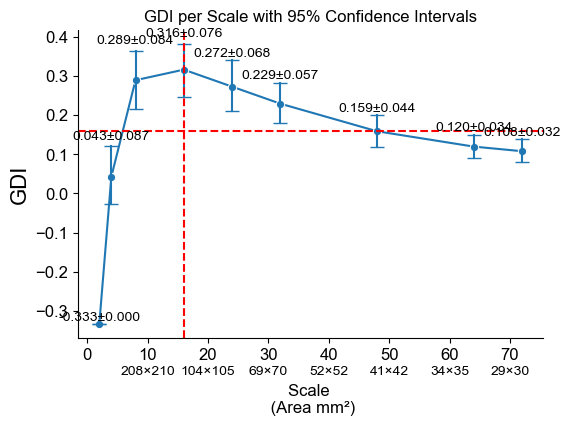

In [21]:
# Calculate mean and confidence interval manually
grouped = df_melted.groupby('Scale')
mean_values = grouped['Diversity Value'].mean()
conf_intervals = grouped['Diversity Value'].apply(lambda x: stats.sem(x) * stats.t.ppf((1 + 0.95) / 2., len(x)-1))

# Plotting using sns.lineplot
plt.figure(figsize=(6, 4))
ax = sns.lineplot(data=df_melted, 
                  x='Scale', 
                  y='Diversity Value', 
                  style='sample',
                  markers=True,
                  estimator='mean', 
                  err_style='bars', 
                  errorbar=("ci", 95),
                  err_kws={"capsize":5.0}
                 )

# Annotating error bars with their value
for i, (scale, mean, ci) in enumerate(zip(mean_values.index, mean_values, conf_intervals)):
    ax.text(scale, mean + ci, f'{mean:.3f}±{ci:.3f}', color='black', ha='center', va='bottom')

# Drawing red dashed horizontal lines at half the maximum of x and y axes
mean_diversity_per_scale = df_melted.groupby('Scale')['Diversity Value'].mean()
# y_sep = mean_diversity_per_scale.max() / 2
y_sep = mean_diversity_per_scale.median()
x_sep = mean_diversity_per_scale.idxmax()

# y_sep = df_melted.iloc[df_melted['Diversity Value'].idxmax()]['Diversity Value']/2
# x_sep = df_melted.iloc[df_melted['Diversity Value'].idxmax()]['Scale']
ax.axhline(y_sep, color='red', linestyle='--')
ax.axvline(x_sep, color='red', linestyle='--')

# Remove the legend
ax.get_legend().remove()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('', fontsize=0)
plt.xticks(fontsize=12)
plt.ylabel(f"GDI", fontsize=16)
plt.yticks(fontsize=12)

# Add secondary x-axis
xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()][2:-1]
scales = [int(label) for label in xtick_labels if label.strip() != '']
x_sizes = [mean_xrange / scale for scale in scales]
y_sizes = [mean_yrange / scale for scale in scales]
size_labels = [f"{int(x_size)}×{int(y_size)}" for x_size, y_size in zip(x_sizes, y_sizes)]
secax = ax.secondary_xaxis(location=-0.075)
secax.set_xticks(scales)
secax.set_xticklabels(size_labels)
secax.tick_params('x', length=0)
secax.spines['bottom'].set_linewidth(0)
secax.set_xlabel(f'Scale \n (Area μm²)', fontsize=12)

plt.title(f'GDI per Scale with 95% Confidence Intervals')
plt.grid(False)
fig = plt.gcf()
fig.savefig('../figures/liver/liver_scale_selection.svg')
plt.show()
